In [2]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution
from PIL import Image


%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [3]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

In [4]:
def distance(row,cluster_center,z_col_names):
    return norm(row[z_col_names].values - cluster_center)
from scipy.spatial.distance import mahalanobis
def distance(row, inv_cov, cluster_center,z_col_names):
    return mahalanobis(row[z_col_names].values, cluster_center, inv_cov)


import scipy as sp

def compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers):

    for i in range(num_clusters):
        df["distance_{}".format(i)] = 100000
    for cluster_num in range(num_clusters):
        indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
        lv= df[z_col_names].values[indices, :]
        print(lv.shape)
        cov = np.cov(lv.T)
        inv_cov = sp.linalg.inv(cov)
        df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                       inv_cov,
                                                                                                       cluster_centers[cluster_num],
                                                                                                       z_col_names),
                                                                                     axis=1)


In [5]:
def compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers):
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            lv= df[z_col_names].values[indices, :]
            cov = np.cov(lv.T)
            inv_cov = sp.linalg.inv(cov)

            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               inv_cov,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


# Set experiment parameters

In [6]:
z_dim = 10
run_id = 45
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

In [8]:
experiment_name = "semi_sup_gaussian_mah_k8"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

exp_config = ExperimentConfig(root_path=ROOT_PATH,
                               num_decoder_layer=4,
                               z_dim=z_dim,
                               num_units=num_units,
                               num_cluster_config=num_cluster_config,
                               confidence_decay_factor=8,
                               beta=5,
                               supervise_weight=150,
                               dataset_name="mnist",
                               split_name="Split_1",
                               model_name="VAE",
                               batch_size=64,
                               eval_interval_in_epochs=1,
                               name=experiment_name,
                               num_val_samples=128,
                               total_training_samples=60000,
                               manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                               reconstruction_weight=1,
                               activation_hidden_layer="RELU",
                               activation_output_layer="SIGMOID")
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [9]:
# K = exp_config.confidence_decay_factor
# def convert_distance_to_confidence(dist):
#     return np.exp(-1 / K * dist)

# def get_percentage_correct(confidence):
#     df1 = df[df["manual_annotation_confidence"] > confidence]
#     if df1.shape[0] != 0:
#         df2 = df1[df1["manual_annotation"] == df1["label"]]        
#         return df2.shape[0] / df1.shape[0]
#     else:
#         return 1
# def get_distance(confidence):
#     return -K * log(confidence)
# def get_confidence(distance):
#     return np.exp(-distance/K)

K = exp_config.confidence_decay_factor
def convert_distance_to_confidence(dist):
    return np.exp(-1 / K * dist * dist)

def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1
def get_distance(confidence):
    return math.sqrt(-K * log(confidence))

def get_confidence(distance):
    return np.exp(-distance * distance/K)


In [10]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

# Train model

In [11]:
num_epochs = 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Warning /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_45/analysis/manual_annotation_epoch_-1.0.csv path does not exist. Creating random prior 

Epoch: 0/45, Nll_loss : 209.7144012451172 KLD:1.0385425090789795  Supervised loss:0.0
Epoch: 0/46, Nll_loss : 231.48634338378906 KLD:0.9186826944351196  Supervised loss:0.0
Epoch: 0/47, Nll_loss : 204.69146728515625 KLD:0.9992759227752686  Supervised loss:0.0
Epoch: 0/48, Nll_loss : 208.45184326171875 KLD:0.8538649082183838  Supervised loss:0.0
Epoch: 0/49, Nll_loss : 218.9579620361328 KLD:0.7837053537368774  Supervised loss:0.0
Epoch: 0/50, Nll_loss : 215.85494995117188 KLD:0.8847415447235107  Supervised loss:0.0
Epoch: 0/51, Nll_loss : 208.19232177734375 KLD:0.9408408999443054  Supervised loss:0.0
Epoch: 0/52, Nll_loss : 203.30569458007812 KLD:1.0572166442871094  Supervised loss:0.0
Epoch: 0/53, Nll_loss : 202.6477813720703 KLD:1.1239275932312012  Supervised loss:0.0
Epoch: 0/54, Nll_loss : 212.50991821289062 KLD:1.1468260288238525  Supervised loss:0.0
Epoch: 0/55, Nll_loss : 216.01153564453125 KLD:1.0260891914367676  Supervised loss:0.0
Epoch: 0/56, Nll_loss : 217.65237426757812 KLD

Epoch: 0/140, Nll_loss : 191.24330139160156 KLD:1.5379490852355957  Supervised loss:0.0
Epoch: 0/141, Nll_loss : 190.63450622558594 KLD:1.8666967153549194  Supervised loss:0.0
Epoch: 0/142, Nll_loss : 189.944091796875 KLD:2.0110931396484375  Supervised loss:0.0
Epoch: 0/143, Nll_loss : 188.53823852539062 KLD:2.1106009483337402  Supervised loss:0.0
Epoch: 0/144, Nll_loss : 184.05523681640625 KLD:2.2091856002807617  Supervised loss:0.0
Epoch: 0/145, Nll_loss : 177.91171264648438 KLD:2.164504289627075  Supervised loss:0.0
Epoch: 0/146, Nll_loss : 182.13211059570312 KLD:2.2057931423187256  Supervised loss:0.0
Epoch: 0/147, Nll_loss : 183.64842224121094 KLD:2.2564077377319336  Supervised loss:0.0
Epoch: 0/148, Nll_loss : 188.9197998046875 KLD:2.3467161655426025  Supervised loss:0.0
Epoch: 0/149, Nll_loss : 180.7088165283203 KLD:2.165367603302002  Supervised loss:0.0
Epoch: 0/150, Nll_loss : 190.86569213867188 KLD:2.2068111896514893  Supervised loss:0.0
Epoch: 0/151, Nll_loss : 183.580169677

Epoch: 0/235, Nll_loss : 166.9818572998047 KLD:4.0408148765563965  Supervised loss:0.0
Epoch: 0/236, Nll_loss : 164.27474975585938 KLD:4.390202522277832  Supervised loss:0.0
Epoch: 0/237, Nll_loss : 164.7874755859375 KLD:3.9555282592773438  Supervised loss:0.0
Epoch: 0/238, Nll_loss : 157.85467529296875 KLD:4.171817302703857  Supervised loss:0.0
Epoch: 0/239, Nll_loss : 161.40869140625 KLD:4.134502410888672  Supervised loss:0.0
Epoch: 0/240, Nll_loss : 158.074462890625 KLD:4.200957298278809  Supervised loss:0.0
Epoch: 0/241, Nll_loss : 164.81982421875 KLD:4.202797889709473  Supervised loss:0.0
Epoch: 0/242, Nll_loss : 163.51724243164062 KLD:4.131962776184082  Supervised loss:0.0
Epoch: 0/243, Nll_loss : 156.56199645996094 KLD:4.171815872192383  Supervised loss:0.0
Epoch: 0/244, Nll_loss : 167.85107421875 KLD:4.246637344360352  Supervised loss:0.0
Epoch: 0/245, Nll_loss : 164.84219360351562 KLD:4.118838310241699  Supervised loss:0.0
Epoch: 0/246, Nll_loss : 166.82540893554688 KLD:4.1727

Epoch: 0/331, Nll_loss : 148.96331787109375 KLD:4.769374370574951  Supervised loss:0.0
Epoch: 0/332, Nll_loss : 147.16566467285156 KLD:4.971349239349365  Supervised loss:0.0
Epoch: 0/333, Nll_loss : 154.68821716308594 KLD:5.513427257537842  Supervised loss:0.0
Epoch: 0/334, Nll_loss : 152.77804565429688 KLD:5.144315719604492  Supervised loss:0.0
Epoch: 0/335, Nll_loss : 153.02919006347656 KLD:4.705555438995361  Supervised loss:0.0
Epoch: 0/336, Nll_loss : 155.4157257080078 KLD:4.956419944763184  Supervised loss:0.0
Epoch: 0/337, Nll_loss : 154.71011352539062 KLD:4.756251335144043  Supervised loss:0.0
Epoch: 0/338, Nll_loss : 156.1807861328125 KLD:4.460756301879883  Supervised loss:0.0
Epoch: 0/339, Nll_loss : 167.13369750976562 KLD:4.529195785522461  Supervised loss:0.0
Epoch: 0/340, Nll_loss : 155.94541931152344 KLD:4.647834777832031  Supervised loss:0.0
Epoch: 0/341, Nll_loss : 146.8787841796875 KLD:4.9635162353515625  Supervised loss:0.0
Epoch: 0/342, Nll_loss : 149.5008544921875 KL

Epoch: 0/427, Nll_loss : 147.46820068359375 KLD:5.632478713989258  Supervised loss:0.0
Epoch: 0/428, Nll_loss : 144.09080505371094 KLD:5.2327680587768555  Supervised loss:0.0
Epoch: 0/429, Nll_loss : 160.90176391601562 KLD:4.871456146240234  Supervised loss:0.0
Epoch: 0/430, Nll_loss : 150.75196838378906 KLD:5.069934844970703  Supervised loss:0.0
Epoch: 0/431, Nll_loss : 144.5712127685547 KLD:4.75559663772583  Supervised loss:0.0
Epoch: 0/432, Nll_loss : 151.7530059814453 KLD:4.946732997894287  Supervised loss:0.0
Epoch: 0/433, Nll_loss : 153.1087188720703 KLD:5.398859024047852  Supervised loss:0.0
Epoch: 0/434, Nll_loss : 143.84860229492188 KLD:5.4087371826171875  Supervised loss:0.0
Epoch: 0/435, Nll_loss : 147.29092407226562 KLD:5.473233222961426  Supervised loss:0.0
Epoch: 0/436, Nll_loss : 149.63902282714844 KLD:6.078046798706055  Supervised loss:0.0
Epoch: 0/437, Nll_loss : 153.00755310058594 KLD:5.881072044372559  Supervised loss:0.0
Epoch: 0/438, Nll_loss : 140.99676513671875 K

Epoch: 0/523, Nll_loss : 155.65048217773438 KLD:5.720674514770508  Supervised loss:0.0
Epoch: 0/524, Nll_loss : 141.36917114257812 KLD:5.5201735496521  Supervised loss:0.0
Epoch: 0/525, Nll_loss : 141.1268310546875 KLD:5.741441249847412  Supervised loss:0.0
Epoch: 0/526, Nll_loss : 138.92813110351562 KLD:5.551785945892334  Supervised loss:0.0
Epoch: 0/527, Nll_loss : 134.84378051757812 KLD:5.567092418670654  Supervised loss:0.0
Epoch: 0/528, Nll_loss : 134.29986572265625 KLD:5.385720252990723  Supervised loss:0.0
Epoch: 0/529, Nll_loss : 146.2338409423828 KLD:5.253582000732422  Supervised loss:0.0
Epoch: 0/530, Nll_loss : 142.60794067382812 KLD:5.439741134643555  Supervised loss:0.0
Epoch: 0/531, Nll_loss : 137.45849609375 KLD:5.382699966430664  Supervised loss:0.0
Epoch: 0/532, Nll_loss : 152.59841918945312 KLD:5.385599136352539  Supervised loss:0.0
Epoch: 0/533, Nll_loss : 142.67434692382812 KLD:5.537096977233887  Supervised loss:0.0
Epoch: 0/534, Nll_loss : 153.77574157714844 KLD:5.

Epoch: 0/618, Nll_loss : 136.133544921875 KLD:5.838685989379883  Supervised loss:0.0
Epoch: 0/619, Nll_loss : 143.46446228027344 KLD:5.9661712646484375  Supervised loss:0.0
Epoch: 0/620, Nll_loss : 144.592529296875 KLD:5.819816589355469  Supervised loss:0.0
Epoch: 0/621, Nll_loss : 145.73312377929688 KLD:5.7301859855651855  Supervised loss:0.0
Epoch: 0/622, Nll_loss : 138.22607421875 KLD:5.560546875  Supervised loss:0.0
Epoch: 0/623, Nll_loss : 134.33078002929688 KLD:5.856202125549316  Supervised loss:0.0
Epoch: 0/624, Nll_loss : 145.3778533935547 KLD:5.916426658630371  Supervised loss:0.0
Epoch: 0/625, Nll_loss : 148.15614318847656 KLD:6.016661643981934  Supervised loss:0.0
Epoch: 0/626, Nll_loss : 143.92042541503906 KLD:5.801003456115723  Supervised loss:0.0
Epoch: 0/627, Nll_loss : 139.27420043945312 KLD:5.747696876525879  Supervised loss:0.0
Epoch: 0/628, Nll_loss : 139.76318359375 KLD:5.823951721191406  Supervised loss:0.0
Epoch: 0/629, Nll_loss : 141.47483825683594 KLD:5.65862226

Epoch: 0/714, Nll_loss : 139.00701904296875 KLD:5.789151191711426  Supervised loss:0.0
Epoch: 0/715, Nll_loss : 136.9395751953125 KLD:5.598119735717773  Supervised loss:0.0
Epoch: 0/716, Nll_loss : 137.3297576904297 KLD:5.966508865356445  Supervised loss:0.0
Epoch: 0/717, Nll_loss : 142.9036407470703 KLD:6.486432075500488  Supervised loss:0.0
Epoch: 0/718, Nll_loss : 132.05679321289062 KLD:6.00920295715332  Supervised loss:0.0
Epoch: 0/719, Nll_loss : 140.73764038085938 KLD:5.92899227142334  Supervised loss:0.0
Epoch: 0/720, Nll_loss : 136.24746704101562 KLD:6.140171051025391  Supervised loss:0.0
Epoch: 0/721, Nll_loss : 137.6399688720703 KLD:6.118852615356445  Supervised loss:0.0
Epoch: 0/722, Nll_loss : 129.85684204101562 KLD:6.027812957763672  Supervised loss:0.0
Epoch: 0/723, Nll_loss : 140.22445678710938 KLD:6.077836990356445  Supervised loss:0.0
Epoch: 0/724, Nll_loss : 140.38882446289062 KLD:6.19467306137085  Supervised loss:0.0
Epoch: 0/725, Nll_loss : 137.5974578857422 KLD:6.0

Epoch: 0/809, Nll_loss : 141.79019165039062 KLD:5.823345184326172  Supervised loss:0.0
Epoch: 0/810, Nll_loss : 139.6453094482422 KLD:5.944934844970703  Supervised loss:0.0
Epoch: 0/811, Nll_loss : 141.4835205078125 KLD:5.7575201988220215  Supervised loss:0.0
Epoch: 0/812, Nll_loss : 136.52572631835938 KLD:6.0457000732421875  Supervised loss:0.0
Epoch: 0/813, Nll_loss : 138.04534912109375 KLD:5.958739280700684  Supervised loss:0.0
Epoch: 0/814, Nll_loss : 132.313232421875 KLD:6.08079195022583  Supervised loss:0.0
Epoch: 0/815, Nll_loss : 142.35108947753906 KLD:6.3225250244140625  Supervised loss:0.0
Epoch: 0/816, Nll_loss : 135.7506561279297 KLD:6.241654396057129  Supervised loss:0.0
Epoch: 0/817, Nll_loss : 139.28866577148438 KLD:6.039608955383301  Supervised loss:0.0
Epoch: 0/818, Nll_loss : 126.1483154296875 KLD:6.067828178405762  Supervised loss:0.0
Epoch: 0/819, Nll_loss : 141.13092041015625 KLD:6.547760009765625  Supervised loss:0.0
Epoch: 0/820, Nll_loss : 137.2933349609375 KLD:

Epoch: 0/906, Nll_loss : 134.7102508544922 KLD:6.492849349975586  Supervised loss:0.0
Epoch: 0/907, Nll_loss : 143.66482543945312 KLD:6.697140693664551  Supervised loss:0.0
Epoch: 0/908, Nll_loss : 133.64773559570312 KLD:6.491975784301758  Supervised loss:0.0
Epoch: 0/909, Nll_loss : 132.1683807373047 KLD:6.268482685089111  Supervised loss:0.0
Epoch: 0/910, Nll_loss : 139.42005920410156 KLD:6.482357025146484  Supervised loss:0.0
Epoch: 0/911, Nll_loss : 130.55279541015625 KLD:6.330097198486328  Supervised loss:0.0
Epoch: 0/912, Nll_loss : 139.6790008544922 KLD:6.154111385345459  Supervised loss:0.0
Epoch: 0/913, Nll_loss : 132.26483154296875 KLD:6.272547245025635  Supervised loss:0.0
Epoch: 0/914, Nll_loss : 133.16751098632812 KLD:6.318943023681641  Supervised loss:0.0
Epoch: 0/915, Nll_loss : 145.69142150878906 KLD:5.858772277832031  Supervised loss:0.0
Epoch: 0/916, Nll_loss : 139.72958374023438 KLD:5.987672805786133  Supervised loss:0.0
Epoch: 0/917, Nll_loss : 130.33529663085938 KL

# Load the trained model

In [12]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS
Number of steps completed=936
Number of epochs completed 1.0


# Read the latent vectors for train data

In [13]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=45 z_min=-4.363441000000001 z_max=4.444129
Latent vectors shape (59840, 10)


# Load training images,  labels and manual annotations

In [14]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 1.0


# Use Elbow method to to find out number of optimum clusters k

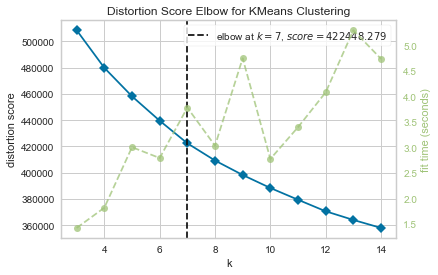

In [15]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [16]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
#num_clusters = 16

In [17]:
num_clusters

10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS


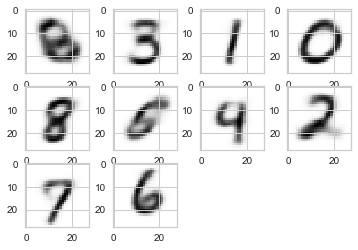

In [18]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
if not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [19]:
manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [-1, 3, 1, 0,
                                               8, -1, -1, 2,
                                               7,6
                                              ]
    manual_annotation_json["manual_confidence"] = [0, 0.8, 1, 1,
                                                  0.9, 0, 0, 0.7,
                                                  0.7, 0.9]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [20]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [21]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

In [22]:
cluster_group_dict

{'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7fb2b84ae8d0>,
 'good_clusters': <clearn.analysis.ClusterGroup at 0x7fb2b844f550>,
 None: <clearn.analysis.ClusterGroup at 0x7fb2bc284390>}

In [23]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


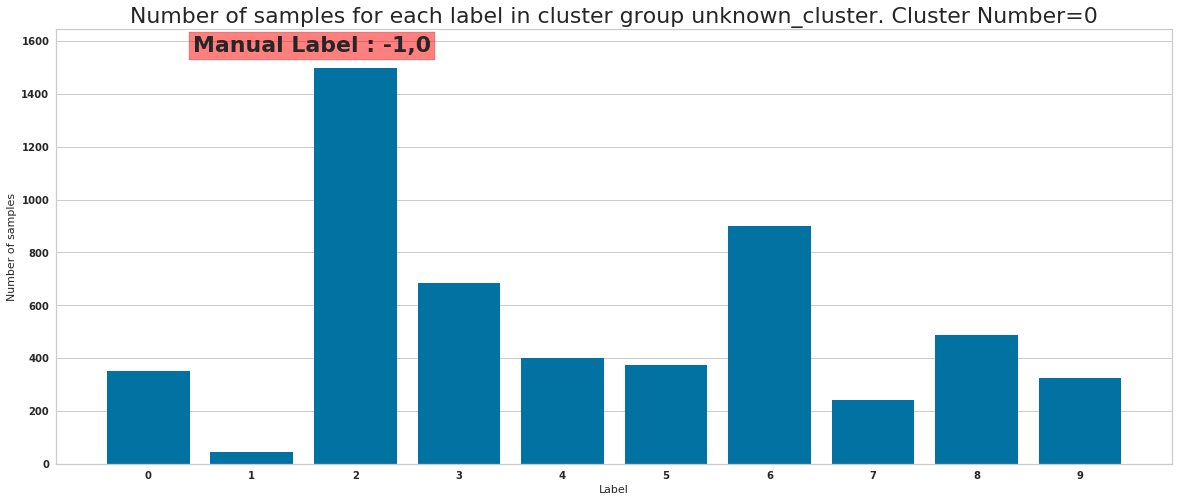

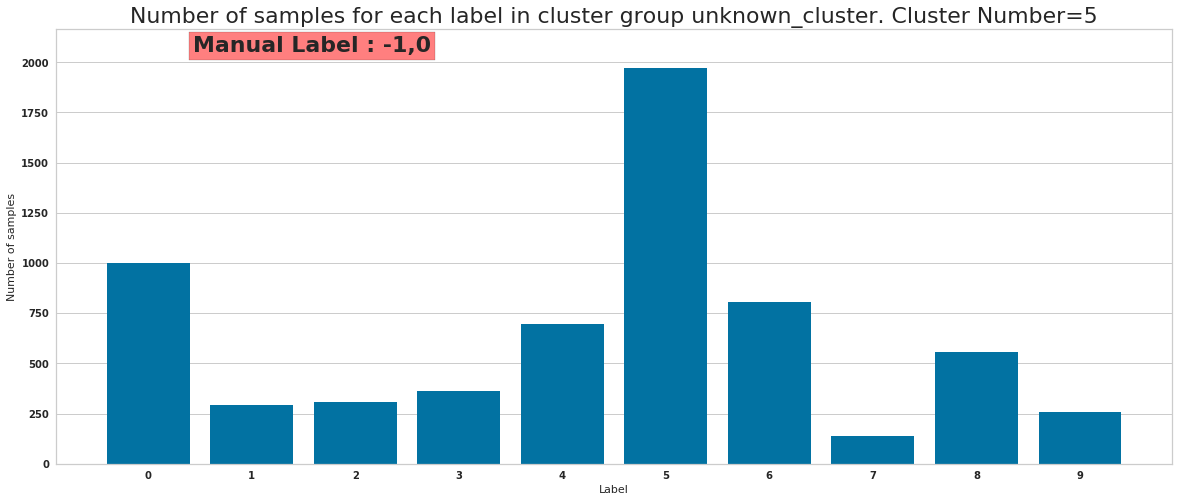

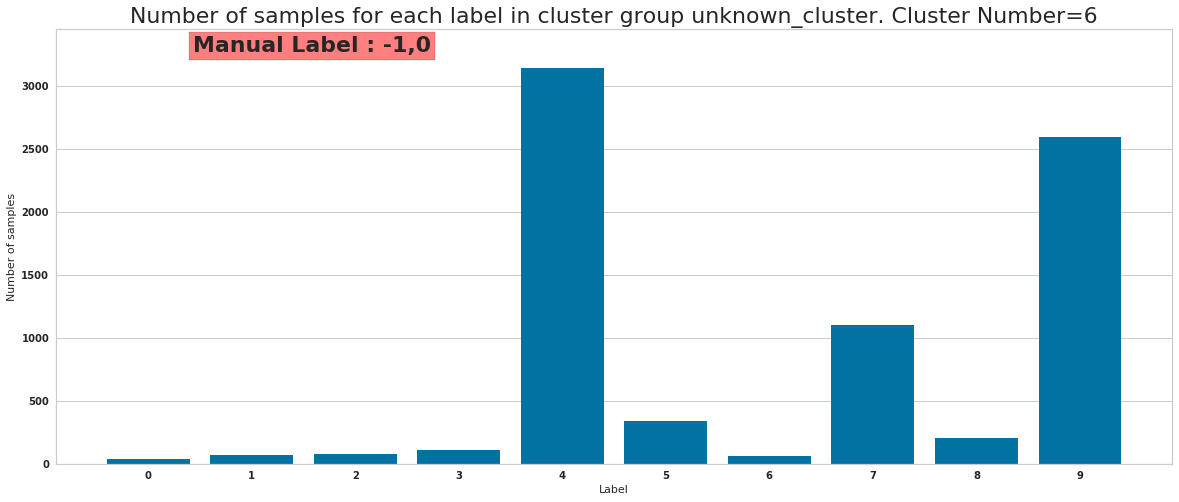

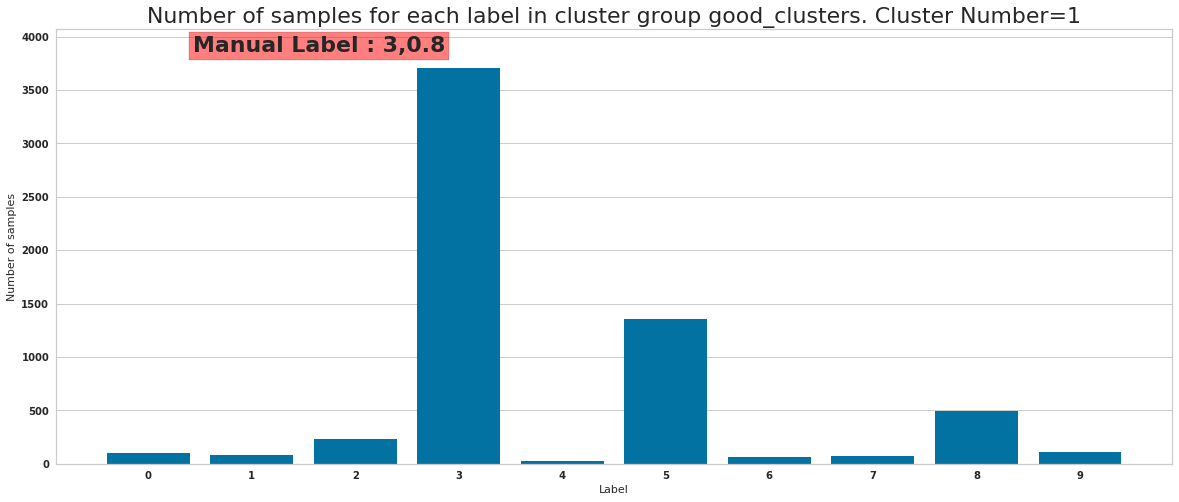

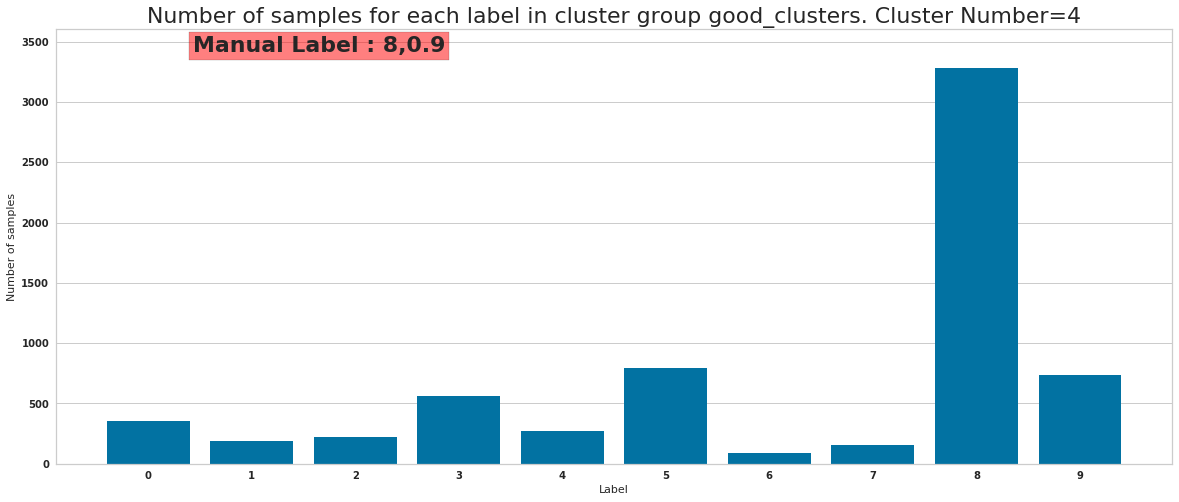

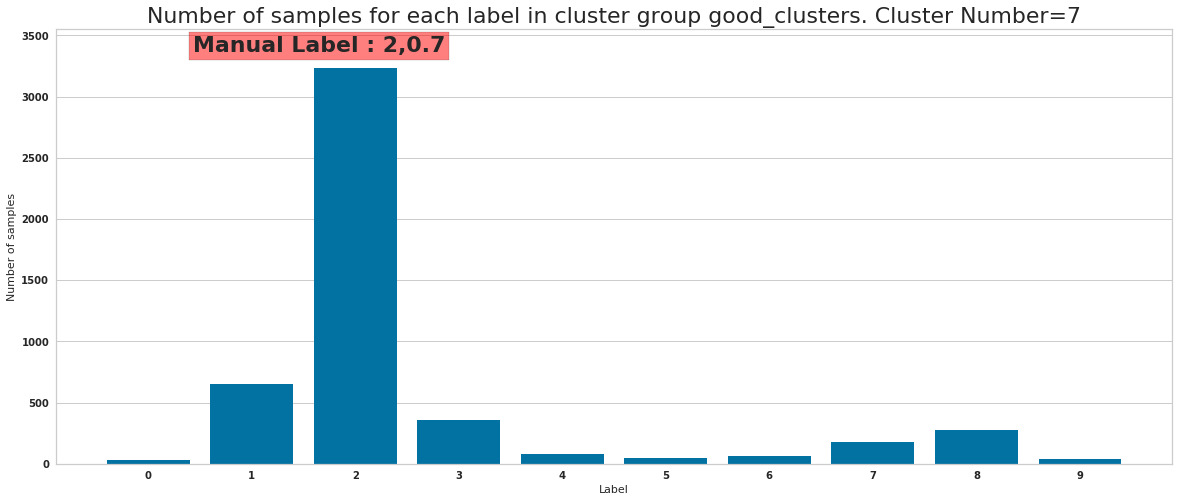

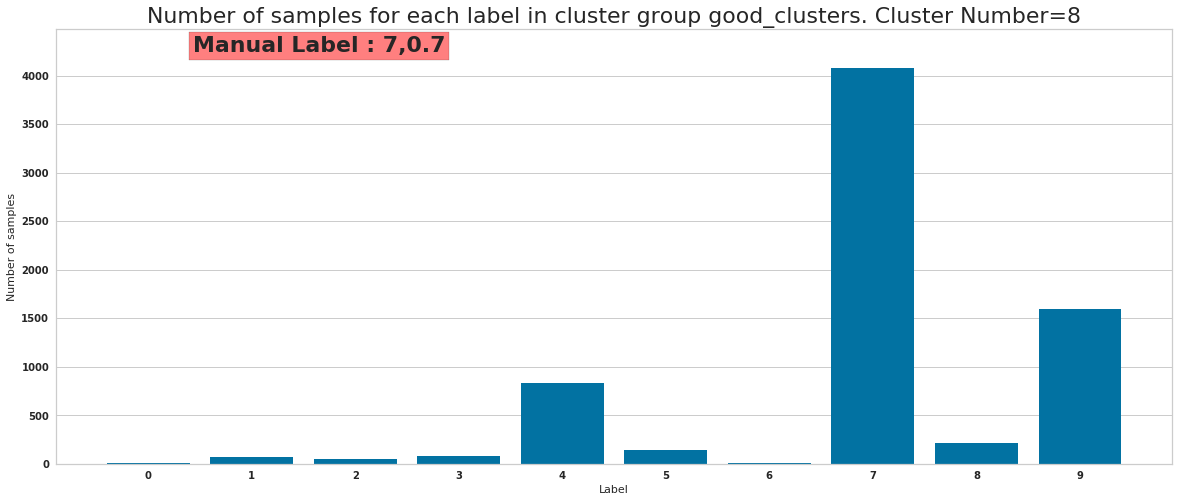

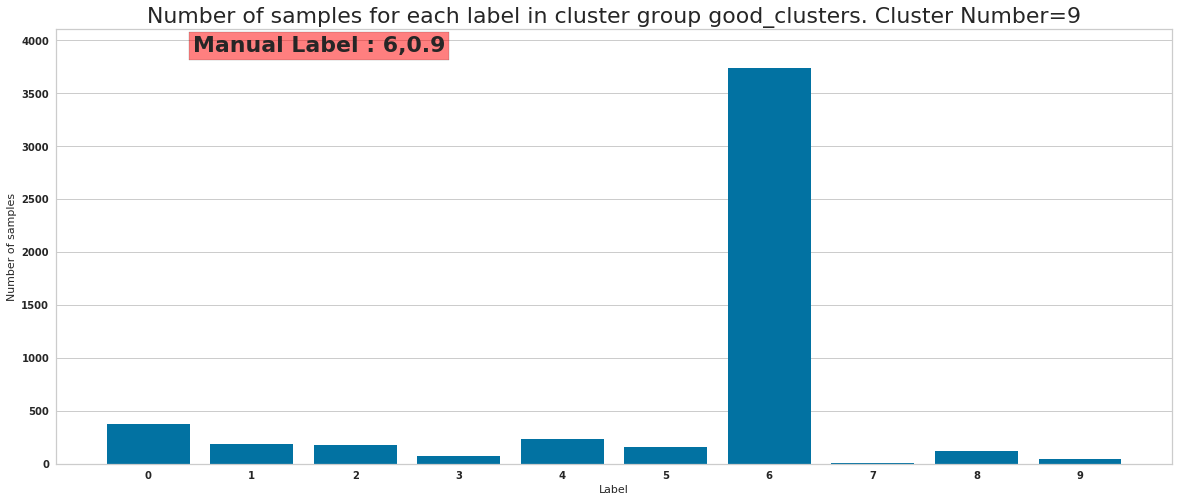

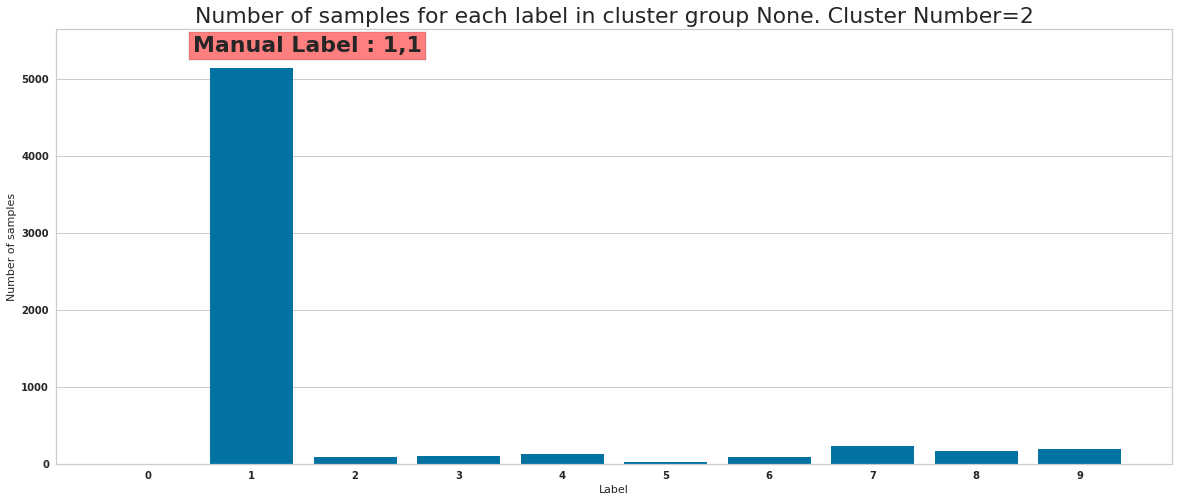

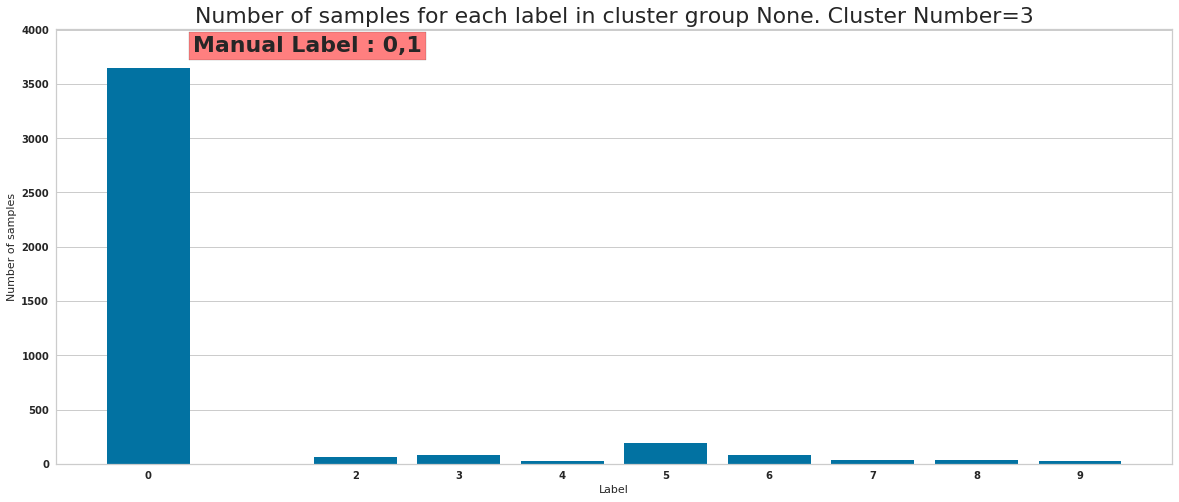

In [24]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

# For each sample, compute distance from respective cluster center

In [25]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(5300, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(6236, 10)
(6179, 10)
(4185, 10)
(6671, 10)
(6387, 10)
(7733, 10)
(4971, 10)
(7061, 10)
(5117, 10)


0
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


5
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


6
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


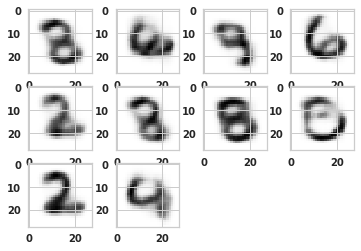

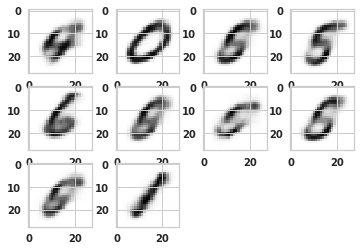

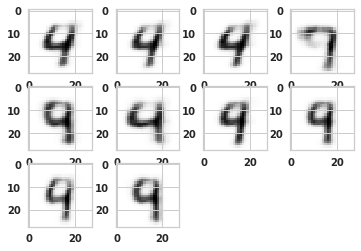

In [26]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [27]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1, -1, -1 , 6,
                                        -1, -1, 8, -1,
                                         2, -1]
level_2_cluster_dict["manual_confidences"] = [0, 0, 0, 0.7,
                                              0, 0, 0.6, 0,
                                              0.6, 0]
level2_manual_annotations[0] = level_2_cluster_dict


level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1, 0, -1,-1,
                                        6, -1, -1, -1,
                                        -1, -1]
level_2_cluster_dict["manual_confidences"] = [0, 0.9, 0, 0,
                                              0.6, 0, 0, 0,
                                              0, 0
                                             ]

level2_manual_annotations[5] = level_2_cluster_dict


level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [4, 4, 4, 7,
                                        9, 4, -1, 9,
                                        -1, 9]
level_2_cluster_dict["manual_confidences"] = [0.7, 0.7, 0.7, 0.7,
                                              0.7, 0.7, 0, 0.7,
                                              0, 0.8
                                             ]
level2_manual_annotations[6] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1, 1, -1,
#                                         -1, -1, -1, 1,
#                                         -1, 1]
# level_2_cluster_dict["manual_confidences"] = [0,0,0,0,
#                                               0,0,0,0,
#                                               0,0
#                                              ]

# level2_manual_annotations[4] = level_2_cluster_dict



In [28]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

0
5
6


In [29]:
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

10
Skipping distance computation for unknown cluster
3 (658,)
6 (518,)
8 (513,)
10
Skipping distance computation for unknown cluster
1 (510,)
4 (666,)
10
0 (687,)
1 (793,)
2 (731,)
3 (756,)
4 (749,)
5 (815,)
7 (802,)
9 (826,)
Skipping distance computation for unknown cluster


In [30]:
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster

In [32]:
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)

In [33]:
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [34]:
def assign_manual_label_and_confidence(df,
                                       manual_annotation_dict,
                                       dist_to_conf,
                                       cluster_group_dict,
                                       cluster_column_name_2,
                                       assign_only_correct=False
                                       ):
    def assign_label(_df, _manual_label):
        _indices = np.where((np.asarray(cluster_labels) == cluster.id)
                            & (_df[cluster_column_name_2].values == _cluster.id))[0]
        _df["manual_annotation"].iloc[_indices] = _manual_label
        dst = _distance_df.iloc[_indices]
        _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * dist_to_conf(dst)
        _df["distance_to_confidence"].iloc[_indices] = dist_to_conf(dst)
        if assign_only_correct:
            wrong_indices = (_df["manual_annotation"] == _manual_label) & (_df["label"] != _manual_label)
            _df["manual_annotation_confidence"].loc[wrong_indices] = 0

    df["manual_annotation"] = np.ones(df.shape[0]) * -1
    df["manual_annotation_confidence"] = np.zeros(df.shape[0])
    df["distance_to_confidence"] = np.zeros(df.shape[0])
    # manually given label for each cluster center -1 for unknown (cluster which has no semantic meaning)
    manual_labels = manual_annotation_dict["manual_labels"]
    cluster_labels = np.asarray(manual_annotation_dict["cluster_labels"])

    num_clusters = len(manual_labels)
    for annotate_cluster in range(num_clusters):
        distance_df = df["distance_{}".format(annotate_cluster)]
        manual_label = manual_labels[annotate_cluster]
        _manual_confidence = manual_annotation_dict["manual_confidence"][annotate_cluster]
        if isinstance(manual_label, tuple) or isinstance(manual_label, list):
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            for _cluster in cluster.next_level_clusters["good_clusters"]:
                _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                _manual_label = _cluster.manual_annotation.label
                if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                    # TODO add this code
                    pass
                elif _manual_label != -1:
                    assign_label(df, _manual_label)
        elif manual_label != -1:
            print("Manual Label", manual_label)
            indices = np.where(cluster_labels == annotate_cluster)

            df["manual_annotation"].iloc[indices] = manual_label
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(df[df["manual_annotation"] == manual_label].shape, cluster.details["cluster_data_frame"].shape)
            num_correct = df[(manual_label == df["manual_annotation"]) & (df["label"] == manual_label)].shape[0]
            print("Num correct={}".format(num_correct))

            percentage_correct = 100 * num_correct / df[df["manual_annotation"] == manual_label].shape[0]
            print(f"Cluster {annotate_cluster} Manual Label {manual_label} Percentage correct {percentage_correct}")
            dist = distance_df.iloc[indices]
            df["manual_annotation_confidence"].iloc[indices] = _manual_confidence * dist_to_conf(dist)
            if assign_only_correct:
                wrong_indices = (df["manual_annotation"] == manual_label) & (df["label"] != manual_label)
                print(len(wrong_indices), wrong_indices.shape)
                df["manual_annotation_confidence"].loc[wrong_indices] = 0
            df["distance_to_confidence"].iloc[indices] = dist_to_conf(dist)
        else:
            print("unknown")
            # TODO second level clustering is not used now so commenting the code
            # unknown, check if second level clustering is done or not
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(type(cluster.next_level_clusters))
            print(list(cluster.next_level_clusters.keys()))

            for cluster_group_name, cluster_group in cluster.next_level_clusters.items():
                for _cluster in cluster_group:
                    _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                    _manual_label = _cluster.manual_annotation.label
                    print(f"********{_manual_label}*******")
                    if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                        # TODO add this code
                        pass
                    elif _manual_label != -1:
                        print("Manual_label", _manual_label)
                        assign_label(df, _manual_label)
                    else:
                        # Manual label is -1
                        # Label all the 600 samples in the second level cluster
                        indices = np.where((np.asarray(cluster_labels) == cluster.id)
                                           & (df[cluster_column_name_2].values == _cluster.id))[0]
                        print(f"Annotating individual samples {indices.shape}")
                        df["manual_annotation"].iloc[indices] = df["label"][indices].values
                        df["manual_annotation_confidence"].iloc[indices] = 1

                        _dist = _distance_df.iloc[indices]
                        df["distance_to_confidence"].iloc[indices] = dist_to_conf(_dist)

        print("********************************")


In [35]:
assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False
                                  )

unknown
<class 'dict'>
['unknown_cluster', 'good_clusters', 'average_clusters']
********-1*******
Annotating individual samples (526,)
********-1*******
Annotating individual samples (481,)
********-1*******
Annotating individual samples (481,)
********-1*******
Annotating individual samples (559,)
********-1*******
Annotating individual samples (520,)
********-1*******
Annotating individual samples (524,)
********-1*******
Annotating individual samples (520,)
********6*******
Manual_label 6
********8*******
Manual_label 8
********2*******
Manual_label 2
********************************
Manual Label 3
(6802, 77) (6236, 33)
Num correct=4267
Cluster 1 Manual Label 3 Percentage correct 62.73154954425169
********************************
Manual Label 1
(6216, 77) (6179, 33)
Num correct=5176
Cluster 2 Manual Label 1 Percentage correct 83.26898326898326
********************************
Manual Label 0
(4464, 77) (4185, 33)
Num correct=3922
Cluster 3 Manual Label 0 Percentage correct 87.8584229

# Save the dataframe with manual annotations

In [36]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([5300., 6236., 6179., 4185., 6671., 6387., 7733., 4971., 7061.,
        5117.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

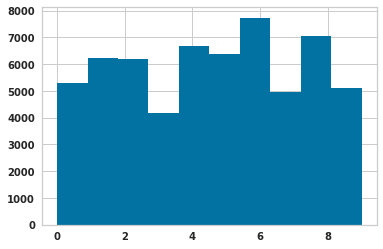

In [37]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

In [38]:
from clearn.analysis.cluster_utils import plot_distance_distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


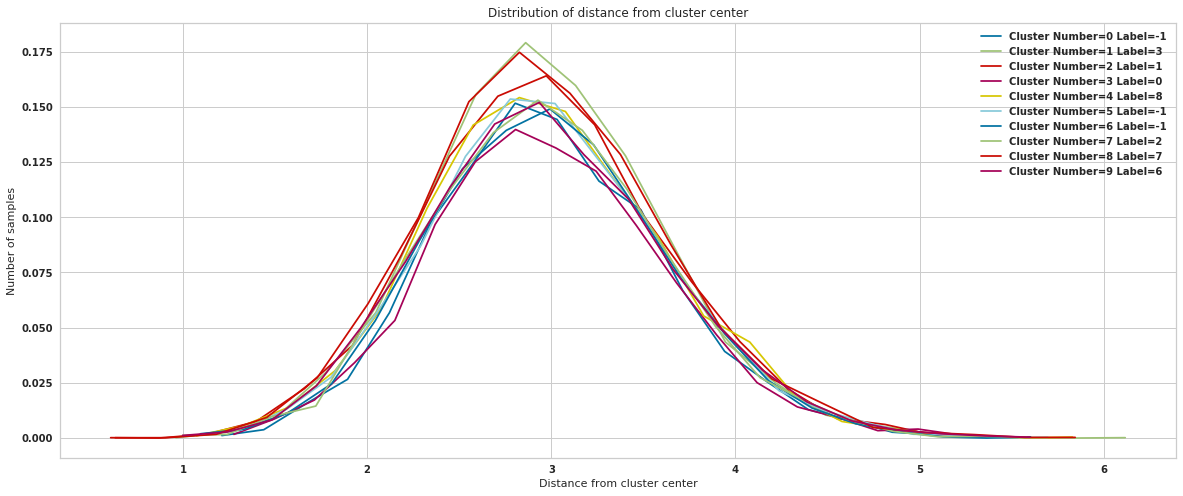

In [39]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

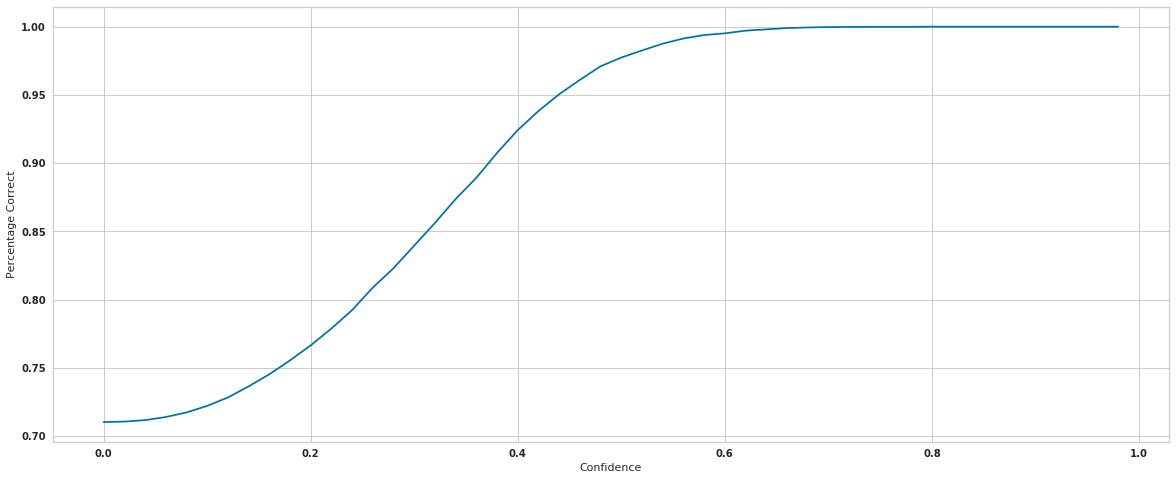

In [40]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

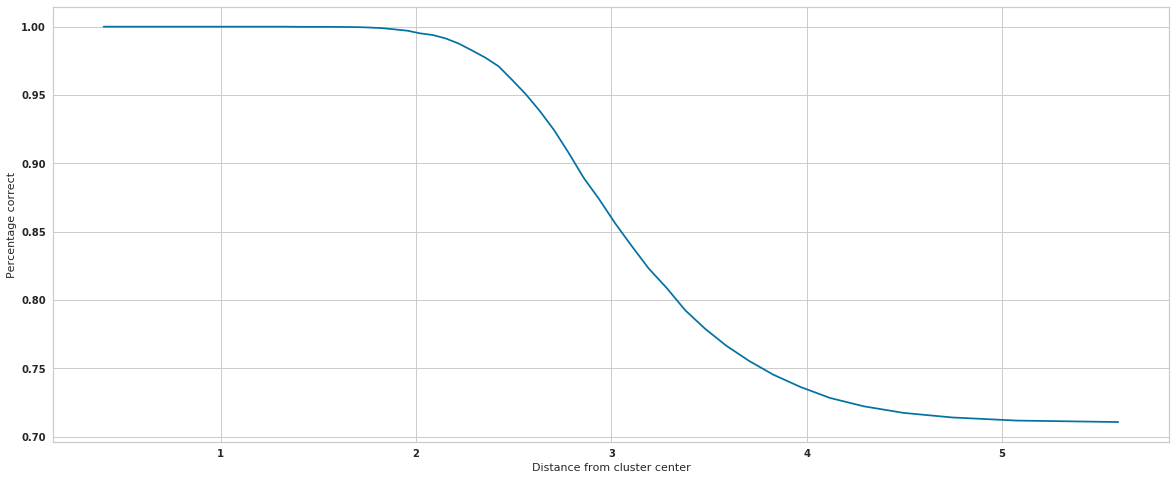

In [41]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [42]:
from shutil import copy2

In [43]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging 
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

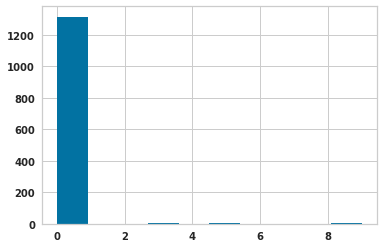

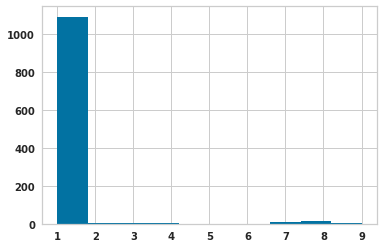

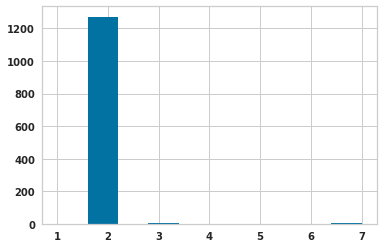

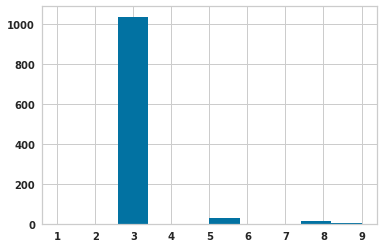

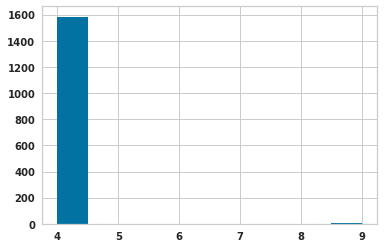

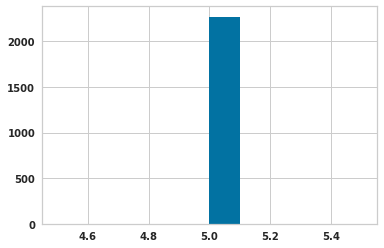

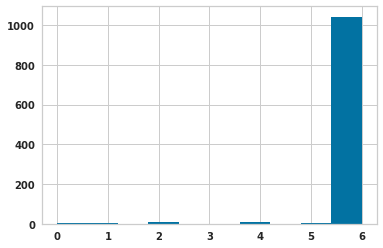

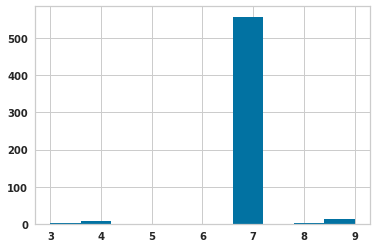

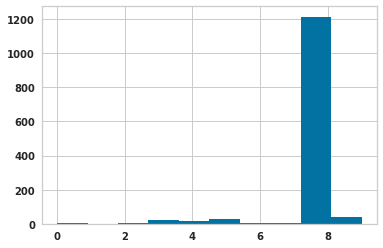

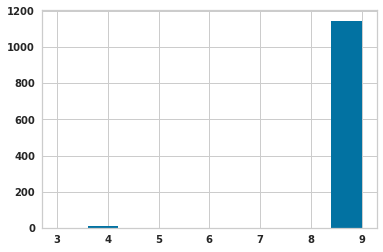

In [44]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [45]:
df.columns

Index(['label', 'label_predicted', 'mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4',
       'mu_5', 'mu_6', 'mu_7', 'mu_8', 'mu_9', 'sigma_0', 'sigma_1', 'sigma_2',
       'sigma_3', 'sigma_4', 'sigma_5', 'sigma_6', 'sigma_7', 'sigma_8',
       'sigma_9', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7',
       'z_8', 'z_9', 'cluster_level_1', 'distance_0', 'distance_1',
       'distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6',
       'distance_7', 'distance_8', 'distance_9', 'cluster_level_2',
       'distance_level_2_0_0', 'distance_level_2_0_1', 'distance_level_2_0_2',
       'distance_level_2_0_3', 'distance_level_2_0_4', 'distance_level_2_0_5',
       'distance_level_2_0_6', 'distance_level_2_0_7', 'distance_level_2_0_8',
       'distance_level_2_0_9', 'distance_level_2_5_0', 'distance_level_2_5_1',
       'distance_level_2_5_2', 'distance_level_2_5_3', 'distance_level_2_5_4',
       'distance_level_2_5_5', 'distance_level_2_5_6', 'distance_level_2_5_7',
       'dis

# Iteration 2

In [46]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 23520.232496386834
INFO:tensorflow:Summary name Negative Log Likel

Epoch: 1/67, Nll_loss : 126.58625793457031 KLD:8.614226341247559  Supervised loss:0.48744380474090576
Epoch: 1/68, Nll_loss : 130.30946350097656 KLD:8.328202247619629  Supervised loss:0.565517783164978
Epoch: 1/69, Nll_loss : 139.7249755859375 KLD:8.92007064819336  Supervised loss:0.5193654298782349
Epoch: 1/70, Nll_loss : 143.62791442871094 KLD:9.214080810546875  Supervised loss:0.5155041813850403
Epoch: 1/71, Nll_loss : 134.68731689453125 KLD:9.257965087890625  Supervised loss:0.6071167588233948
Epoch: 1/72, Nll_loss : 137.90476989746094 KLD:9.56254768371582  Supervised loss:0.510718822479248
Epoch: 1/73, Nll_loss : 142.13040161132812 KLD:9.687299728393555  Supervised loss:0.4315009117126465
Epoch: 1/74, Nll_loss : 134.71023559570312 KLD:9.368314743041992  Supervised loss:0.6072757244110107
Epoch: 1/75, Nll_loss : 143.7612762451172 KLD:9.599154472351074  Supervised loss:0.4571932852268219
Epoch: 1/76, Nll_loss : 134.94924926757812 KLD:9.309282302856445  Supervised loss:0.471048593521

Epoch: 1/148, Nll_loss : 138.0614013671875 KLD:9.219372749328613  Supervised loss:0.3455543518066406
Epoch: 1/149, Nll_loss : 145.31210327148438 KLD:8.954309463500977  Supervised loss:0.3589108884334564
Epoch: 1/150, Nll_loss : 135.92239379882812 KLD:8.195021629333496  Supervised loss:0.37746572494506836
Epoch: 1/151, Nll_loss : 140.40576171875 KLD:8.764591217041016  Supervised loss:0.5124318599700928
Epoch: 1/152, Nll_loss : 133.57037353515625 KLD:8.365867614746094  Supervised loss:0.34972089529037476
Epoch: 1/153, Nll_loss : 137.07244873046875 KLD:8.077510833740234  Supervised loss:0.39889970421791077
Epoch: 1/154, Nll_loss : 130.53746032714844 KLD:8.88758659362793  Supervised loss:0.28558626770973206
Epoch: 1/155, Nll_loss : 141.48265075683594 KLD:9.086181640625  Supervised loss:0.4932405650615692
Epoch: 1/156, Nll_loss : 140.326416015625 KLD:9.515666007995605  Supervised loss:0.41988468170166016
Epoch: 1/157, Nll_loss : 135.82415771484375 KLD:9.712529182434082  Supervised loss:0.40

Epoch: 1/229, Nll_loss : 136.03997802734375 KLD:9.241415023803711  Supervised loss:0.4162551760673523
Epoch: 1/230, Nll_loss : 130.79763793945312 KLD:9.66684341430664  Supervised loss:0.4120904207229614
Epoch: 1/231, Nll_loss : 135.63192749023438 KLD:9.555225372314453  Supervised loss:0.376259446144104
Epoch: 1/232, Nll_loss : 136.395263671875 KLD:9.388358116149902  Supervised loss:0.47705280780792236
Epoch: 1/233, Nll_loss : 127.10655212402344 KLD:9.88467025756836  Supervised loss:0.2218056470155716
Epoch: 1/234, Nll_loss : 131.51986694335938 KLD:10.521632194519043  Supervised loss:0.2711515426635742
Epoch: 1/235, Nll_loss : 132.143310546875 KLD:9.942054748535156  Supervised loss:0.3615635931491852
Epoch: 1/236, Nll_loss : 131.00527954101562 KLD:10.081098556518555  Supervised loss:0.43226248025894165
Epoch: 1/237, Nll_loss : 130.34860229492188 KLD:9.514158248901367  Supervised loss:0.2929239273071289
Epoch: 1/238, Nll_loss : 139.2732696533203 KLD:8.764283180236816  Supervised loss:0.2

Epoch: 1/310, Nll_loss : 123.63291931152344 KLD:9.230026245117188  Supervised loss:0.42923593521118164
Epoch: 1/311, Nll_loss : 139.560302734375 KLD:9.346617698669434  Supervised loss:0.4511606693267822
Epoch: 1/312, Nll_loss : 139.86476135253906 KLD:9.5173978805542  Supervised loss:0.34572863578796387
Epoch: 1/313, Nll_loss : 135.53489685058594 KLD:9.839776992797852  Supervised loss:0.33015957474708557
Epoch: 1/314, Nll_loss : 133.9133758544922 KLD:9.304649353027344  Supervised loss:0.2925887703895569
Epoch: 1/315, Nll_loss : 123.6568374633789 KLD:9.285531997680664  Supervised loss:0.3971668481826782
Epoch: 1/316, Nll_loss : 125.8391342163086 KLD:9.335470199584961  Supervised loss:0.33761224150657654
Epoch: 1/317, Nll_loss : 130.57144165039062 KLD:8.965169906616211  Supervised loss:0.3356308341026306
Epoch: 1/318, Nll_loss : 127.40557861328125 KLD:8.703140258789062  Supervised loss:0.3132227659225464
Epoch: 1/319, Nll_loss : 122.35711669921875 KLD:9.014759063720703  Supervised loss:0.

Epoch: 1/393, Nll_loss : 129.00393676757812 KLD:9.297165870666504  Supervised loss:0.3003804683685303
Epoch: 1/394, Nll_loss : 134.22500610351562 KLD:9.859186172485352  Supervised loss:0.29737943410873413
Epoch: 1/395, Nll_loss : 129.88316345214844 KLD:9.652121543884277  Supervised loss:0.3172704577445984
Epoch: 1/396, Nll_loss : 125.13741302490234 KLD:9.593165397644043  Supervised loss:0.31316205859184265
Epoch: 1/397, Nll_loss : 125.63323974609375 KLD:10.509407043457031  Supervised loss:0.348617285490036
Epoch: 1/398, Nll_loss : 119.17938232421875 KLD:10.045150756835938  Supervised loss:0.3396458625793457
Epoch: 1/399, Nll_loss : 133.41482543945312 KLD:10.542238235473633  Supervised loss:0.2798987030982971
Epoch: 1/400, Nll_loss : 128.41319274902344 KLD:10.5933198928833  Supervised loss:0.30278825759887695
Epoch: 1/401, Nll_loss : 128.37530517578125 KLD:9.412237167358398  Supervised loss:0.31256645917892456
Epoch: 1/402, Nll_loss : 122.53233337402344 KLD:9.31959056854248  Supervised 

Epoch: 1/476, Nll_loss : 132.5849151611328 KLD:8.729133605957031  Supervised loss:0.3751152753829956
Epoch: 1/477, Nll_loss : 130.5177001953125 KLD:9.029611587524414  Supervised loss:0.4105178117752075
Epoch: 1/478, Nll_loss : 128.54891967773438 KLD:9.062700271606445  Supervised loss:0.30140966176986694
Epoch: 1/479, Nll_loss : 126.87498474121094 KLD:9.192316055297852  Supervised loss:0.35341179370880127
Epoch: 1/480, Nll_loss : 134.85855102539062 KLD:9.534236907958984  Supervised loss:0.2480568289756775
Epoch: 1/481, Nll_loss : 125.24012756347656 KLD:9.708719253540039  Supervised loss:0.30414342880249023
Epoch: 1/482, Nll_loss : 129.57354736328125 KLD:9.639120101928711  Supervised loss:0.33891743421554565
Epoch: 1/483, Nll_loss : 126.905029296875 KLD:10.005766868591309  Supervised loss:0.3151854872703552
Epoch: 1/484, Nll_loss : 130.18833923339844 KLD:9.579609870910645  Supervised loss:0.3111386299133301
Epoch: 1/485, Nll_loss : 130.71334838867188 KLD:9.290311813354492  Supervised los

Epoch: 1/559, Nll_loss : 123.62738037109375 KLD:8.949702262878418  Supervised loss:0.330322802066803
Epoch: 1/560, Nll_loss : 126.30177307128906 KLD:9.523017883300781  Supervised loss:0.2439449578523636
Epoch: 1/561, Nll_loss : 121.03014373779297 KLD:9.164796829223633  Supervised loss:0.24262693524360657
Epoch: 1/562, Nll_loss : 121.87779235839844 KLD:9.33867073059082  Supervised loss:0.31517601013183594
Epoch: 1/563, Nll_loss : 125.7806396484375 KLD:9.199479103088379  Supervised loss:0.44844916462898254
Epoch: 1/564, Nll_loss : 128.9050750732422 KLD:9.548871994018555  Supervised loss:0.2772582173347473
Epoch: 1/565, Nll_loss : 125.28424072265625 KLD:9.818404197692871  Supervised loss:0.2869104743003845
Epoch: 1/566, Nll_loss : 115.85926818847656 KLD:9.896749496459961  Supervised loss:0.2464316189289093
Epoch: 1/567, Nll_loss : 127.12520599365234 KLD:9.523502349853516  Supervised loss:0.3387147784233093
Epoch: 1/568, Nll_loss : 125.4968032836914 KLD:9.171048164367676  Supervised loss:0

Epoch: 1/642, Nll_loss : 125.06798553466797 KLD:9.57136344909668  Supervised loss:0.2769204378128052
Epoch: 1/643, Nll_loss : 139.97317504882812 KLD:9.952254295349121  Supervised loss:0.3434399664402008
Epoch: 1/644, Nll_loss : 129.83518981933594 KLD:9.92866039276123  Supervised loss:0.31436917185783386
Epoch: 1/645, Nll_loss : 125.85159301757812 KLD:9.515104293823242  Supervised loss:0.2974688708782196
Epoch: 1/646, Nll_loss : 119.04835510253906 KLD:9.40706729888916  Supervised loss:0.2154906839132309
Epoch: 1/647, Nll_loss : 129.49273681640625 KLD:8.922685623168945  Supervised loss:0.2976919412612915
Epoch: 1/648, Nll_loss : 129.16119384765625 KLD:8.841943740844727  Supervised loss:0.31604036688804626
Epoch: 1/649, Nll_loss : 127.59675598144531 KLD:9.237174987792969  Supervised loss:0.2959885597229004
Epoch: 1/650, Nll_loss : 128.2037353515625 KLD:9.122505187988281  Supervised loss:0.2692796289920807
Epoch: 1/651, Nll_loss : 121.87503051757812 KLD:8.705719947814941  Supervised loss:0

Epoch: 1/723, Nll_loss : 118.91773986816406 KLD:9.701794624328613  Supervised loss:0.21080201864242554
Epoch: 1/724, Nll_loss : 126.52842712402344 KLD:9.950435638427734  Supervised loss:0.28989583253860474
Epoch: 1/725, Nll_loss : 132.50894165039062 KLD:9.582660675048828  Supervised loss:0.2599472105503082
Epoch: 1/726, Nll_loss : 125.68666076660156 KLD:9.589739799499512  Supervised loss:0.34897923469543457
Epoch: 1/727, Nll_loss : 123.017333984375 KLD:9.366354942321777  Supervised loss:0.280171662569046
Epoch: 1/728, Nll_loss : 124.29930114746094 KLD:9.174922943115234  Supervised loss:0.3035961985588074
Epoch: 1/729, Nll_loss : 122.02763366699219 KLD:9.295206069946289  Supervised loss:0.2432519793510437
Epoch: 1/730, Nll_loss : 118.52847290039062 KLD:8.478511810302734  Supervised loss:0.32687824964523315
Epoch: 1/731, Nll_loss : 122.99920654296875 KLD:8.806068420410156  Supervised loss:0.27500638365745544
Epoch: 1/732, Nll_loss : 116.81640625 KLD:8.733922958374023  Supervised loss:0.3

Epoch: 1/804, Nll_loss : 118.74623107910156 KLD:9.395844459533691  Supervised loss:0.237767294049263
Epoch: 1/805, Nll_loss : 123.01980590820312 KLD:10.28184700012207  Supervised loss:0.21714699268341064
Epoch: 1/806, Nll_loss : 128.36334228515625 KLD:10.04774284362793  Supervised loss:0.33369144797325134
Epoch: 1/807, Nll_loss : 117.75889587402344 KLD:10.790124893188477  Supervised loss:0.1986905038356781
Epoch: 1/808, Nll_loss : 119.17237854003906 KLD:9.894282341003418  Supervised loss:0.33563897013664246
Epoch: 1/809, Nll_loss : 118.46188354492188 KLD:9.993846893310547  Supervised loss:0.26383352279663086
Epoch: 1/810, Nll_loss : 123.5716552734375 KLD:9.98462963104248  Supervised loss:0.2509846091270447
Epoch: 1/811, Nll_loss : 124.22135925292969 KLD:10.061593055725098  Supervised loss:0.2727794349193573
Epoch: 1/812, Nll_loss : 126.62554931640625 KLD:9.43862533569336  Supervised loss:0.22772370278835297
Epoch: 1/813, Nll_loss : 120.16352844238281 KLD:9.747739791870117  Supervised l

Epoch: 1/885, Nll_loss : 127.60945892333984 KLD:9.658468246459961  Supervised loss:0.34688863158226013
Epoch: 1/886, Nll_loss : 121.85701751708984 KLD:9.199512481689453  Supervised loss:0.2276516854763031
Epoch: 1/887, Nll_loss : 125.02792358398438 KLD:9.509824752807617  Supervised loss:0.42989423871040344
Epoch: 1/888, Nll_loss : 127.26004028320312 KLD:9.143503189086914  Supervised loss:0.2548208236694336
Epoch: 1/889, Nll_loss : 114.27861022949219 KLD:8.969575881958008  Supervised loss:0.2356886863708496
Epoch: 1/890, Nll_loss : 122.05171203613281 KLD:9.123275756835938  Supervised loss:0.23097559809684753
Epoch: 1/891, Nll_loss : 129.89657592773438 KLD:9.068889617919922  Supervised loss:0.19703234732151031
Epoch: 1/892, Nll_loss : 131.72711181640625 KLD:9.493206024169922  Supervised loss:0.382327139377594
Epoch: 1/893, Nll_loss : 124.349853515625 KLD:9.41295051574707  Supervised loss:0.24091191589832306
Epoch: 1/894, Nll_loss : 114.32576751708984 KLD:9.027034759521484  Supervised los

In [47]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS
Number of steps completed=1870
Number of epochs completed 2.0


In [48]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=45 z_min=-4.534314599999999 z_max=4.398792
Latent vectors shape (59840, 10)


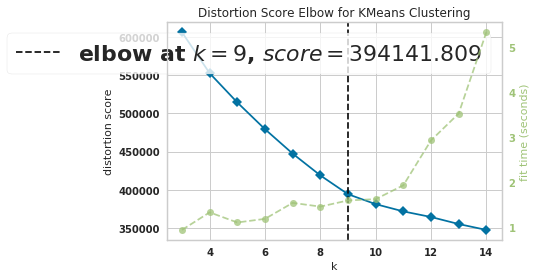

In [49]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS


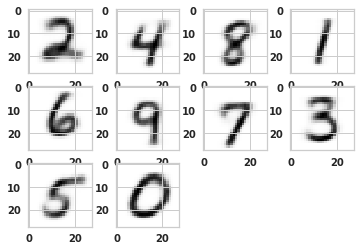

In [50]:
num_clusters = 10
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
tf.reset_default_graph()
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [52]:
import json
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [2, 4, 8, 1,
                                           6, 9, 7, 3,
                                           5, 0
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.8,1,1,
                                               1, 0.9, 0.9, 0.9,
                                               0.8, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [53]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

In [54]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

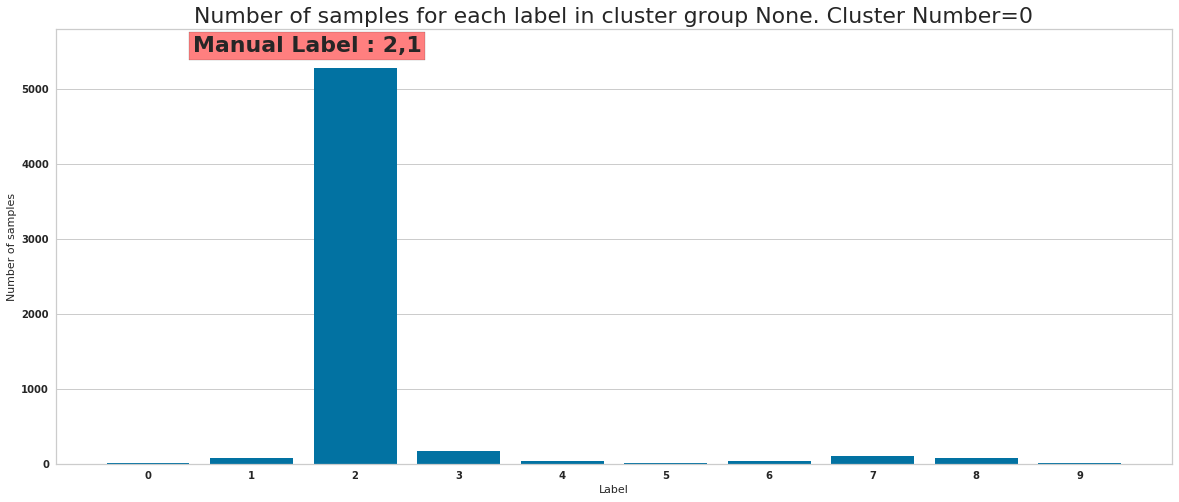

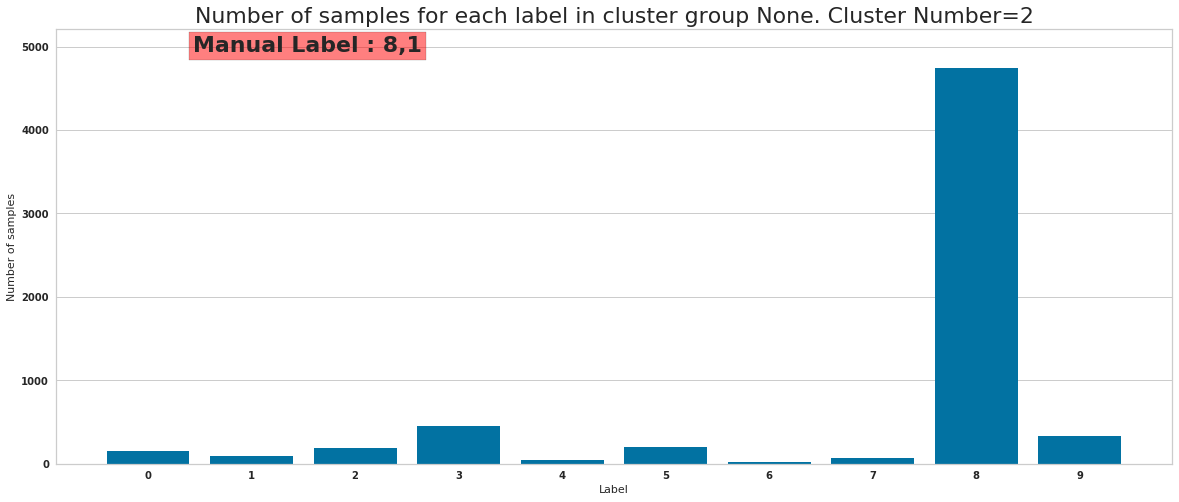

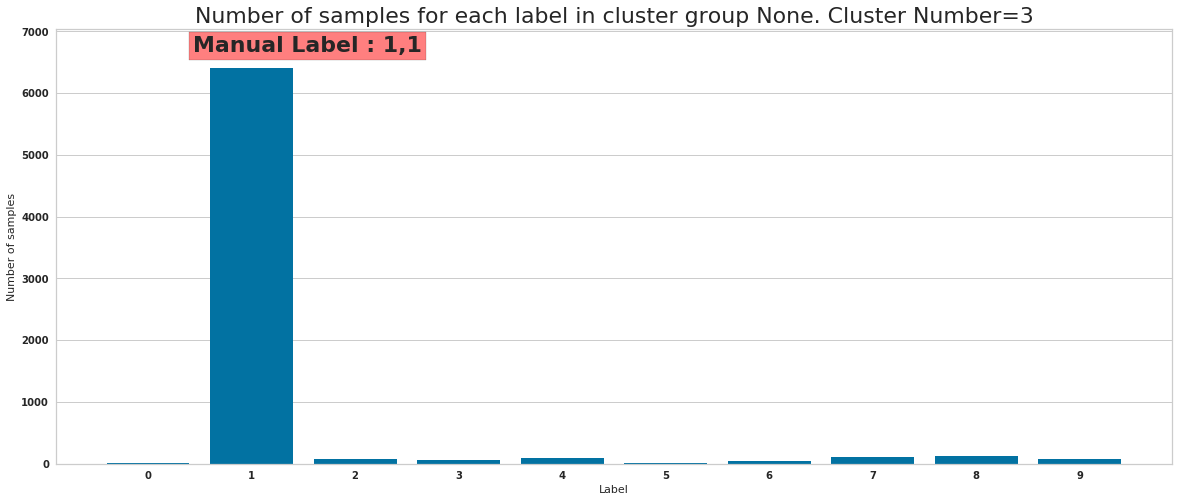

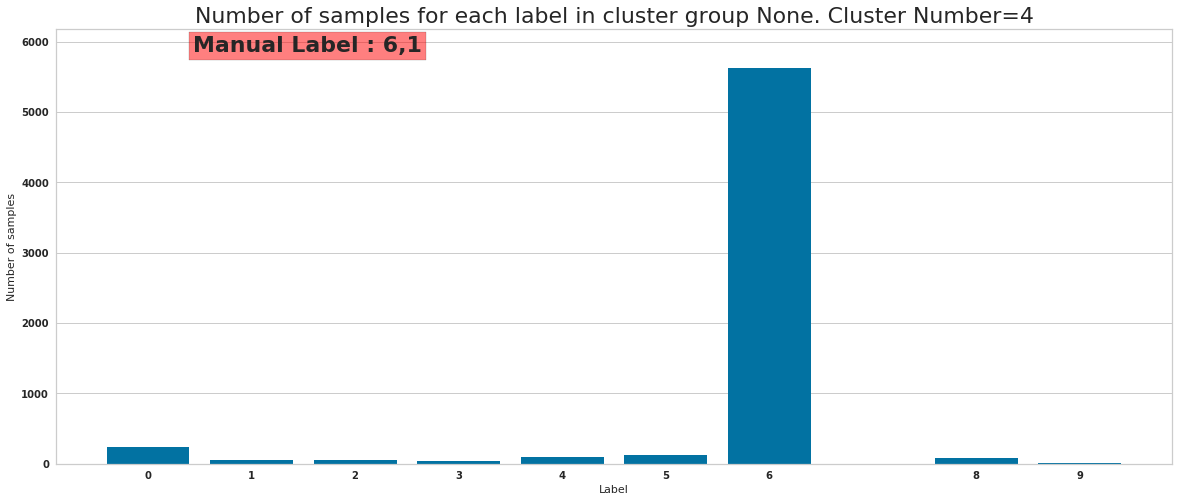

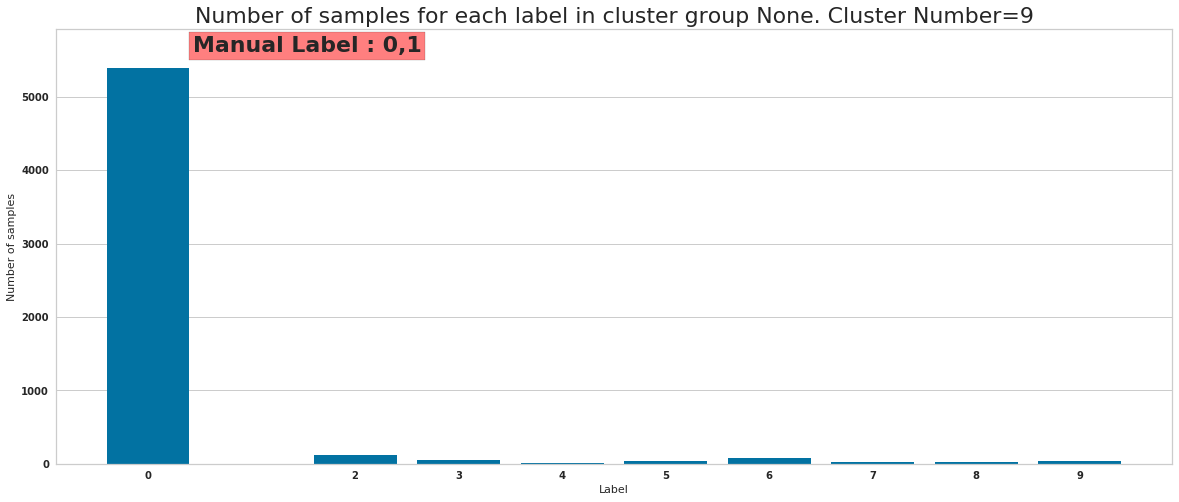

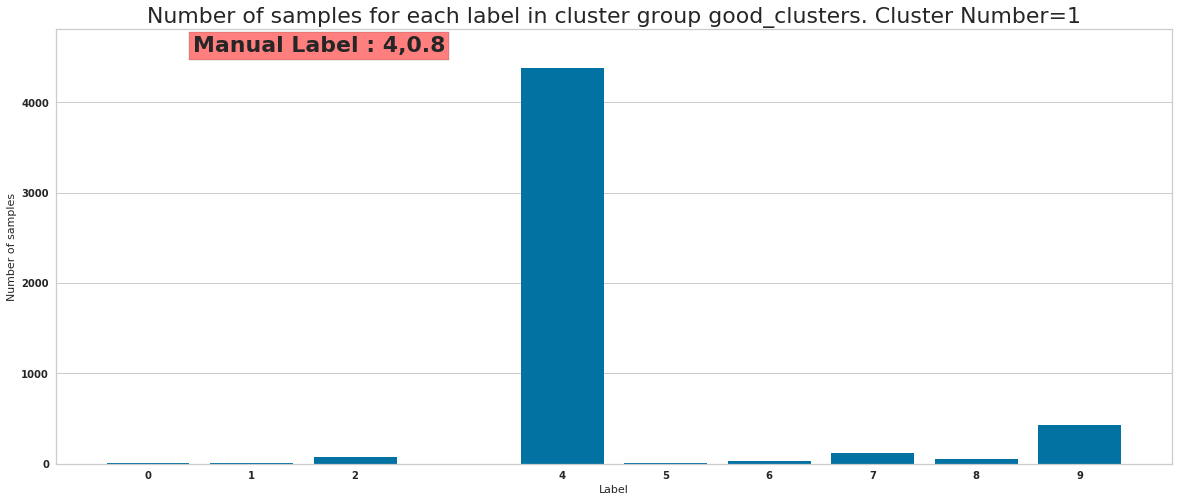

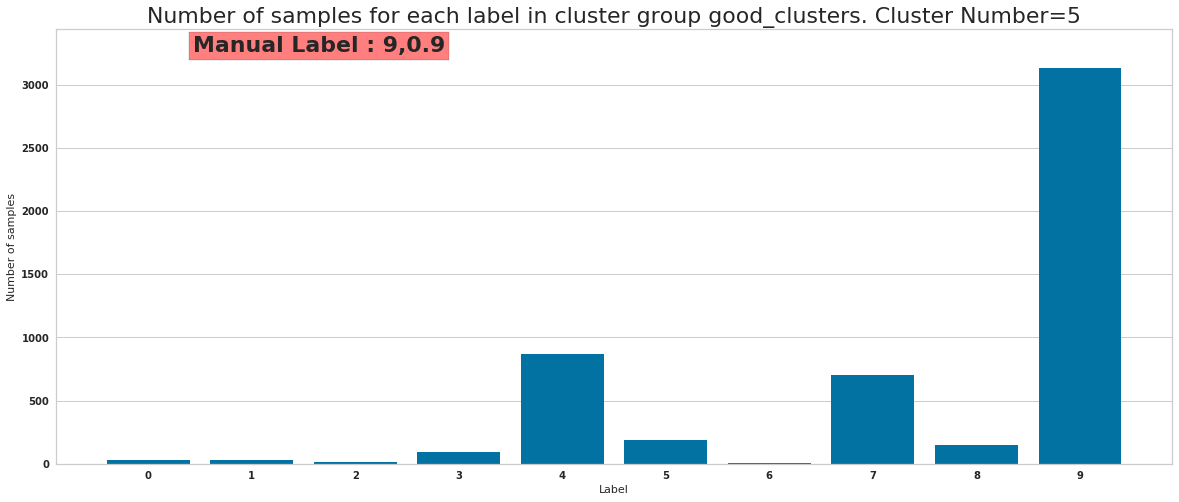

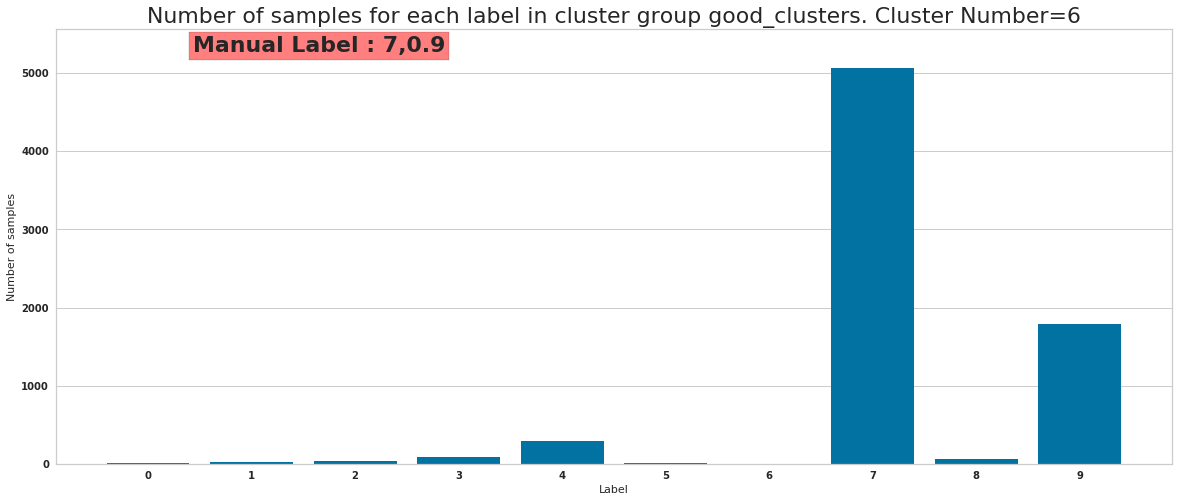

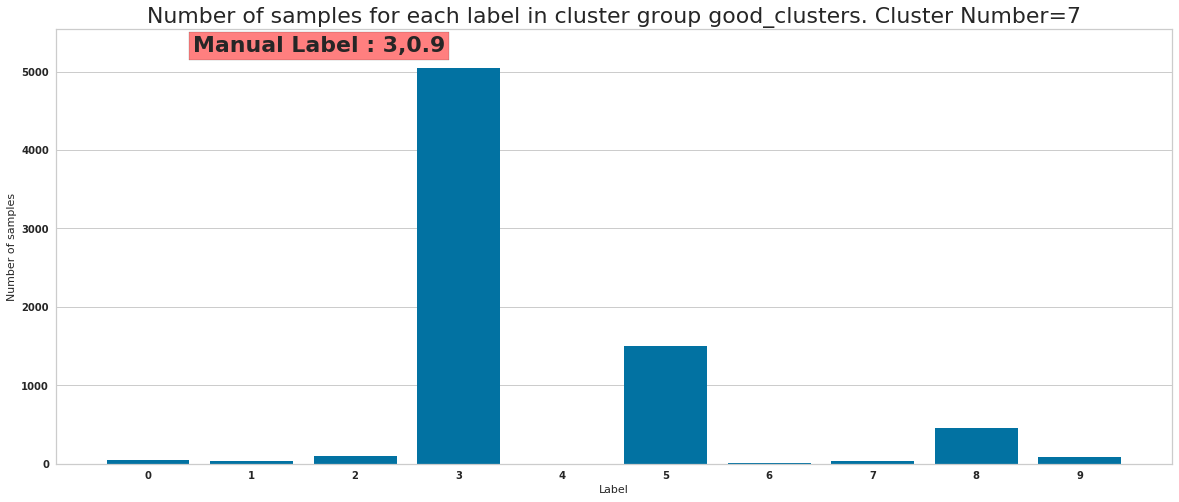

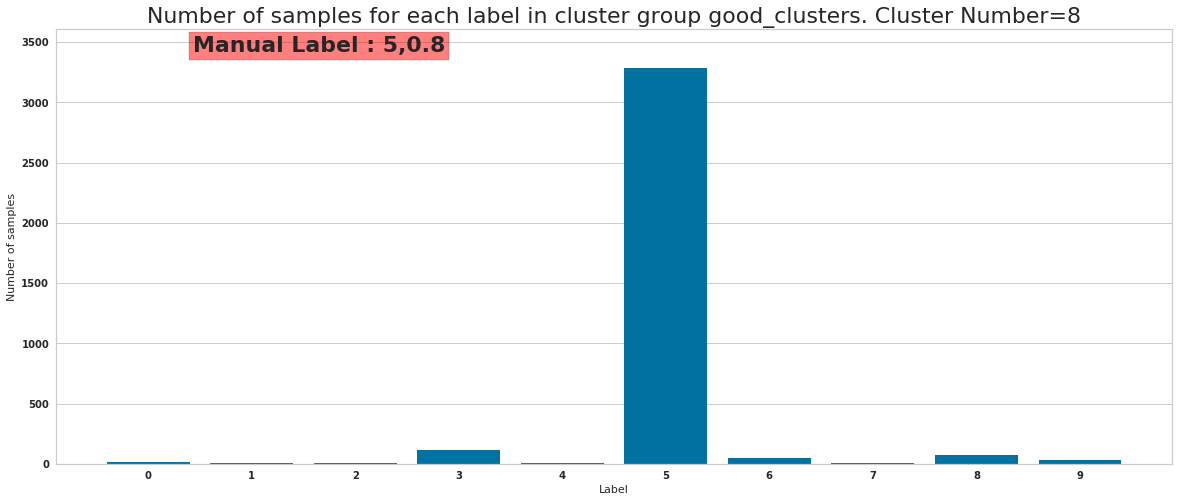

In [55]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [56]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(5803, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5119, 10)
(6300, 10)
(7024, 10)
(6327, 10)
(5212, 10)
(7369, 10)
(7314, 10)
(3591, 10)
(5781, 10)


In [57]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [58]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,3,0,5,
#                                         -1,5,-1,-1,
#                                         -1,8]
# level_2_cluster_dict["manual_confidences"] = [0,0.7,0.9,0.6,
#                                              0,0.6,0,0,
#                                              0, 0.7]
# level2_manual_annotations[0] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,5,-1,-1,
#                                         -1,5,8,-1,
#                                         -1,-1]
# level_2_cluster_dict["manual_confidences"] = [1,0.6,0,0,
#                                              0,0.6,0.6,0,
#                                              0,0]
# level2_manual_annotations[7] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,9,9,9,
#                                         4,9,9,9,
#                                         4,9]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.9,0.9,0.9,
#                                               0.8,0.9,0.9,0.9,
#                                               0.8,0.9
#                                              ]
# level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [0, -1]
# level_2_cluster_dict["manual_confidences"] = [0.7, 0]
# level2_manual_annotations[14] = level_2_cluster_dict



In [60]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)
    
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 2
(5803, 47) (5803, 33)
Num correct=5268
Cluster 0 Manual Label 2 Percentage correct 90.78063070825435
********************************
Manual Label 4
(5119, 47) (5119, 33)
Num correct=4376
Cluster 1 Manual Label 4 Percentage correct 85.48544637624536
********************************
Manual Label 8
(6300, 47) (6300, 33)
Num correct=4737
Cluster 2 Manual Label 8 Percentage correct 75.19047619047619
********************************
Manual Label 1
(7024, 47) (7024, 33)
Num correct=6398
Cluster 3 Manual Label 1 Percentage correct 91.0876993166287
********************************
Manual Label 6
(6327, 47) (6327, 33)
Num correct=5619
Cluster 4 Manual Label 6 Percentage correct 88.80986249407302
********************************
Manual Label 9
(5212, 47) (5212, 33)
Num correct=3127
Cluster 5 Manual Label 9 Percentage correct 59.996162701458175
********************************
Manual Label 7
(7369, 47) (7369, 33)
Num correct=5059
Cluster 6 Manual Label 7 Percentage correct 68.65246

In [61]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([5803., 5119., 6300., 7024., 6327., 5212., 7369., 7314., 3591.,
        5781.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

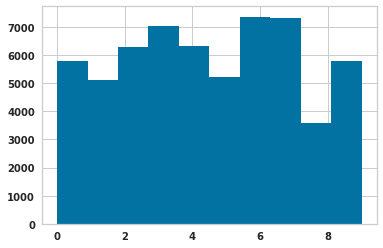

In [62]:
plt.hist(cluster_labels)

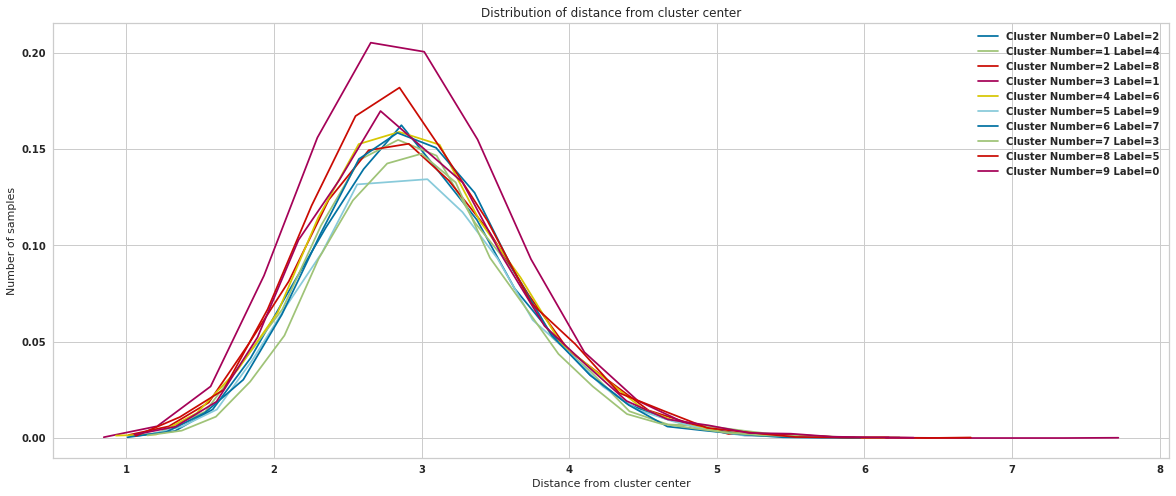

In [63]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

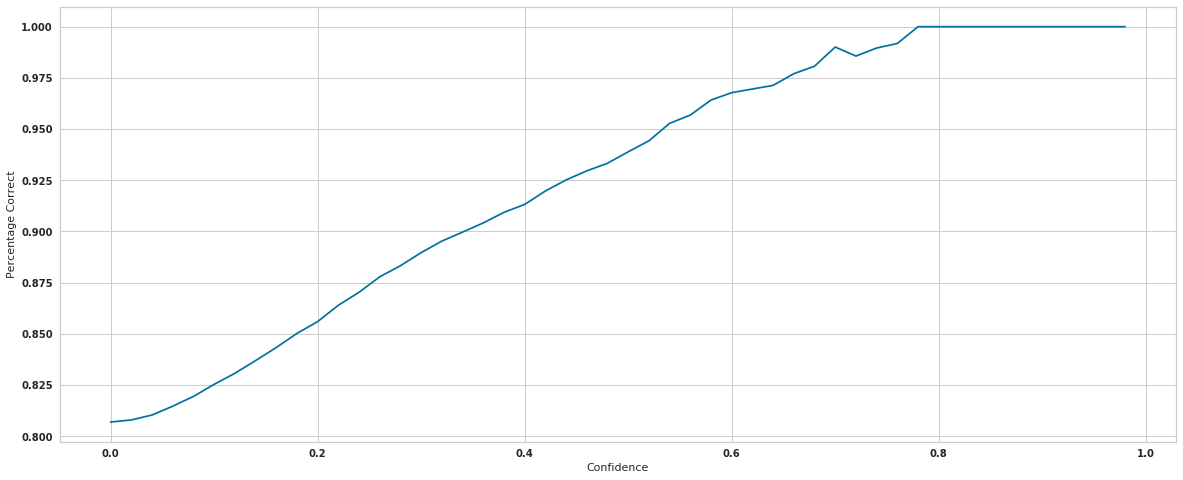

In [64]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

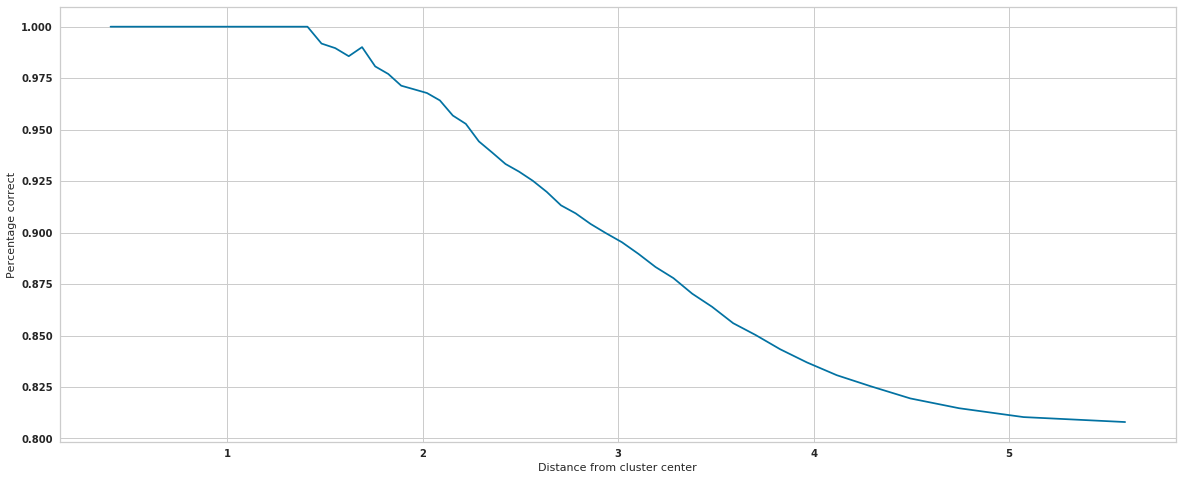

In [65]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [66]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

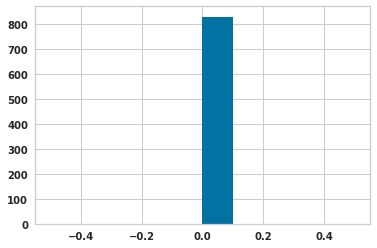

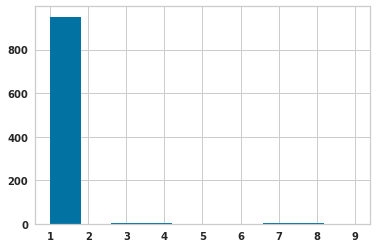

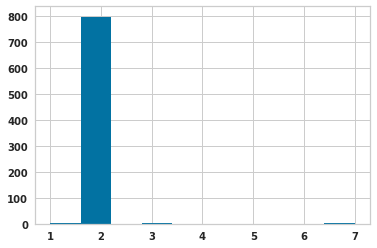

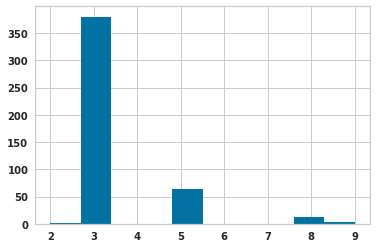

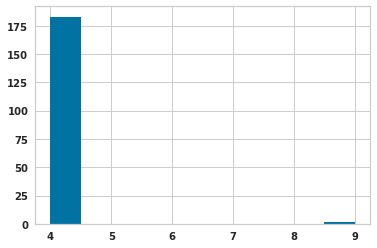

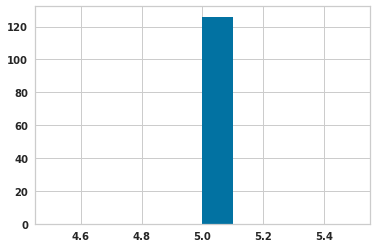

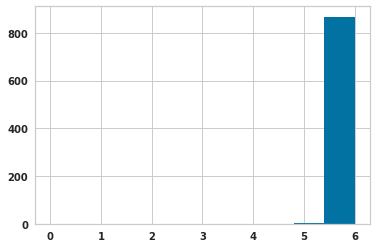

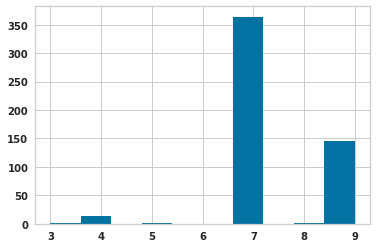

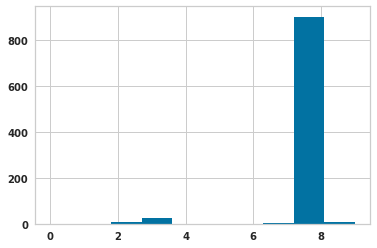

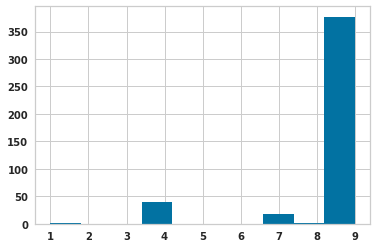

In [67]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 3

In [68]:
num_epochs
num_epochs += 1
print(num_epochs)

3


In [69]:
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
print(manual_annotation_file)

manual_annotation_epoch_2.0.csv


In [70]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 18300.114200114178
INFO:tensorflow:Summary name Negative Log Likel

Epoch: 2/64, Nll_loss : 119.79025268554688 KLD:9.465263366699219  Supervised loss:0.13815386593341827
Epoch: 2/65, Nll_loss : 126.55282592773438 KLD:9.883525848388672  Supervised loss:0.1299692988395691
Epoch: 2/66, Nll_loss : 111.10052490234375 KLD:9.64964771270752  Supervised loss:0.08782126009464264
Epoch: 2/67, Nll_loss : 114.41943359375 KLD:9.225090980529785  Supervised loss:0.12435147166252136
Epoch: 2/68, Nll_loss : 123.38020324707031 KLD:9.522758483886719  Supervised loss:0.13923728466033936
Epoch: 2/69, Nll_loss : 128.73358154296875 KLD:9.643524169921875  Supervised loss:0.11206786334514618
Epoch: 2/70, Nll_loss : 120.66152954101562 KLD:9.439306259155273  Supervised loss:0.11721991747617722
Epoch: 2/71, Nll_loss : 123.94292449951172 KLD:9.498445510864258  Supervised loss:0.1472371369600296
Epoch: 2/72, Nll_loss : 123.31243896484375 KLD:9.203784942626953  Supervised loss:0.17107439041137695
Epoch: 2/73, Nll_loss : 122.14422607421875 KLD:9.229999542236328  Supervised loss:0.1196

Epoch: 2/146, Nll_loss : 118.92274475097656 KLD:9.491628646850586  Supervised loss:0.09439167380332947
Epoch: 2/147, Nll_loss : 126.16334533691406 KLD:9.560216903686523  Supervised loss:0.10982927680015564
Epoch: 2/148, Nll_loss : 129.7110137939453 KLD:9.376861572265625  Supervised loss:0.12231966108083725
Epoch: 2/149, Nll_loss : 118.59607696533203 KLD:9.31772232055664  Supervised loss:0.11529377847909927
Epoch: 2/150, Nll_loss : 126.79244995117188 KLD:9.754171371459961  Supervised loss:0.11734841018915176
Epoch: 2/151, Nll_loss : 117.63748931884766 KLD:9.308216094970703  Supervised loss:0.11615061014890671
Epoch: 2/152, Nll_loss : 123.1649169921875 KLD:9.018054962158203  Supervised loss:0.1308898776769638
Epoch: 2/153, Nll_loss : 119.818115234375 KLD:9.115489959716797  Supervised loss:0.1066344678401947
Epoch: 2/154, Nll_loss : 125.61793518066406 KLD:8.978170394897461  Supervised loss:0.12491476535797119
Epoch: 2/155, Nll_loss : 129.7957000732422 KLD:9.08186149597168  Supervised loss

Epoch: 2/227, Nll_loss : 125.92760467529297 KLD:8.78120231628418  Supervised loss:0.13902121782302856
Epoch: 2/228, Nll_loss : 128.92922973632812 KLD:8.931663513183594  Supervised loss:0.15599630773067474
Epoch: 2/229, Nll_loss : 121.33798217773438 KLD:9.448774337768555  Supervised loss:0.125388965010643
Epoch: 2/230, Nll_loss : 126.6064453125 KLD:9.055418014526367  Supervised loss:0.14000847935676575
Epoch: 2/231, Nll_loss : 124.83839416503906 KLD:9.462467193603516  Supervised loss:0.14924028515815735
Epoch: 2/232, Nll_loss : 118.91352844238281 KLD:9.668587684631348  Supervised loss:0.08733401447534561
Epoch: 2/233, Nll_loss : 122.10617065429688 KLD:10.00510025024414  Supervised loss:0.07252658903598785
Epoch: 2/234, Nll_loss : 122.49889373779297 KLD:9.654414176940918  Supervised loss:0.10123436897993088
Epoch: 2/235, Nll_loss : 120.01211547851562 KLD:9.666740417480469  Supervised loss:0.09550468623638153
Epoch: 2/236, Nll_loss : 121.52184295654297 KLD:9.538515090942383  Supervised lo

Epoch: 2/309, Nll_loss : 115.61827087402344 KLD:9.386981964111328  Supervised loss:0.12614290416240692
Epoch: 2/310, Nll_loss : 130.14797973632812 KLD:9.473753929138184  Supervised loss:0.10504399240016937
Epoch: 2/311, Nll_loss : 128.11459350585938 KLD:9.459554672241211  Supervised loss:0.14094313979148865
Epoch: 2/312, Nll_loss : 124.79546356201172 KLD:9.727313041687012  Supervised loss:0.1143743023276329
Epoch: 2/313, Nll_loss : 124.66361999511719 KLD:9.198230743408203  Supervised loss:0.10125770419836044
Epoch: 2/314, Nll_loss : 119.84259796142578 KLD:9.382556915283203  Supervised loss:0.09219049662351608
Epoch: 2/315, Nll_loss : 117.83831787109375 KLD:9.28335189819336  Supervised loss:0.10328620672225952
Epoch: 2/316, Nll_loss : 117.19244384765625 KLD:9.1453857421875  Supervised loss:0.1267901510000229
Epoch: 2/317, Nll_loss : 118.46171569824219 KLD:9.039275169372559  Supervised loss:0.13839328289031982
Epoch: 2/318, Nll_loss : 117.03811645507812 KLD:9.048884391784668  Supervised 

Epoch: 2/389, Nll_loss : 120.63935852050781 KLD:9.190415382385254  Supervised loss:0.10695677250623703
Epoch: 2/390, Nll_loss : 125.08860778808594 KLD:9.399045944213867  Supervised loss:0.11337003111839294
Epoch: 2/391, Nll_loss : 117.77742767333984 KLD:9.079724311828613  Supervised loss:0.1212485060095787
Epoch: 2/392, Nll_loss : 121.28070068359375 KLD:9.31916618347168  Supervised loss:0.07821132242679596
Epoch: 2/393, Nll_loss : 126.99285888671875 KLD:9.69115924835205  Supervised loss:0.06300608813762665
Epoch: 2/394, Nll_loss : 124.58966064453125 KLD:9.43629264831543  Supervised loss:0.11638874560594559
Epoch: 2/395, Nll_loss : 118.91864013671875 KLD:9.206050872802734  Supervised loss:0.12781520187854767
Epoch: 2/396, Nll_loss : 116.11039733886719 KLD:9.740008354187012  Supervised loss:0.1207544356584549
Epoch: 2/397, Nll_loss : 114.85124206542969 KLD:9.038740158081055  Supervised loss:0.12130946666002274
Epoch: 2/398, Nll_loss : 129.85450744628906 KLD:9.323790550231934  Supervised 

Epoch: 2/470, Nll_loss : 116.69644165039062 KLD:9.492462158203125  Supervised loss:0.07863432168960571
Epoch: 2/471, Nll_loss : 117.03962707519531 KLD:9.15346908569336  Supervised loss:0.11493080854415894
Epoch: 2/472, Nll_loss : 122.49174499511719 KLD:9.052484512329102  Supervised loss:0.09837718307971954
Epoch: 2/473, Nll_loss : 120.09334564208984 KLD:9.1152925491333  Supervised loss:0.14108340442180634
Epoch: 2/474, Nll_loss : 120.7255630493164 KLD:8.90117073059082  Supervised loss:0.14734072983264923
Epoch: 2/475, Nll_loss : 119.81829071044922 KLD:9.059021949768066  Supervised loss:0.12441490590572357
Epoch: 2/476, Nll_loss : 117.57884979248047 KLD:9.461423873901367  Supervised loss:0.12054254114627838
Epoch: 2/477, Nll_loss : 121.35489654541016 KLD:9.249468803405762  Supervised loss:0.12495272606611252
Epoch: 2/478, Nll_loss : 120.8212661743164 KLD:9.014737129211426  Supervised loss:0.09522363543510437
Epoch: 2/479, Nll_loss : 125.18431854248047 KLD:9.217747688293457  Supervised l

Epoch: 2/551, Nll_loss : 122.21393585205078 KLD:9.435905456542969  Supervised loss:0.11511022597551346
Epoch: 2/552, Nll_loss : 113.18955993652344 KLD:9.05970287322998  Supervised loss:0.09725476056337357
Epoch: 2/553, Nll_loss : 119.57638549804688 KLD:9.454257011413574  Supervised loss:0.11979241669178009
Epoch: 2/554, Nll_loss : 121.80943298339844 KLD:9.0649995803833  Supervised loss:0.10674454271793365
Epoch: 2/555, Nll_loss : 122.54843139648438 KLD:9.378042221069336  Supervised loss:0.13384778797626495
Epoch: 2/556, Nll_loss : 124.33990478515625 KLD:9.372271537780762  Supervised loss:0.10132305324077606
Epoch: 2/557, Nll_loss : 120.66249084472656 KLD:9.296065330505371  Supervised loss:0.14384976029396057
Epoch: 2/558, Nll_loss : 117.69349670410156 KLD:8.965190887451172  Supervised loss:0.11270185559988022
Epoch: 2/559, Nll_loss : 121.7732925415039 KLD:9.134771347045898  Supervised loss:0.10626628994941711
Epoch: 2/560, Nll_loss : 115.28314208984375 KLD:8.576616287231445  Supervised

Epoch: 2/632, Nll_loss : 120.35601806640625 KLD:8.935009956359863  Supervised loss:0.10395271331071854
Epoch: 2/633, Nll_loss : 120.89180755615234 KLD:8.807204246520996  Supervised loss:0.1068711131811142
Epoch: 2/634, Nll_loss : 120.79994201660156 KLD:9.008753776550293  Supervised loss:0.14559030532836914
Epoch: 2/635, Nll_loss : 123.77239990234375 KLD:9.655451774597168  Supervised loss:0.13148608803749084
Epoch: 2/636, Nll_loss : 119.10643005371094 KLD:9.692395210266113  Supervised loss:0.10339979827404022
Epoch: 2/637, Nll_loss : 112.82598114013672 KLD:9.757410049438477  Supervised loss:0.10523396730422974
Epoch: 2/638, Nll_loss : 117.97591400146484 KLD:9.692487716674805  Supervised loss:0.10208114236593246
Epoch: 2/639, Nll_loss : 127.34663391113281 KLD:9.769556045532227  Supervised loss:0.1169399619102478
Epoch: 2/640, Nll_loss : 118.08039855957031 KLD:9.644401550292969  Supervised loss:0.09332682937383652
Epoch: 2/641, Nll_loss : 120.23599243164062 KLD:9.52750301361084  Supervise

Epoch: 2/713, Nll_loss : 122.16720581054688 KLD:9.053882598876953  Supervised loss:0.13833723962306976
Epoch: 2/714, Nll_loss : 115.62977600097656 KLD:9.493334770202637  Supervised loss:0.12727954983711243
Epoch: 2/715, Nll_loss : 117.18550109863281 KLD:9.214862823486328  Supervised loss:0.07221629470586777
Epoch: 2/716, Nll_loss : 115.85871887207031 KLD:9.442770004272461  Supervised loss:0.10635647177696228
Epoch: 2/717, Nll_loss : 125.52450561523438 KLD:9.724916458129883  Supervised loss:0.08948519825935364
Epoch: 2/718, Nll_loss : 111.99844360351562 KLD:9.107582092285156  Supervised loss:0.11977551877498627
Epoch: 2/719, Nll_loss : 122.22671508789062 KLD:9.054325103759766  Supervised loss:0.15698544681072235
Epoch: 2/720, Nll_loss : 117.99837493896484 KLD:9.19005012512207  Supervised loss:0.10674761980772018
Epoch: 2/721, Nll_loss : 121.04560089111328 KLD:9.312093734741211  Supervised loss:0.10803809016942978
Epoch: 2/722, Nll_loss : 113.45492553710938 KLD:9.510886192321777  Supervi

Epoch: 2/794, Nll_loss : 119.97706604003906 KLD:9.887527465820312  Supervised loss:0.10668815672397614
Epoch: 2/795, Nll_loss : 115.03794860839844 KLD:9.480074882507324  Supervised loss:0.11211001873016357
Epoch: 2/796, Nll_loss : 126.35311126708984 KLD:9.719098091125488  Supervised loss:0.06855496764183044
Epoch: 2/797, Nll_loss : 120.17306518554688 KLD:9.626731872558594  Supervised loss:0.11854062229394913
Epoch: 2/798, Nll_loss : 120.489990234375 KLD:9.1021146774292  Supervised loss:0.15646663308143616
Epoch: 2/799, Nll_loss : 125.02798461914062 KLD:9.817214012145996  Supervised loss:0.10710884630680084
Epoch: 2/800, Nll_loss : 121.23246765136719 KLD:9.935202598571777  Supervised loss:0.10067214071750641
Epoch: 2/801, Nll_loss : 112.73399353027344 KLD:9.343033790588379  Supervised loss:0.11677345633506775
Epoch: 2/802, Nll_loss : 115.65721130371094 KLD:9.643255233764648  Supervised loss:0.062373336404561996
Epoch: 2/803, Nll_loss : 117.72821044921875 KLD:8.788961410522461  Supervise

Epoch: 2/874, Nll_loss : 119.05557250976562 KLD:9.551187515258789  Supervised loss:0.10726074129343033
Epoch: 2/875, Nll_loss : 121.30575561523438 KLD:9.742992401123047  Supervised loss:0.1041196659207344
Epoch: 2/876, Nll_loss : 120.93498229980469 KLD:9.238948822021484  Supervised loss:0.10694503039121628
Epoch: 2/877, Nll_loss : 122.85364532470703 KLD:9.525300979614258  Supervised loss:0.07496999949216843
Epoch: 2/878, Nll_loss : 127.27140808105469 KLD:9.575389862060547  Supervised loss:0.08242236077785492
Epoch: 2/879, Nll_loss : 110.42545318603516 KLD:9.511246681213379  Supervised loss:0.09372967481613159
Epoch: 2/880, Nll_loss : 114.0501708984375 KLD:9.09666633605957  Supervised loss:0.13640819489955902
Epoch: 2/881, Nll_loss : 119.33052825927734 KLD:9.63126277923584  Supervised loss:0.11683785915374756
Epoch: 2/882, Nll_loss : 119.8392333984375 KLD:9.605436325073242  Supervised loss:0.1143244206905365
Epoch: 2/883, Nll_loss : 110.08023834228516 KLD:9.587160110473633  Supervised l

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-2805
 [*] Success to read SemiSupervisedClassifierMnist.model-2805
 [*] Load SUCCESS
Number of steps completed=2805
Number of epochs completed 3.0
run_id=45 z_min=-4.4785995000000005 z_max=4.3177824000000005
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergen

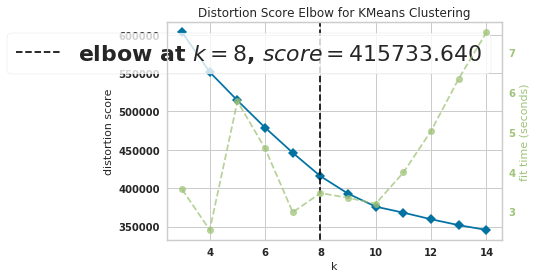

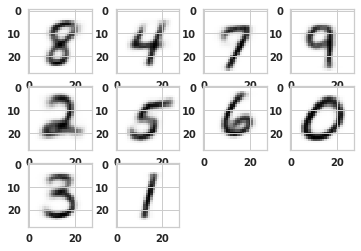

In [71]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [72]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [8, 4, 7, 9,
                                           2, 5, 6, 0,
                                           3, 1
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.9, 1, 1,
                                               1, 1, 1, 1,
                                               0.9, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    


Getting manual_annotation


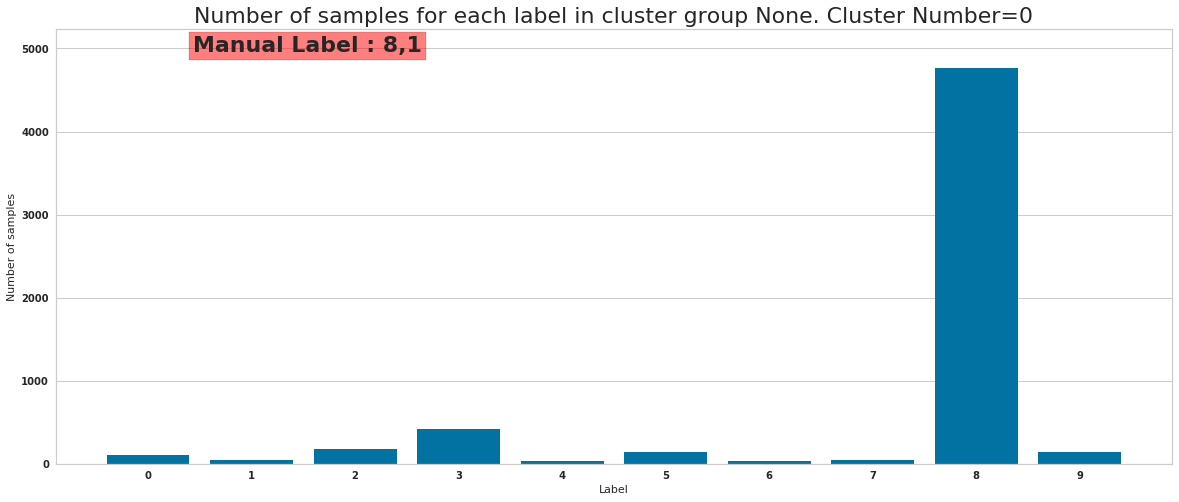

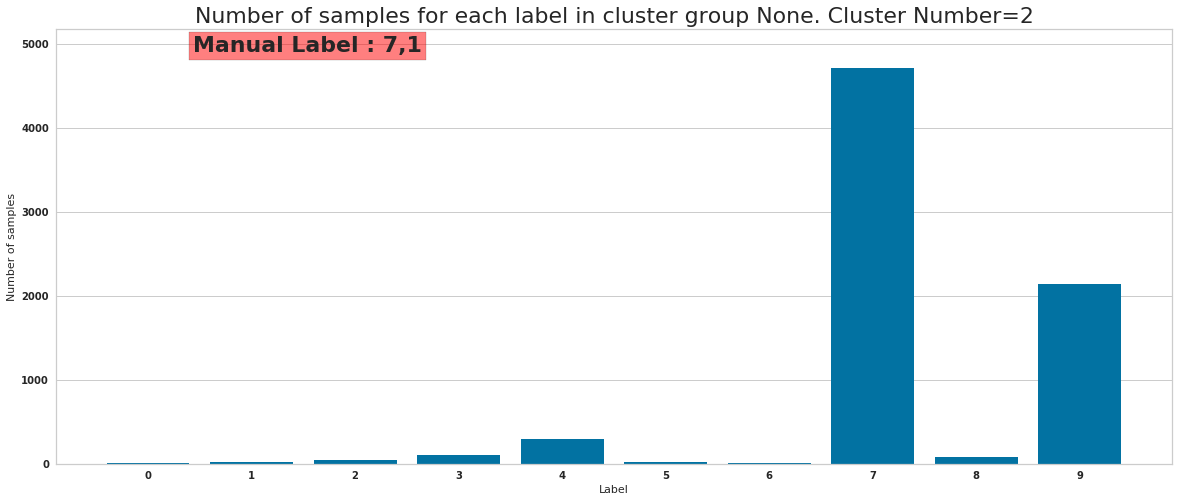

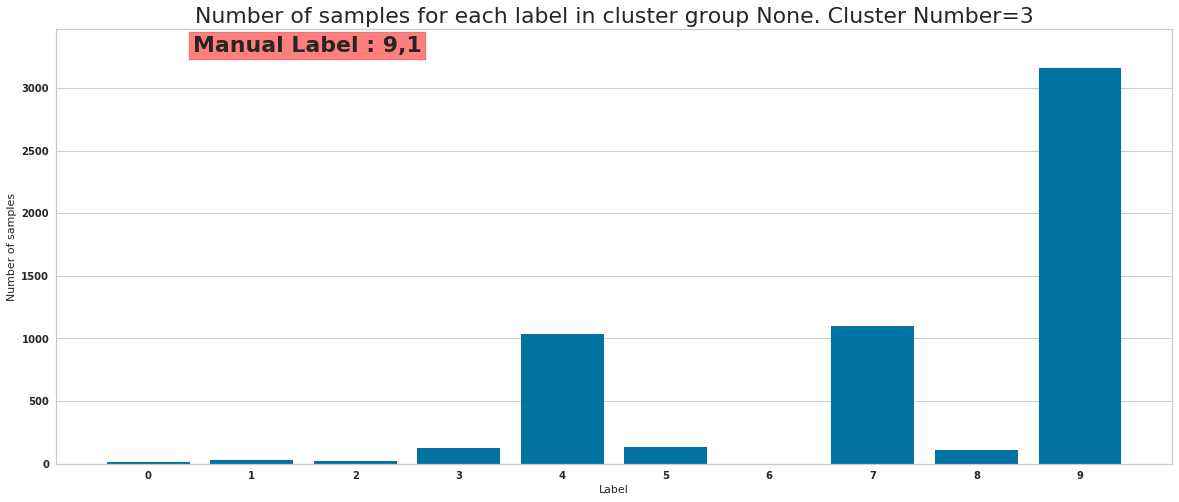

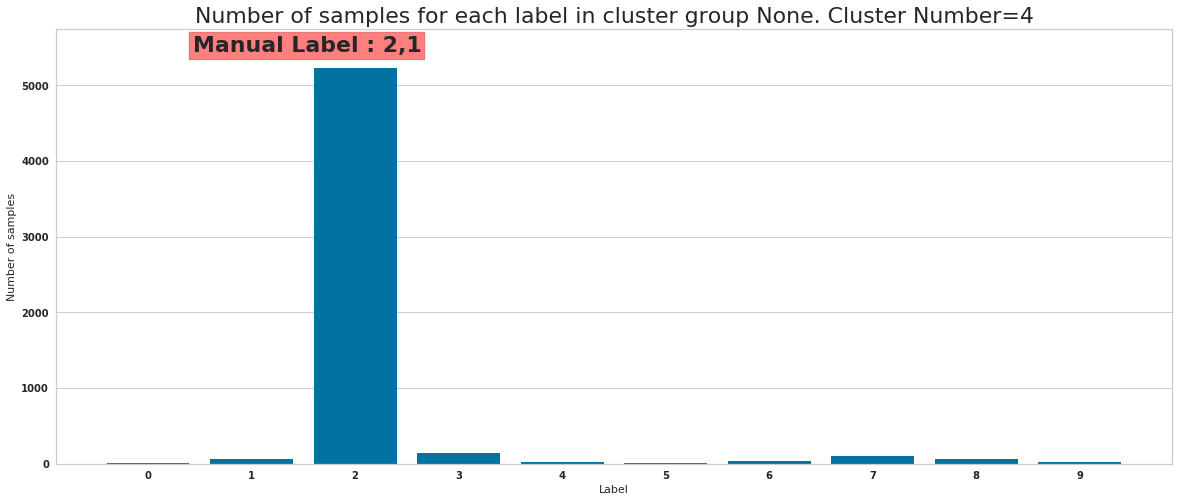

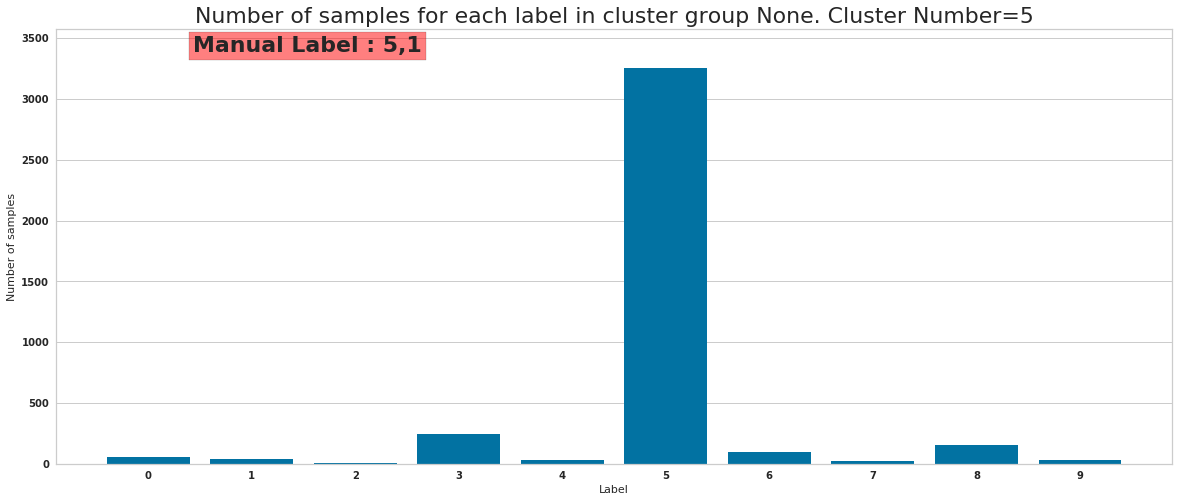

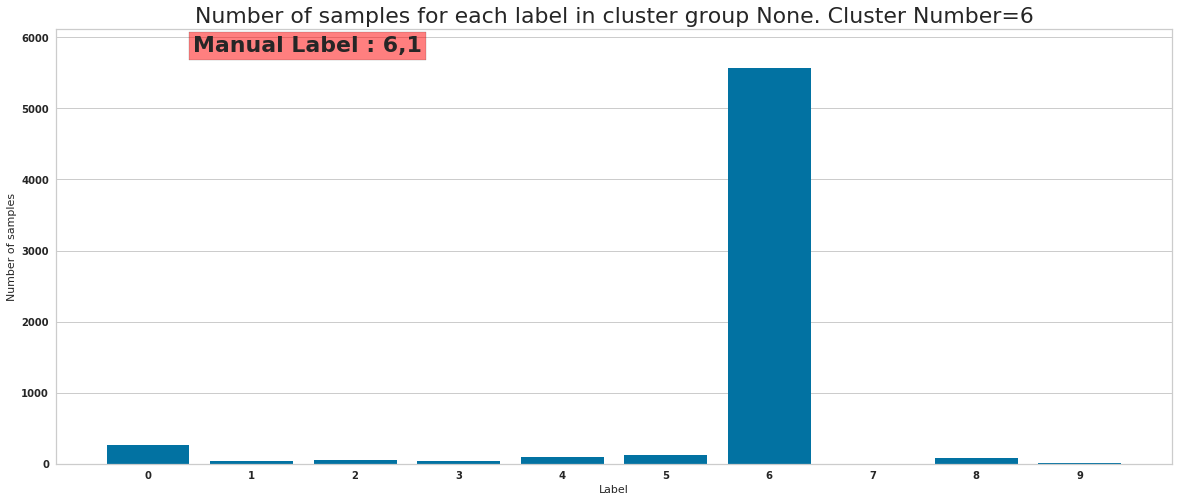

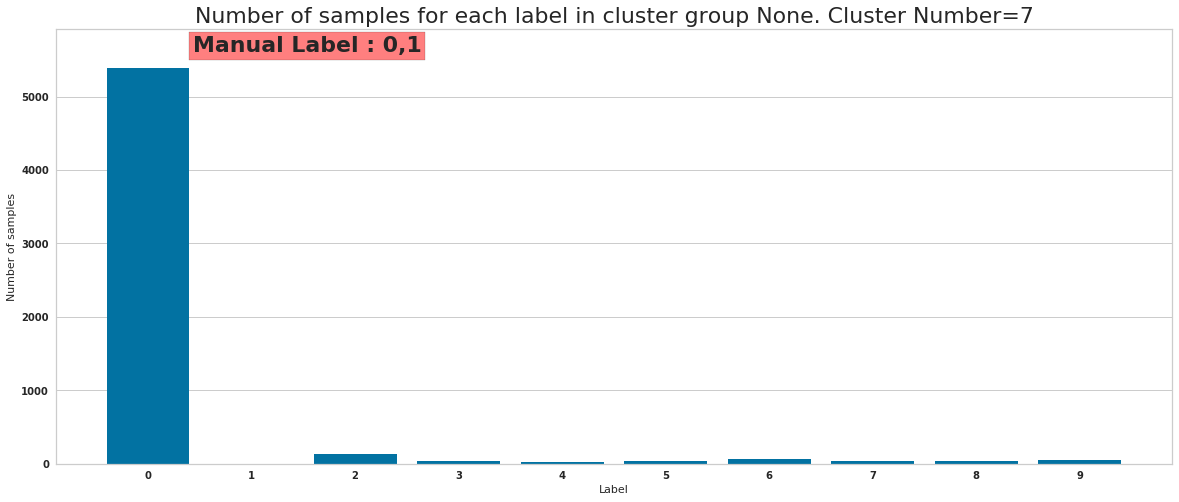

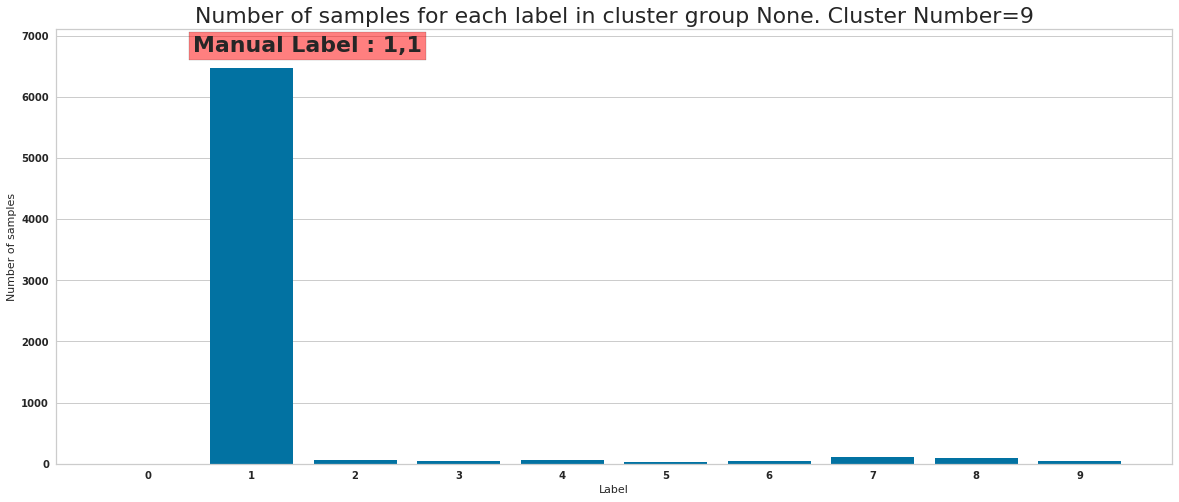

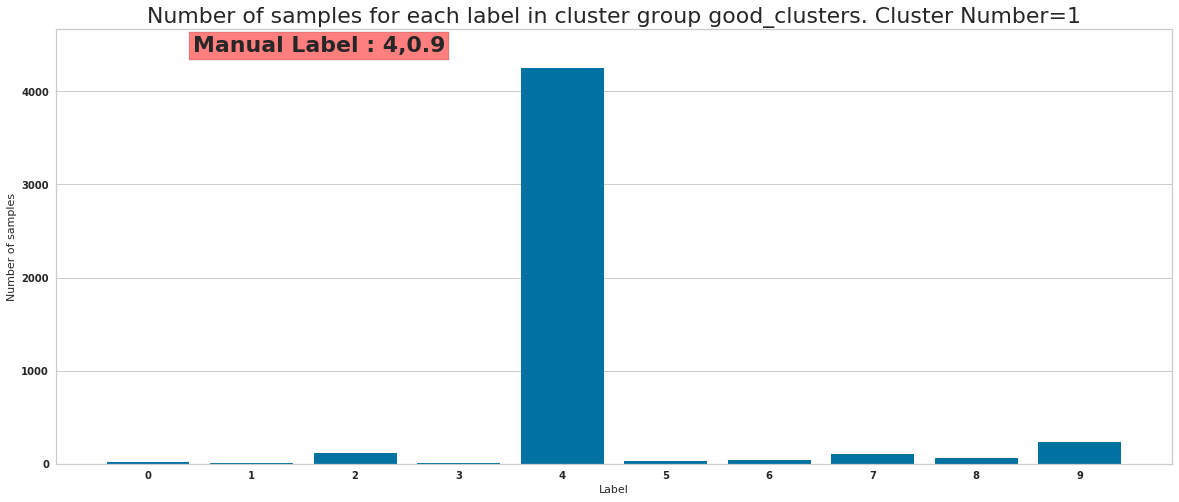

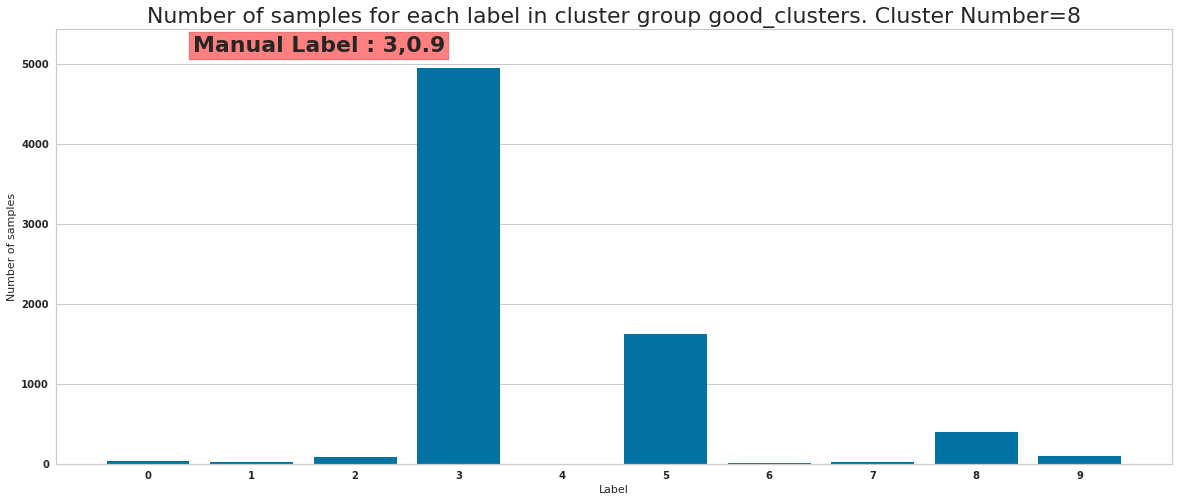

In [73]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [74]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(5903, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(4864, 10)
(7424, 10)
(5735, 10)
(5692, 10)
(3927, 10)
(6276, 10)
(5819, 10)
(7228, 10)
(6972, 10)


In [75]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,-1,-1,7,
#                                          4,4,9,-1,
#                                          -1,9
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0,0,0.6,
#                                              0.8,0.8,0.9,0,
#                                              0,0.9]
# level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,-1,-1,5,
#                                         1,1,8,-1,
#                                         -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [1,0,0,0.7,
#                                              1,1,0.8,0,
#                                              0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [76]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 8
(5903, 47) (5903, 33)
Num correct=4759
Cluster 0 Manual Label 8 Percentage correct 80.62002371675419
********************************
Manual Label 4
(4864, 47) (4864, 33)
Num correct=4245
Cluster 1 Manual Label 4 Percentage correct 87.27384868421052
********************************
Manual Label 7
(7424, 47) (7424, 33)
Num correct=4711
Cluster 2 Manual Label 7 Percentage correct 63.45635775862069
********************************
Manual Label 9
(5735, 47) (5735, 33)
Num correct=3155
Cluster 3 Manual Label 9 Percentage correct 55.013077593722755
********************************
Manual Label 2
(5692, 47) (5692, 33)
Num correct=5222
Cluster 4 Manual Label 2 Percentage correct 91.74279690794097
********************************
Manual Label 5
(3927, 47) (3927, 33)
Num correct=3251
Cluster 5 Manual Label 5 Percentage correct 82.78584160937102
********************************
Manual Label 6
(6276, 47) (6276, 33)
Num correct=5562
Cluster 6 Manual Label 6 Percentage correct 88.6233

In [77]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

In [78]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

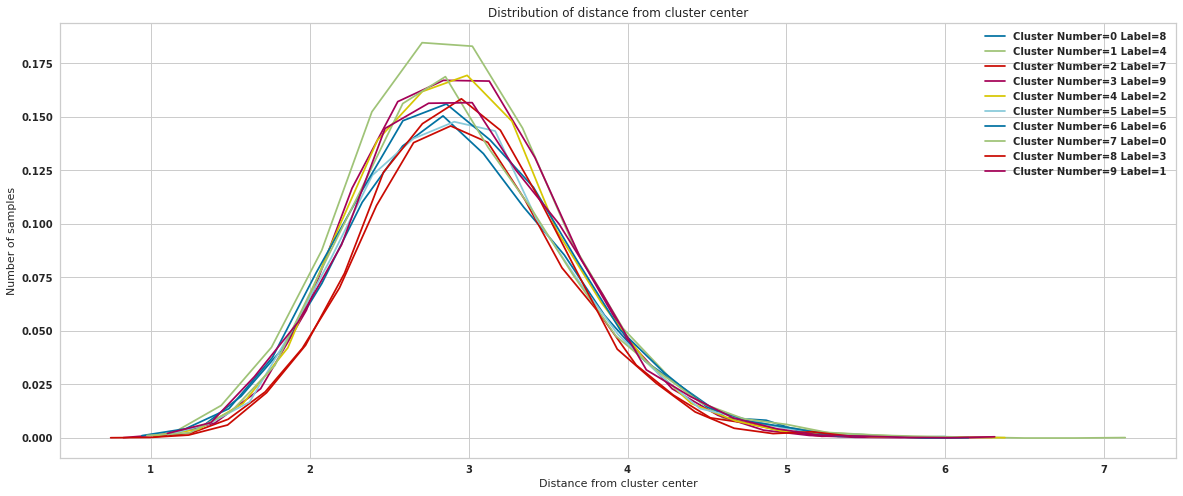

In [79]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

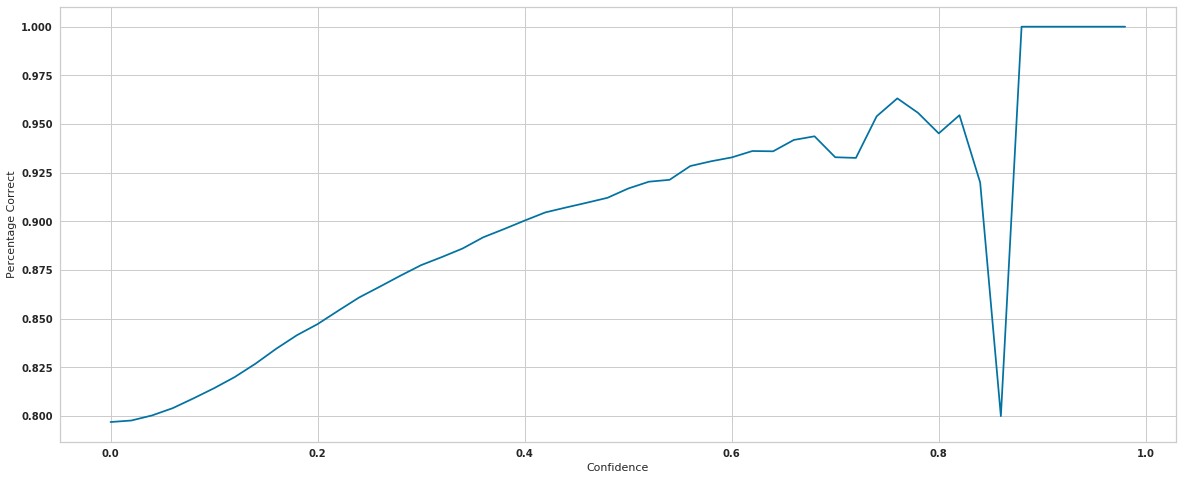

In [80]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

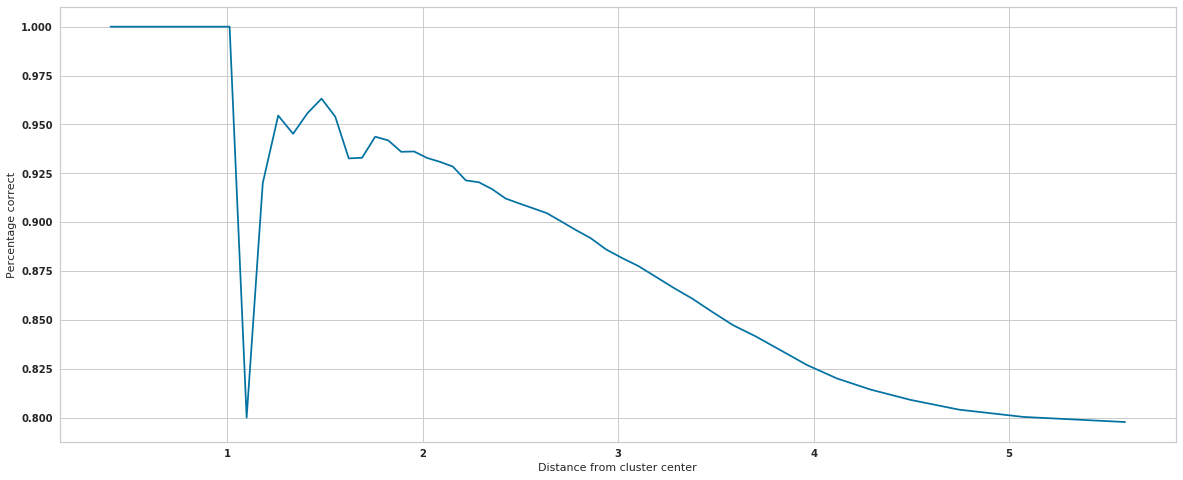

In [81]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

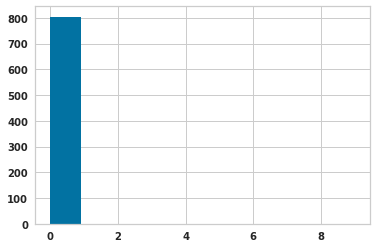

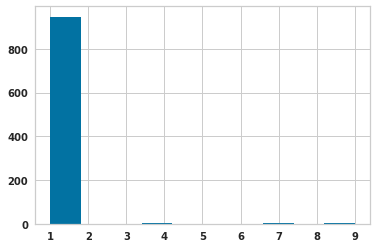

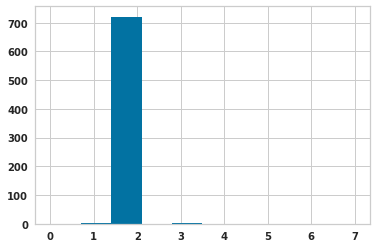

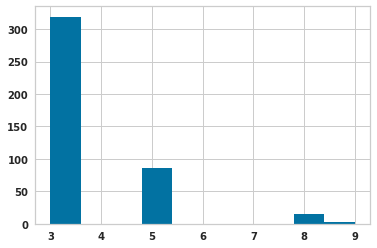

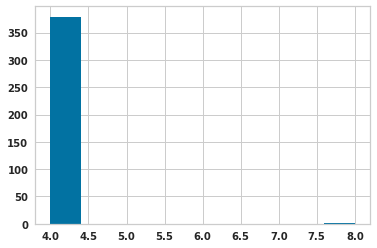

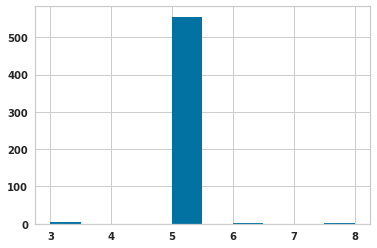

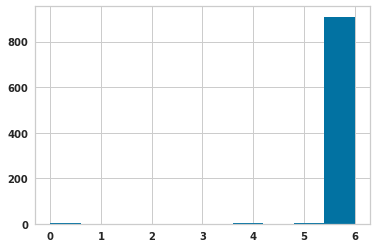

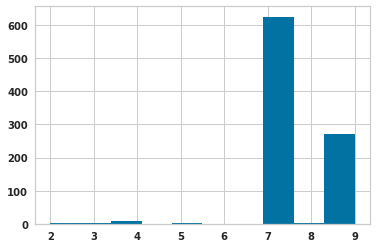

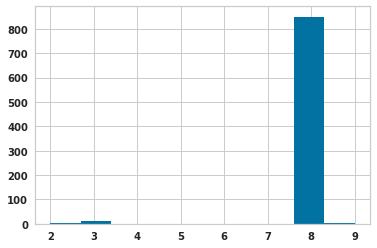

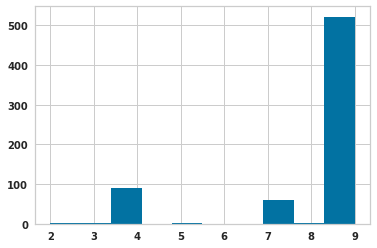

In [82]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 4

In [83]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 19071.58164469969
INFO:tensorflow:Summary name Negative Log Likeli

Epoch: 3/66, Nll_loss : 107.41454315185547 KLD:9.540058135986328  Supervised loss:0.045482929795980453
Epoch: 3/67, Nll_loss : 109.06263732910156 KLD:9.21250057220459  Supervised loss:0.11272384226322174
Epoch: 3/68, Nll_loss : 121.20805358886719 KLD:9.553472518920898  Supervised loss:0.08660820126533508
Epoch: 3/69, Nll_loss : 126.16281127929688 KLD:9.686437606811523  Supervised loss:0.08096227049827576
Epoch: 3/70, Nll_loss : 114.26933288574219 KLD:9.48707389831543  Supervised loss:0.0715833455324173
Epoch: 3/71, Nll_loss : 115.84608459472656 KLD:9.579822540283203  Supervised loss:0.0999256819486618
Epoch: 3/72, Nll_loss : 117.43865966796875 KLD:9.404619216918945  Supervised loss:0.09298467636108398
Epoch: 3/73, Nll_loss : 117.86627197265625 KLD:9.174663543701172  Supervised loss:0.09963272511959076
Epoch: 3/74, Nll_loss : 125.64527893066406 KLD:9.445960998535156  Supervised loss:0.065486378967762
Epoch: 3/75, Nll_loss : 118.11851501464844 KLD:8.715608596801758  Supervised loss:0.104

Epoch: 3/147, Nll_loss : 123.5946044921875 KLD:9.407390594482422  Supervised loss:0.10979389399290085
Epoch: 3/148, Nll_loss : 129.15255737304688 KLD:9.356998443603516  Supervised loss:0.12364651262760162
Epoch: 3/149, Nll_loss : 117.45582580566406 KLD:9.327604293823242  Supervised loss:0.10756397992372513
Epoch: 3/150, Nll_loss : 123.94483947753906 KLD:9.724541664123535  Supervised loss:0.12966428697109222
Epoch: 3/151, Nll_loss : 116.56936645507812 KLD:9.690282821655273  Supervised loss:0.10061560571193695
Epoch: 3/152, Nll_loss : 115.78388977050781 KLD:9.644205093383789  Supervised loss:0.08529793471097946
Epoch: 3/153, Nll_loss : 114.60975646972656 KLD:9.95500659942627  Supervised loss:0.07609383761882782
Epoch: 3/154, Nll_loss : 121.31988525390625 KLD:9.766451835632324  Supervised loss:0.14837387204170227
Epoch: 3/155, Nll_loss : 122.7480697631836 KLD:10.125054359436035  Supervised loss:0.0781964436173439
Epoch: 3/156, Nll_loss : 119.14734649658203 KLD:9.667234420776367  Supervise

Epoch: 3/229, Nll_loss : 112.43450164794922 KLD:10.406311988830566  Supervised loss:0.10050861537456512
Epoch: 3/230, Nll_loss : 124.1505126953125 KLD:9.735040664672852  Supervised loss:0.09437504410743713
Epoch: 3/231, Nll_loss : 120.81117248535156 KLD:9.935243606567383  Supervised loss:0.1179782897233963
Epoch: 3/232, Nll_loss : 116.53650665283203 KLD:9.481592178344727  Supervised loss:0.09226938337087631
Epoch: 3/233, Nll_loss : 117.61109924316406 KLD:9.663150787353516  Supervised loss:0.08619450032711029
Epoch: 3/234, Nll_loss : 120.43761444091797 KLD:9.416536331176758  Supervised loss:0.08989349007606506
Epoch: 3/235, Nll_loss : 116.16527557373047 KLD:9.464700698852539  Supervised loss:0.05524357035756111
Epoch: 3/236, Nll_loss : 119.5716552734375 KLD:9.481782913208008  Supervised loss:0.08587796986103058
Epoch: 3/237, Nll_loss : 127.88233947753906 KLD:9.213180541992188  Supervised loss:0.09660904109477997
Epoch: 3/238, Nll_loss : 116.01033020019531 KLD:9.270414352416992  Supervis

Epoch: 3/310, Nll_loss : 128.25613403320312 KLD:9.92926025390625  Supervised loss:0.09982733428478241
Epoch: 3/311, Nll_loss : 124.58128356933594 KLD:9.780744552612305  Supervised loss:0.12259285151958466
Epoch: 3/312, Nll_loss : 120.05823516845703 KLD:9.9147310256958  Supervised loss:0.08333896100521088
Epoch: 3/313, Nll_loss : 120.25213623046875 KLD:9.435054779052734  Supervised loss:0.09117516875267029
Epoch: 3/314, Nll_loss : 110.91173553466797 KLD:9.358707427978516  Supervised loss:0.08376074582338333
Epoch: 3/315, Nll_loss : 116.50410461425781 KLD:9.128942489624023  Supervised loss:0.122159942984581
Epoch: 3/316, Nll_loss : 118.24728393554688 KLD:8.970052719116211  Supervised loss:0.11404994130134583
Epoch: 3/317, Nll_loss : 119.57164001464844 KLD:8.873322486877441  Supervised loss:0.10266651958227158
Epoch: 3/318, Nll_loss : 116.06201171875 KLD:8.775732040405273  Supervised loss:0.07852590084075928
Epoch: 3/319, Nll_loss : 122.6533203125 KLD:9.309303283691406  Supervised loss:0.

Epoch: 3/391, Nll_loss : 115.10623931884766 KLD:9.328228950500488  Supervised loss:0.10421712696552277
Epoch: 3/392, Nll_loss : 116.34318542480469 KLD:9.440042495727539  Supervised loss:0.1059301346540451
Epoch: 3/393, Nll_loss : 117.92878723144531 KLD:9.786140441894531  Supervised loss:0.08651864528656006
Epoch: 3/394, Nll_loss : 119.35610961914062 KLD:9.445898056030273  Supervised loss:0.09989168494939804
Epoch: 3/395, Nll_loss : 120.2742919921875 KLD:9.154498100280762  Supervised loss:0.12143515050411224
Epoch: 3/396, Nll_loss : 116.29690551757812 KLD:9.641130447387695  Supervised loss:0.08930260688066483
Epoch: 3/397, Nll_loss : 110.39303588867188 KLD:9.312824249267578  Supervised loss:0.13826404511928558
Epoch: 3/398, Nll_loss : 123.90281677246094 KLD:10.135688781738281  Supervised loss:0.07372281700372696
Epoch: 3/399, Nll_loss : 118.11250305175781 KLD:10.255899429321289  Supervised loss:0.0762953981757164
Epoch: 3/400, Nll_loss : 120.94723510742188 KLD:9.74364948272705  Supervis

Epoch: 3/472, Nll_loss : 120.19644927978516 KLD:9.184968948364258  Supervised loss:0.09832257777452469
Epoch: 3/473, Nll_loss : 116.39989471435547 KLD:9.248250961303711  Supervised loss:0.07196249067783356
Epoch: 3/474, Nll_loss : 115.9677505493164 KLD:8.871068000793457  Supervised loss:0.09652503579854965
Epoch: 3/475, Nll_loss : 119.80224609375 KLD:9.034479141235352  Supervised loss:0.10587185621261597
Epoch: 3/476, Nll_loss : 117.14751434326172 KLD:9.58693790435791  Supervised loss:0.04507070407271385
Epoch: 3/477, Nll_loss : 118.92607879638672 KLD:9.463461875915527  Supervised loss:0.09693202376365662
Epoch: 3/478, Nll_loss : 115.65579223632812 KLD:9.46710205078125  Supervised loss:0.11869245767593384
Epoch: 3/479, Nll_loss : 122.1837387084961 KLD:9.925905227661133  Supervised loss:0.07994093745946884
Epoch: 3/480, Nll_loss : 114.39141845703125 KLD:9.809316635131836  Supervised loss:0.05495985597372055
Epoch: 3/481, Nll_loss : 120.86034393310547 KLD:9.615992546081543  Supervised lo

Epoch: 3/554, Nll_loss : 119.37794494628906 KLD:9.611848831176758  Supervised loss:0.08542823791503906
Epoch: 3/555, Nll_loss : 118.53524780273438 KLD:10.161087036132812  Supervised loss:0.14752182364463806
Epoch: 3/556, Nll_loss : 121.330322265625 KLD:10.055349349975586  Supervised loss:0.06891296803951263
Epoch: 3/557, Nll_loss : 115.68975830078125 KLD:9.783740997314453  Supervised loss:0.0703723281621933
Epoch: 3/558, Nll_loss : 112.77828979492188 KLD:9.386063575744629  Supervised loss:0.08931106328964233
Epoch: 3/559, Nll_loss : 113.72833251953125 KLD:9.566608428955078  Supervised loss:0.10171476751565933
Epoch: 3/560, Nll_loss : 114.35739135742188 KLD:8.952615737915039  Supervised loss:0.11382001638412476
Epoch: 3/561, Nll_loss : 112.0945053100586 KLD:9.010724067687988  Supervised loss:0.09306599199771881
Epoch: 3/562, Nll_loss : 122.16935729980469 KLD:9.104326248168945  Supervised loss:0.14601123332977295
Epoch: 3/563, Nll_loss : 117.3064193725586 KLD:9.343814849853516  Supervise

Epoch: 3/635, Nll_loss : 119.1574935913086 KLD:9.798676490783691  Supervised loss:0.0937010645866394
Epoch: 3/636, Nll_loss : 116.54900360107422 KLD:9.596208572387695  Supervised loss:0.09430377185344696
Epoch: 3/637, Nll_loss : 107.90786743164062 KLD:9.529553413391113  Supervised loss:0.09378103166818619
Epoch: 3/638, Nll_loss : 116.4383773803711 KLD:9.441271781921387  Supervised loss:0.09977404773235321
Epoch: 3/639, Nll_loss : 124.09359741210938 KLD:9.753061294555664  Supervised loss:0.09707413613796234
Epoch: 3/640, Nll_loss : 117.16752624511719 KLD:9.717779159545898  Supervised loss:0.06448300182819366
Epoch: 3/641, Nll_loss : 116.38024139404297 KLD:9.52186393737793  Supervised loss:0.09694056957960129
Epoch: 3/642, Nll_loss : 126.98211669921875 KLD:9.977015495300293  Supervised loss:0.07609891891479492
Epoch: 3/643, Nll_loss : 122.69538879394531 KLD:9.91614818572998  Supervised loss:0.06573086231946945
Epoch: 3/644, Nll_loss : 121.57640075683594 KLD:9.643077850341797  Supervised 

Epoch: 3/715, Nll_loss : 116.3271484375 KLD:9.426124572753906  Supervised loss:0.08415313065052032
Epoch: 3/716, Nll_loss : 112.53166198730469 KLD:9.700786590576172  Supervised loss:0.051247112452983856
Epoch: 3/717, Nll_loss : 116.51042175292969 KLD:10.162250518798828  Supervised loss:0.09981565177440643
Epoch: 3/718, Nll_loss : 108.184814453125 KLD:9.200820922851562  Supervised loss:0.08777359127998352
Epoch: 3/719, Nll_loss : 120.39080810546875 KLD:9.283875465393066  Supervised loss:0.10685708373785019
Epoch: 3/720, Nll_loss : 115.90010070800781 KLD:9.385429382324219  Supervised loss:0.11720195412635803
Epoch: 3/721, Nll_loss : 114.16290283203125 KLD:9.62885856628418  Supervised loss:0.08581537008285522
Epoch: 3/722, Nll_loss : 107.69381713867188 KLD:9.747983932495117  Supervised loss:0.10023707896471024
Epoch: 3/723, Nll_loss : 117.89801788330078 KLD:10.086462020874023  Supervised loss:0.09500981867313385
Epoch: 3/724, Nll_loss : 120.00321197509766 KLD:10.102004051208496  Supervise

Epoch: 3/796, Nll_loss : 120.6520767211914 KLD:10.10976791381836  Supervised loss:0.04126622527837753
Epoch: 3/797, Nll_loss : 113.53822326660156 KLD:9.730644226074219  Supervised loss:0.06294858455657959
Epoch: 3/798, Nll_loss : 120.27362060546875 KLD:9.188961029052734  Supervised loss:0.07841309905052185
Epoch: 3/799, Nll_loss : 122.49226379394531 KLD:9.792868614196777  Supervised loss:0.1121978610754013
Epoch: 3/800, Nll_loss : 121.84440612792969 KLD:9.709105491638184  Supervised loss:0.08975908160209656
Epoch: 3/801, Nll_loss : 109.66917419433594 KLD:9.332254409790039  Supervised loss:0.0992647185921669
Epoch: 3/802, Nll_loss : 113.05619812011719 KLD:9.868364334106445  Supervised loss:0.05022125691175461
Epoch: 3/803, Nll_loss : 111.78419494628906 KLD:9.321712493896484  Supervised loss:0.11135242134332657
Epoch: 3/804, Nll_loss : 120.1102523803711 KLD:9.904597282409668  Supervised loss:0.08915069699287415
Epoch: 3/805, Nll_loss : 113.62477111816406 KLD:9.763782501220703  Supervised

Epoch: 3/877, Nll_loss : 120.27980041503906 KLD:9.429306030273438  Supervised loss:0.11963041871786118
Epoch: 3/878, Nll_loss : 125.15536499023438 KLD:9.36652946472168  Supervised loss:0.11062760651111603
Epoch: 3/879, Nll_loss : 111.35592651367188 KLD:9.190839767456055  Supervised loss:0.059114545583724976
Epoch: 3/880, Nll_loss : 111.81932067871094 KLD:8.815438270568848  Supervised loss:0.11695172637701035
Epoch: 3/881, Nll_loss : 116.76428985595703 KLD:9.484347343444824  Supervised loss:0.07656431198120117
Epoch: 3/882, Nll_loss : 118.01048278808594 KLD:9.437808990478516  Supervised loss:0.0723826140165329
Epoch: 3/883, Nll_loss : 108.82005310058594 KLD:9.434000015258789  Supervised loss:0.050298649817705154
Epoch: 3/884, Nll_loss : 119.18580627441406 KLD:9.790909767150879  Supervised loss:0.06303560733795166
Epoch: 3/885, Nll_loss : 118.72598266601562 KLD:9.163196563720703  Supervised loss:0.1319783627986908
Epoch: 3/886, Nll_loss : 119.95150756835938 KLD:9.558708190917969  Supervi

In [84]:
num_cluster=10
num_clusters=10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-3740
 [*] Success to read SemiSupervisedClassifierMnist.model-3740
 [*] Load SUCCESS
Number of steps completed=3740
Number of epochs completed 4.0
run_id=45 z_min=-3.9295745 z_max=4.230285
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; usin

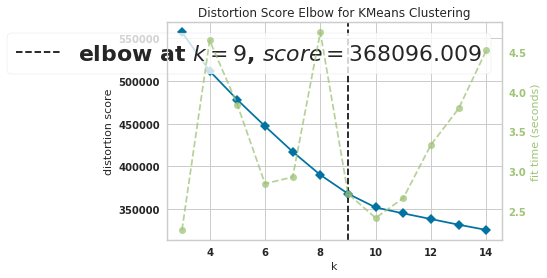

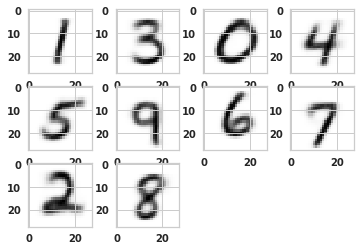

In [85]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [86]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [1, 3, 0, 4,
                                           5, 9, 6, 7,
                                           2, 8,
                                          ]
manual_annotation_json["manual_confidence"] = [1, 0.9, 1, 0.9,
                                               0.9,0.9,1, 1,
                                               1,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    

    

Getting manual_annotation


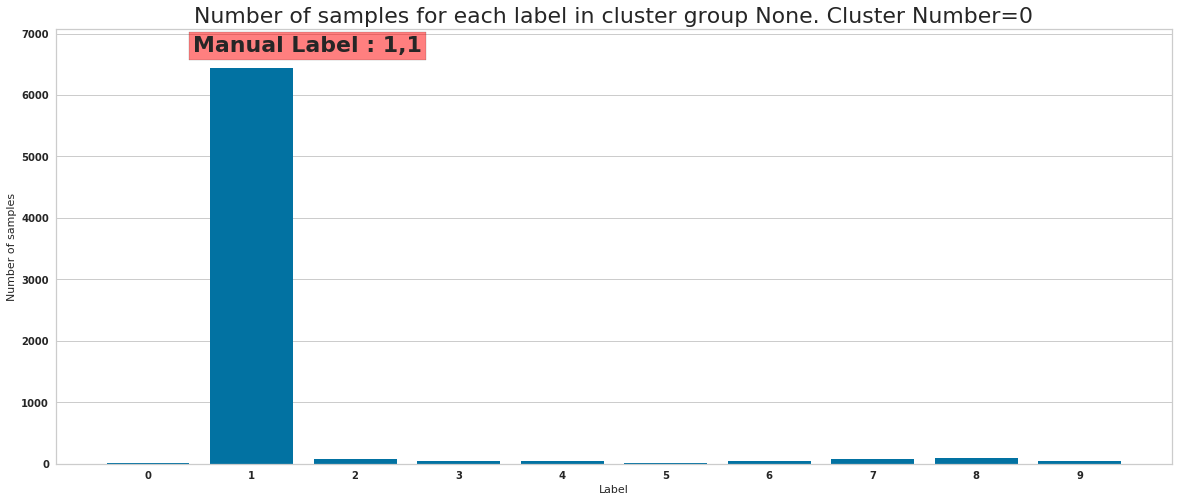

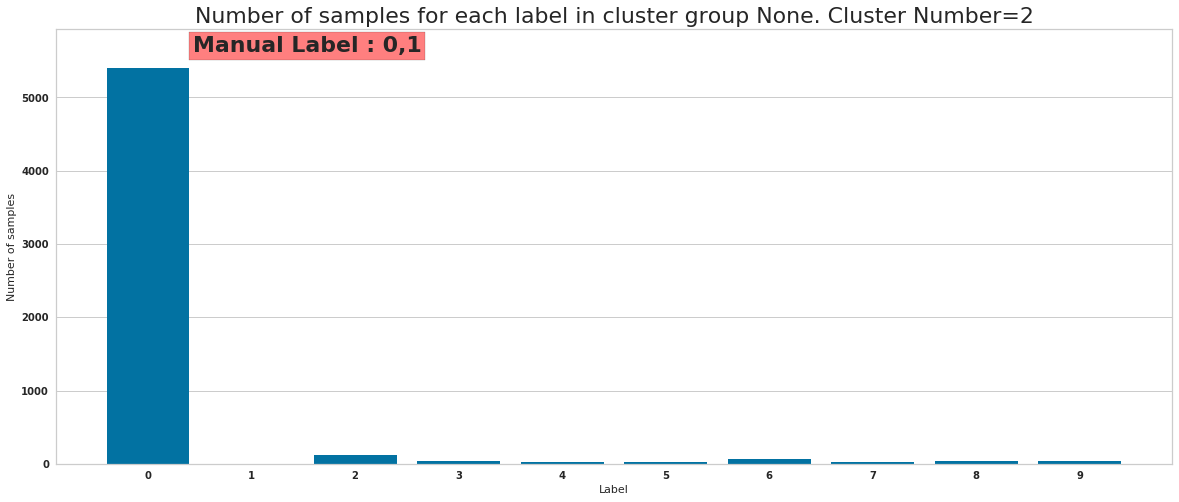

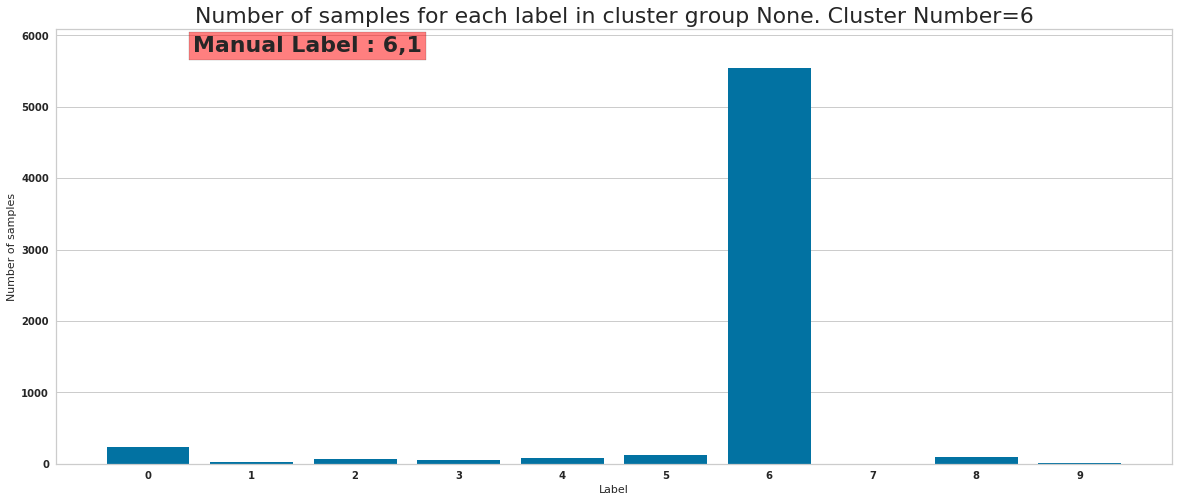

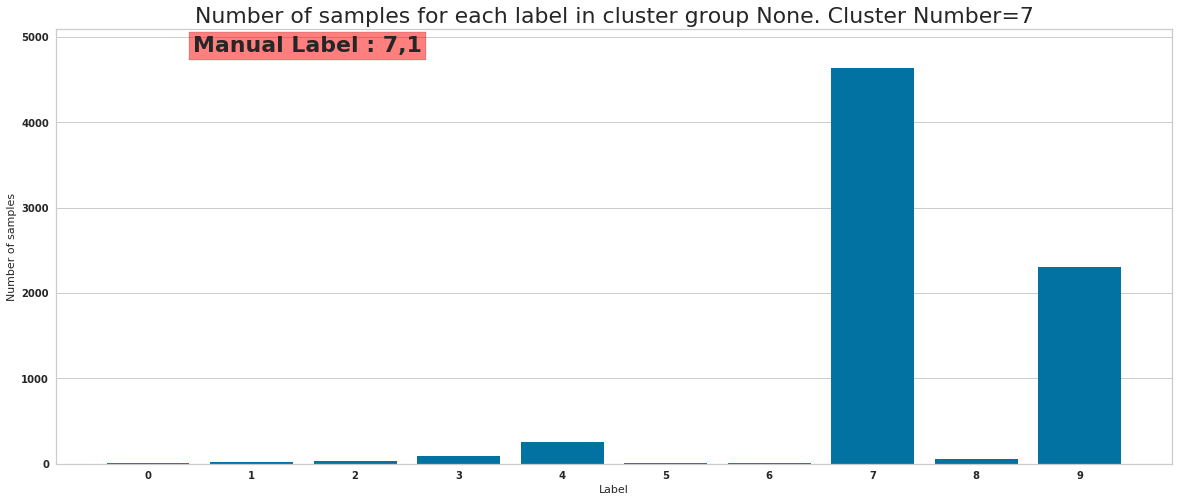

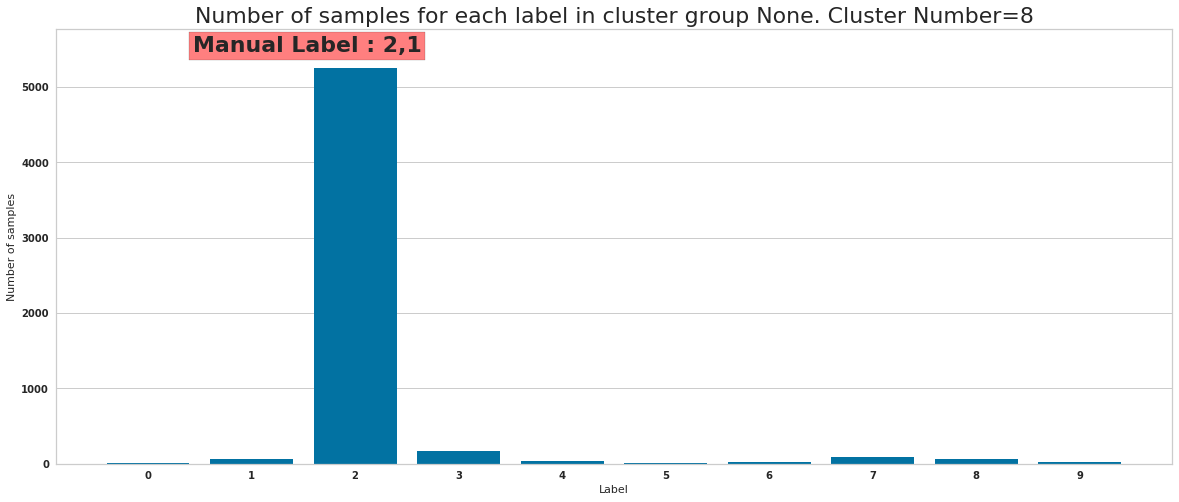

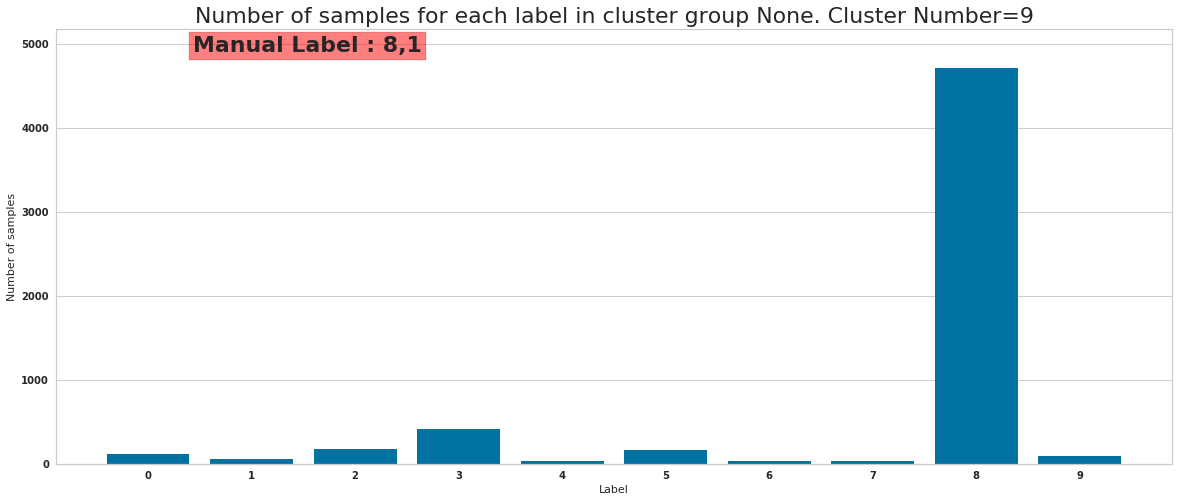

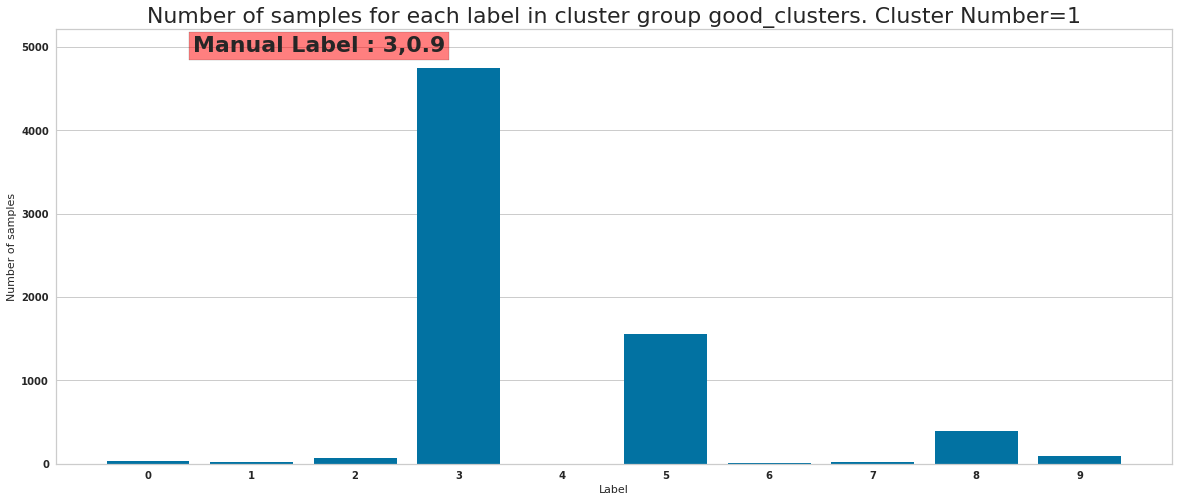

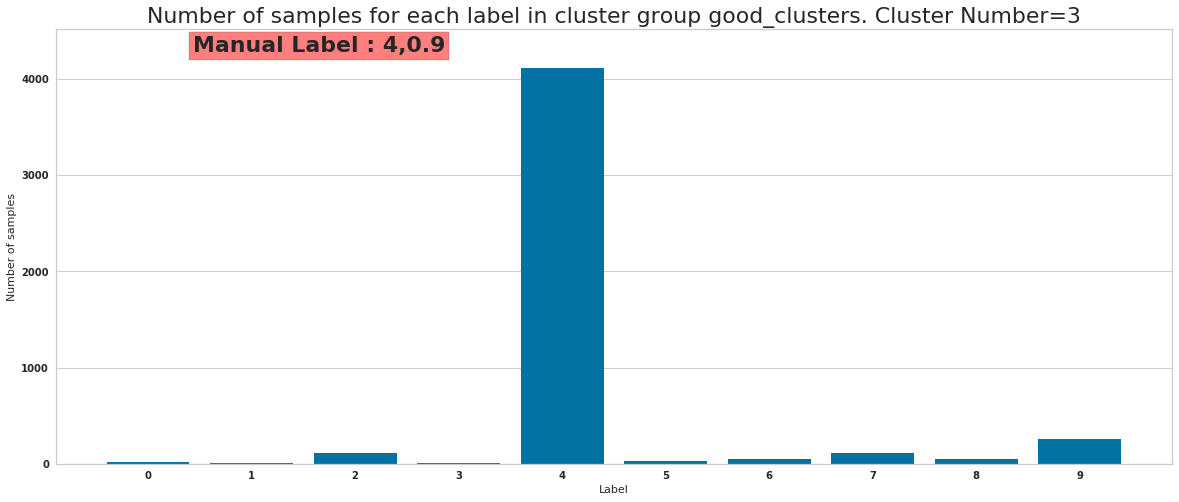

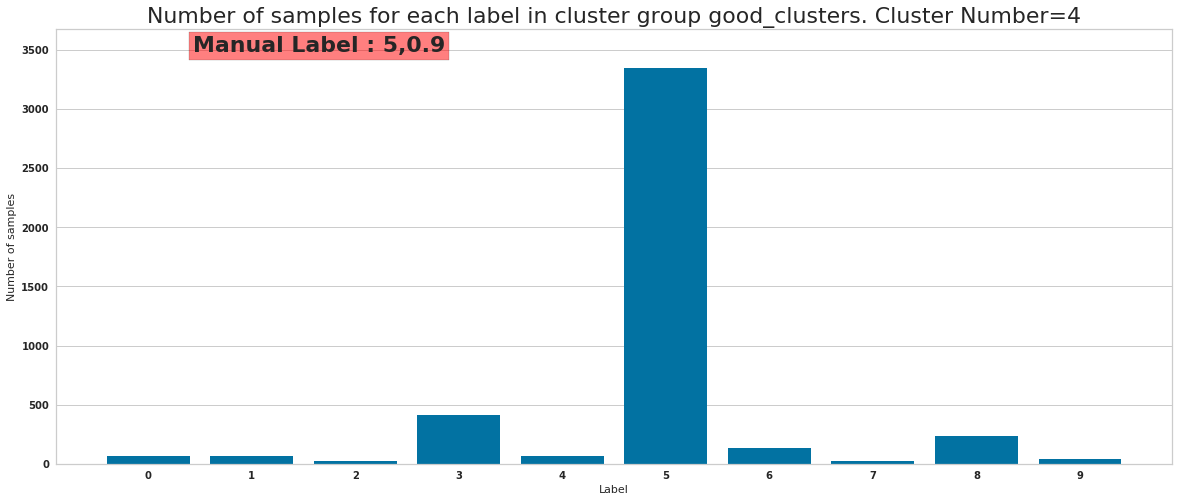

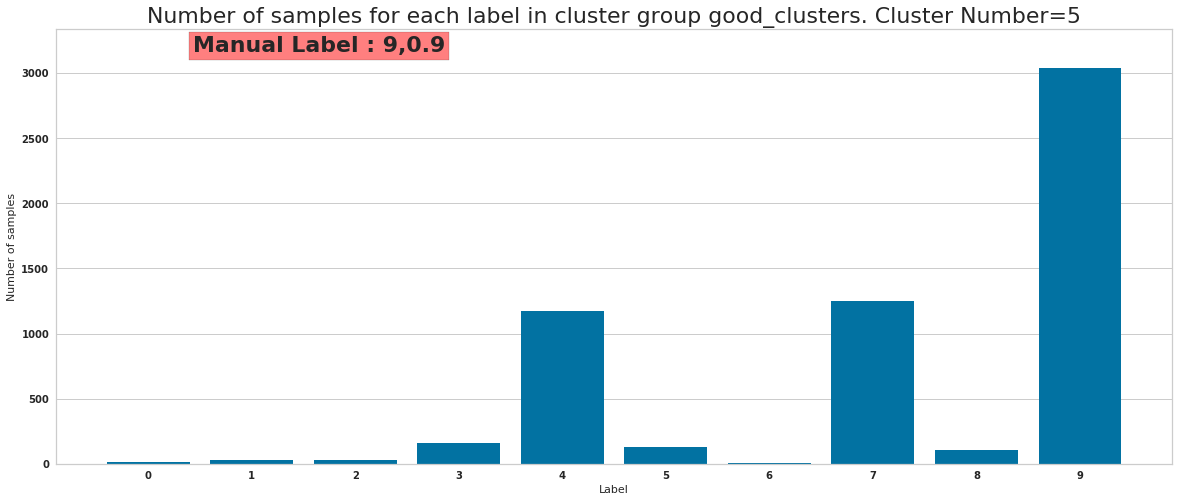

In [87]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [88]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(6866, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(6937, 10)
(5775, 10)
(4749, 10)
(4405, 10)
(5928, 10)
(6218, 10)
(7424, 10)
(5722, 10)
(5816, 10)


In [89]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [5,0,-1,5,
#                                          5,8,1,5,
#                                          -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0.7,0,0.7,
#                                              0.8,0.8,0.9,0.7,
#                                              0,0]
# level2_manual_annotations[0] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [3,-1,3,3,
# #                                         3,3,3,3,
# #                                         -1,3]
# # level_2_cluster_dict["manual_confidences"] = [0.9,0,0.9,0.9,
# #                                              0.9,0.9,0.9,0.9,
# #                                              0,0.9]
# # level2_manual_annotations[7] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [90]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 1
(6866, 47) (6866, 33)
Num correct=6432
Cluster 0 Manual Label 1 Percentage correct 93.67899796096708
********************************
Manual Label 3
(6937, 47) (6937, 33)
Num correct=4744
Cluster 1 Manual Label 3 Percentage correct 68.38691076834367
********************************
Manual Label 0
(5775, 47) (5775, 33)
Num correct=5394
Cluster 2 Manual Label 0 Percentage correct 93.40259740259741
********************************
Manual Label 4
(4749, 47) (4749, 33)
Num correct=4107
Cluster 3 Manual Label 4 Percentage correct 86.481364497789
********************************
Manual Label 5
(4405, 47) (4405, 33)
Num correct=3343
Cluster 4 Manual Label 5 Percentage correct 75.89103291713961
********************************
Manual Label 9
(5928, 47) (5928, 33)
Num correct=3036
Cluster 5 Manual Label 9 Percentage correct 51.21457489878542
********************************
Manual Label 6
(6218, 47) (6218, 33)
Num correct=5536
Cluster 6 Manual Label 6 Percentage correct 89.0318430

In [91]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

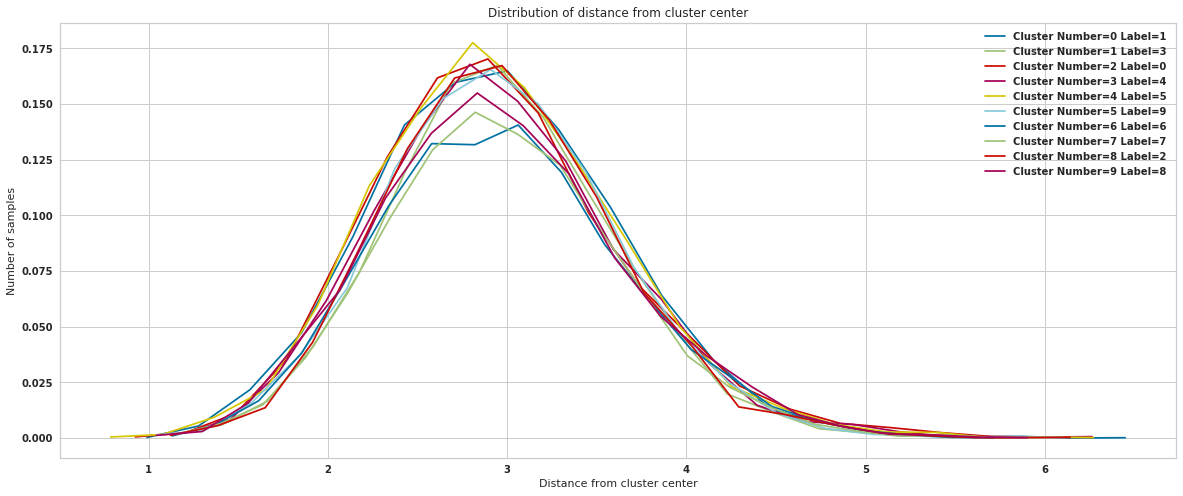

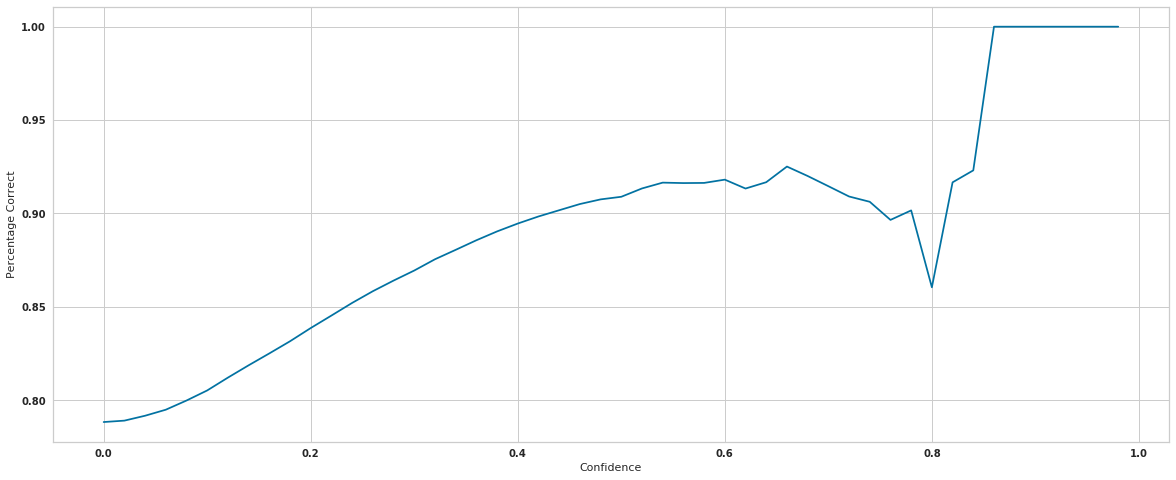

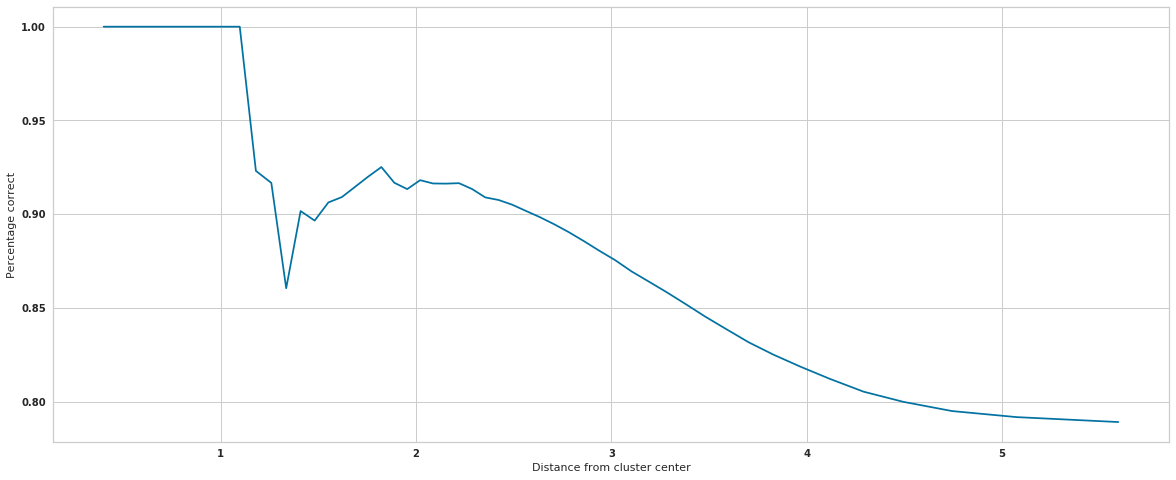

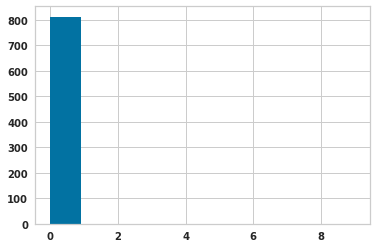

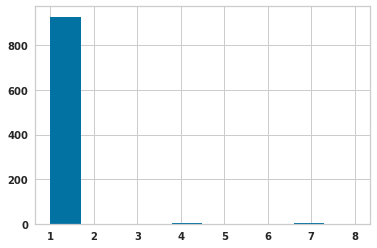

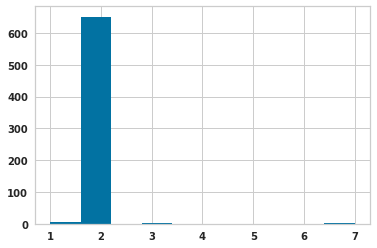

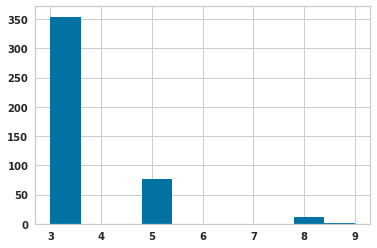

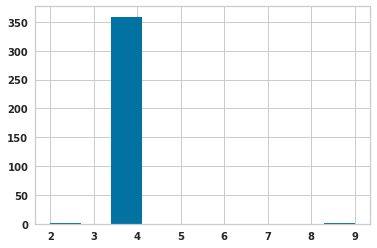

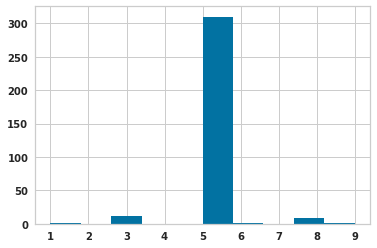

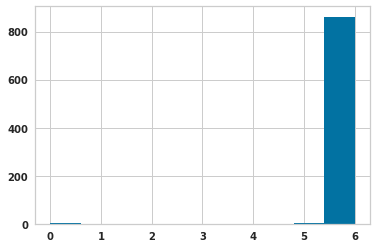

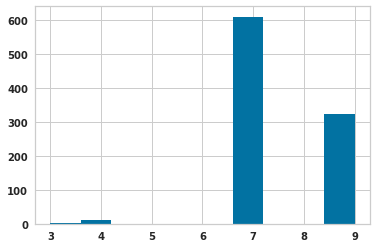

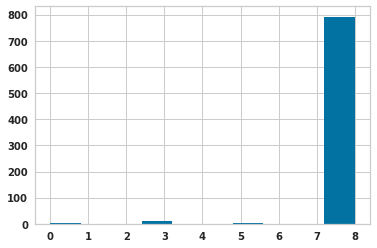

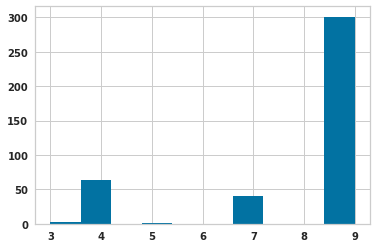

In [92]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# iteration 5

In [93]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k8'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 18705.16382166534
INFO:tensorflow:Summary name Negative Log Likeli

Epoch: 4/65, Nll_loss : 122.68567657470703 KLD:9.729005813598633  Supervised loss:0.07035242021083832
Epoch: 4/66, Nll_loss : 106.83679962158203 KLD:9.193933486938477  Supervised loss:0.06834258139133453
Epoch: 4/67, Nll_loss : 109.43132781982422 KLD:8.958966255187988  Supervised loss:0.1041986346244812
Epoch: 4/68, Nll_loss : 120.68830108642578 KLD:9.28904914855957  Supervised loss:0.09282824397087097
Epoch: 4/69, Nll_loss : 123.19039154052734 KLD:9.396272659301758  Supervised loss:0.09995810687541962
Epoch: 4/70, Nll_loss : 111.7915267944336 KLD:9.474457740783691  Supervised loss:0.07524251937866211
Epoch: 4/71, Nll_loss : 115.55854034423828 KLD:9.67817497253418  Supervised loss:0.07103028893470764
Epoch: 4/72, Nll_loss : 118.01202392578125 KLD:9.750495910644531  Supervised loss:0.0932331308722496
Epoch: 4/73, Nll_loss : 115.87982177734375 KLD:9.688773155212402  Supervised loss:0.07422009855508804
Epoch: 4/74, Nll_loss : 123.27296447753906 KLD:10.06817626953125  Supervised loss:0.076

Epoch: 4/146, Nll_loss : 111.02711486816406 KLD:9.394401550292969  Supervised loss:0.0628301128745079
Epoch: 4/147, Nll_loss : 120.35468292236328 KLD:9.412246704101562  Supervised loss:0.05540475249290466
Epoch: 4/148, Nll_loss : 125.25177001953125 KLD:9.169118881225586  Supervised loss:0.09751809388399124
Epoch: 4/149, Nll_loss : 113.5823974609375 KLD:9.051304817199707  Supervised loss:0.09865348786115646
Epoch: 4/150, Nll_loss : 120.43374633789062 KLD:9.292388916015625  Supervised loss:0.08389253914356232
Epoch: 4/151, Nll_loss : 116.36847686767578 KLD:9.212052345275879  Supervised loss:0.08982473611831665
Epoch: 4/152, Nll_loss : 115.75070190429688 KLD:9.419130325317383  Supervised loss:0.09443743526935577
Epoch: 4/153, Nll_loss : 112.65274810791016 KLD:9.711210250854492  Supervised loss:0.05013775825500488
Epoch: 4/154, Nll_loss : 117.45870971679688 KLD:9.640411376953125  Supervised loss:0.1189931258559227
Epoch: 4/155, Nll_loss : 118.98405456542969 KLD:9.983006477355957  Supervise

Epoch: 4/227, Nll_loss : 114.90135192871094 KLD:9.709911346435547  Supervised loss:0.10084547847509384
Epoch: 4/228, Nll_loss : 119.86480712890625 KLD:9.84225845336914  Supervised loss:0.07681510597467422
Epoch: 4/229, Nll_loss : 114.92672729492188 KLD:9.991913795471191  Supervised loss:0.07693459838628769
Epoch: 4/230, Nll_loss : 120.0460205078125 KLD:9.373550415039062  Supervised loss:0.10523676127195358
Epoch: 4/231, Nll_loss : 119.68104553222656 KLD:9.706518173217773  Supervised loss:0.08299490809440613
Epoch: 4/232, Nll_loss : 112.10012817382812 KLD:9.55652904510498  Supervised loss:0.06860867887735367
Epoch: 4/233, Nll_loss : 115.03546142578125 KLD:9.773177146911621  Supervised loss:0.04338057339191437
Epoch: 4/234, Nll_loss : 117.21470642089844 KLD:9.557757377624512  Supervised loss:0.06149643287062645
Epoch: 4/235, Nll_loss : 117.0927734375 KLD:9.324848175048828  Supervised loss:0.08736854791641235
Epoch: 4/236, Nll_loss : 114.81182098388672 KLD:9.363448143005371  Supervised lo

Epoch: 4/307, Nll_loss : 111.68241882324219 KLD:9.430952072143555  Supervised loss:0.06092962995171547
Epoch: 4/308, Nll_loss : 123.83238220214844 KLD:9.510396957397461  Supervised loss:0.055118583142757416
Epoch: 4/309, Nll_loss : 115.02506256103516 KLD:8.884946823120117  Supervised loss:0.1043664962053299
Epoch: 4/310, Nll_loss : 126.7813720703125 KLD:9.090617179870605  Supervised loss:0.11183176189661026
Epoch: 4/311, Nll_loss : 124.28836059570312 KLD:9.139087677001953  Supervised loss:0.0923677533864975
Epoch: 4/312, Nll_loss : 124.56002044677734 KLD:9.538148880004883  Supervised loss:0.09663394093513489
Epoch: 4/313, Nll_loss : 120.77474975585938 KLD:9.472539901733398  Supervised loss:0.08781254291534424
Epoch: 4/314, Nll_loss : 111.66664123535156 KLD:9.67856216430664  Supervised loss:0.09028608351945877
Epoch: 4/315, Nll_loss : 112.08973693847656 KLD:9.831232070922852  Supervised loss:0.0459919199347496
Epoch: 4/316, Nll_loss : 113.09088897705078 KLD:9.98537826538086  Supervised 

Epoch: 4/388, Nll_loss : 115.50563049316406 KLD:9.271039009094238  Supervised loss:0.09335603564977646
Epoch: 4/389, Nll_loss : 116.96572875976562 KLD:9.012134552001953  Supervised loss:0.0966840535402298
Epoch: 4/390, Nll_loss : 119.2313232421875 KLD:9.479330062866211  Supervised loss:0.08072297275066376
Epoch: 4/391, Nll_loss : 113.78318786621094 KLD:9.29675579071045  Supervised loss:0.10052913427352905
Epoch: 4/392, Nll_loss : 114.67170715332031 KLD:9.701335906982422  Supervised loss:0.08189216256141663
Epoch: 4/393, Nll_loss : 119.05816650390625 KLD:10.021671295166016  Supervised loss:0.08164064586162567
Epoch: 4/394, Nll_loss : 116.444580078125 KLD:9.94151496887207  Supervised loss:0.07817643880844116
Epoch: 4/395, Nll_loss : 115.59761810302734 KLD:9.534143447875977  Supervised loss:0.11911246180534363
Epoch: 4/396, Nll_loss : 111.33689880371094 KLD:10.177024841308594  Supervised loss:0.07486756891012192
Epoch: 4/397, Nll_loss : 105.55844116210938 KLD:9.683893203735352  Supervised

Epoch: 4/470, Nll_loss : 108.51213073730469 KLD:10.233670234680176  Supervised loss:0.06134243309497833
Epoch: 4/471, Nll_loss : 111.58563232421875 KLD:10.174088478088379  Supervised loss:0.05941971391439438
Epoch: 4/472, Nll_loss : 115.60447692871094 KLD:10.119417190551758  Supervised loss:0.06426912546157837
Epoch: 4/473, Nll_loss : 111.61280822753906 KLD:10.101354598999023  Supervised loss:0.04748942330479622
Epoch: 4/474, Nll_loss : 114.07080078125 KLD:9.519933700561523  Supervised loss:0.047081004828214645
Epoch: 4/475, Nll_loss : 118.10010528564453 KLD:9.312997817993164  Supervised loss:0.08820274472236633
Epoch: 4/476, Nll_loss : 114.2885971069336 KLD:9.23127269744873  Supervised loss:0.055188585072755814
Epoch: 4/477, Nll_loss : 120.5434799194336 KLD:8.871212005615234  Supervised loss:0.07725459337234497
Epoch: 4/478, Nll_loss : 117.14282989501953 KLD:8.582503318786621  Supervised loss:0.08891163766384125
Epoch: 4/479, Nll_loss : 119.8514404296875 KLD:8.977535247802734  Supervi

Epoch: 4/552, Nll_loss : 111.67446899414062 KLD:8.892915725708008  Supervised loss:0.11348599195480347
Epoch: 4/553, Nll_loss : 114.91899108886719 KLD:9.505669593811035  Supervised loss:0.10906634479761124
Epoch: 4/554, Nll_loss : 119.20233154296875 KLD:9.351409912109375  Supervised loss:0.0986008420586586
Epoch: 4/555, Nll_loss : 118.01759338378906 KLD:10.083439826965332  Supervised loss:0.10263185948133469
Epoch: 4/556, Nll_loss : 119.21852111816406 KLD:10.245697021484375  Supervised loss:0.06066322699189186
Epoch: 4/557, Nll_loss : 111.3250961303711 KLD:10.363344192504883  Supervised loss:0.07113299518823624
Epoch: 4/558, Nll_loss : 115.80357360839844 KLD:10.123300552368164  Supervised loss:0.06939907371997833
Epoch: 4/559, Nll_loss : 111.62398529052734 KLD:10.366859436035156  Supervised loss:0.0768817886710167
Epoch: 4/560, Nll_loss : 108.90449523925781 KLD:9.700098037719727  Supervised loss:0.06511981785297394
Epoch: 4/561, Nll_loss : 109.92269897460938 KLD:9.659855842590332  Supe

Epoch: 4/632, Nll_loss : 114.2357177734375 KLD:9.147908210754395  Supervised loss:0.07658787816762924
Epoch: 4/633, Nll_loss : 115.92569732666016 KLD:8.873774528503418  Supervised loss:0.08401758968830109
Epoch: 4/634, Nll_loss : 115.49665069580078 KLD:8.92198657989502  Supervised loss:0.11064298450946808
Epoch: 4/635, Nll_loss : 121.41158294677734 KLD:9.278488159179688  Supervised loss:0.11070045083761215
Epoch: 4/636, Nll_loss : 114.32859802246094 KLD:9.49354362487793  Supervised loss:0.10260191559791565
Epoch: 4/637, Nll_loss : 109.43844604492188 KLD:9.424823760986328  Supervised loss:0.08822270482778549
Epoch: 4/638, Nll_loss : 112.29098510742188 KLD:9.775211334228516  Supervised loss:0.06213899701833725
Epoch: 4/639, Nll_loss : 120.63362121582031 KLD:10.130899429321289  Supervised loss:0.10404179245233536
Epoch: 4/640, Nll_loss : 109.2493896484375 KLD:10.08262825012207  Supervised loss:0.08710919320583344
Epoch: 4/641, Nll_loss : 112.72759246826172 KLD:9.878429412841797  Supervise

Epoch: 4/713, Nll_loss : 113.0329818725586 KLD:10.022855758666992  Supervised loss:0.09272253513336182
Epoch: 4/714, Nll_loss : 110.94300842285156 KLD:10.106903076171875  Supervised loss:0.06342003494501114
Epoch: 4/715, Nll_loss : 112.59538269042969 KLD:9.721240997314453  Supervised loss:0.08091533184051514
Epoch: 4/716, Nll_loss : 110.78311920166016 KLD:9.848280906677246  Supervised loss:0.07284428924322128
Epoch: 4/717, Nll_loss : 118.71591186523438 KLD:10.173641204833984  Supervised loss:0.06255927681922913
Epoch: 4/718, Nll_loss : 108.25840759277344 KLD:9.526382446289062  Supervised loss:0.07336492091417313
Epoch: 4/719, Nll_loss : 119.51360321044922 KLD:9.322492599487305  Supervised loss:0.11477914452552795
Epoch: 4/720, Nll_loss : 113.2503433227539 KLD:9.26806354522705  Supervised loss:0.09553737193346024
Epoch: 4/721, Nll_loss : 112.52235412597656 KLD:9.324586868286133  Supervised loss:0.05265422165393829
Epoch: 4/722, Nll_loss : 112.14730834960938 KLD:9.225102424621582  Superv

Epoch: 4/795, Nll_loss : 112.97662353515625 KLD:9.593491554260254  Supervised loss:0.09282061457633972
Epoch: 4/796, Nll_loss : 122.53836059570312 KLD:9.677984237670898  Supervised loss:0.051315248012542725
Epoch: 4/797, Nll_loss : 114.42327117919922 KLD:9.567329406738281  Supervised loss:0.07907828688621521
Epoch: 4/798, Nll_loss : 118.40340423583984 KLD:9.31092643737793  Supervised loss:0.1090804859995842
Epoch: 4/799, Nll_loss : 121.4246597290039 KLD:10.125814437866211  Supervised loss:0.09354523569345474
Epoch: 4/800, Nll_loss : 116.46696472167969 KLD:9.982111930847168  Supervised loss:0.07823014259338379
Epoch: 4/801, Nll_loss : 108.05712127685547 KLD:9.511310577392578  Supervised loss:0.11033998429775238
Epoch: 4/802, Nll_loss : 112.99280548095703 KLD:9.972689628601074  Supervised loss:0.06581509113311768
Epoch: 4/803, Nll_loss : 111.73682403564453 KLD:9.427331924438477  Supervised loss:0.11521930992603302
Epoch: 4/804, Nll_loss : 112.09854125976562 KLD:10.028814315795898  Superv

Epoch: 4/876, Nll_loss : 111.96017456054688 KLD:9.173127174377441  Supervised loss:0.09495754539966583
Epoch: 4/877, Nll_loss : 119.39251708984375 KLD:9.563854217529297  Supervised loss:0.1147100180387497
Epoch: 4/878, Nll_loss : 118.56504821777344 KLD:9.903159141540527  Supervised loss:0.10063930600881577
Epoch: 4/879, Nll_loss : 109.22285461425781 KLD:9.88138484954834  Supervised loss:0.07564665377140045
Epoch: 4/880, Nll_loss : 109.14279174804688 KLD:9.788494110107422  Supervised loss:0.09157050400972366
Epoch: 4/881, Nll_loss : 112.11339569091797 KLD:10.455595016479492  Supervised loss:0.05336645990610123
Epoch: 4/882, Nll_loss : 115.03844451904297 KLD:10.35500717163086  Supervised loss:0.11727757751941681
Epoch: 4/883, Nll_loss : 106.97050476074219 KLD:10.074849128723145  Supervised loss:0.06316225230693817
Epoch: 4/884, Nll_loss : 119.0147705078125 KLD:10.387147903442383  Supervised loss:0.07123492658138275
Epoch: 4/885, Nll_loss : 110.33161163330078 KLD:9.82402515411377  Supervi

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k8/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-4675
 [*] Success to read SemiSupervisedClassifierMnist.model-4675
 [*] Load SUCCESS
Number of steps completed=4675
Number of epochs completed 5.0
run_id=45 z_min=-4.5695 z_max=4.2435517
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using 

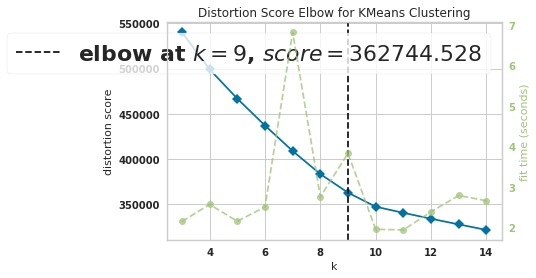

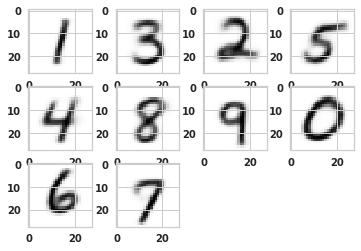

In [95]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


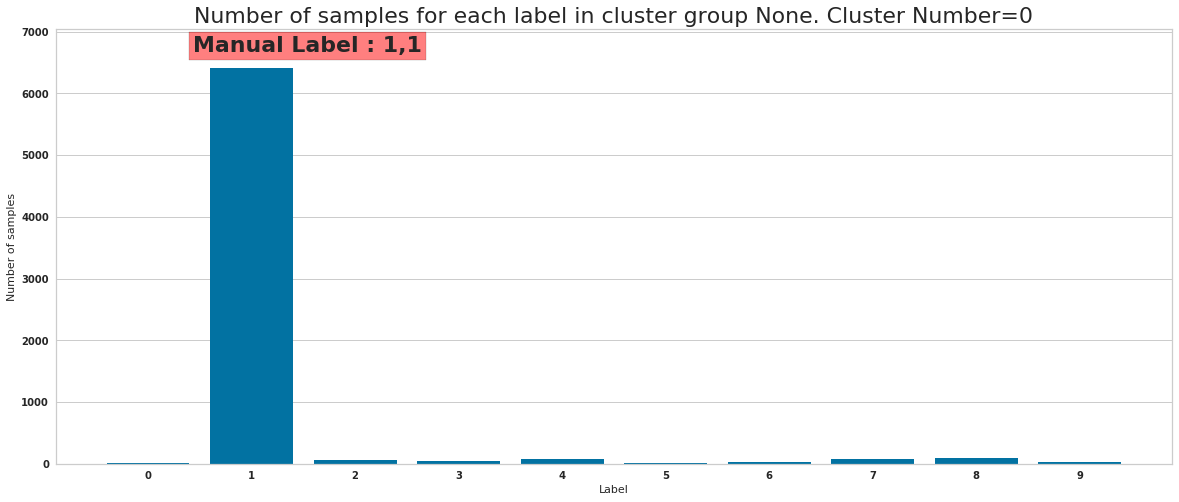

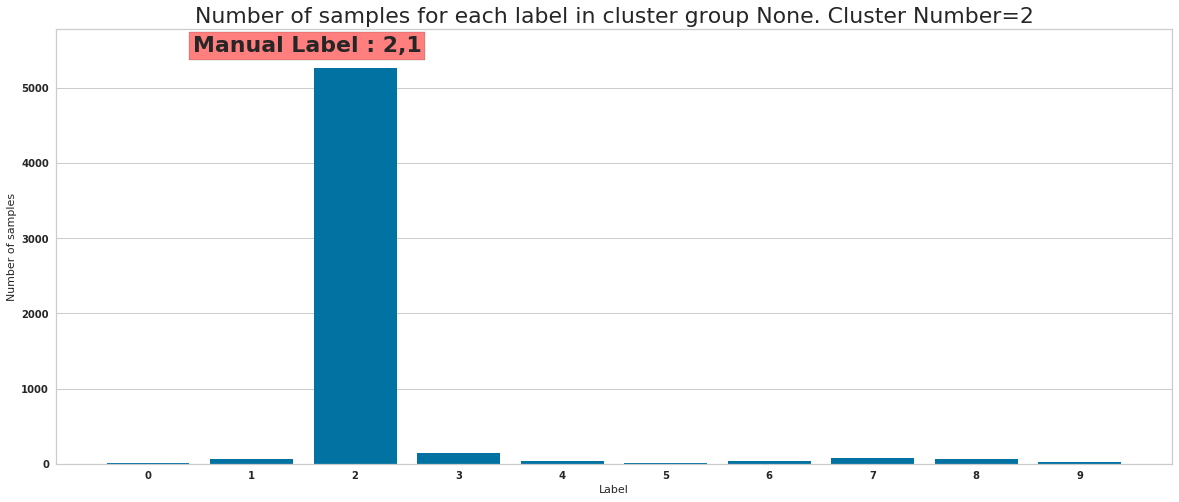

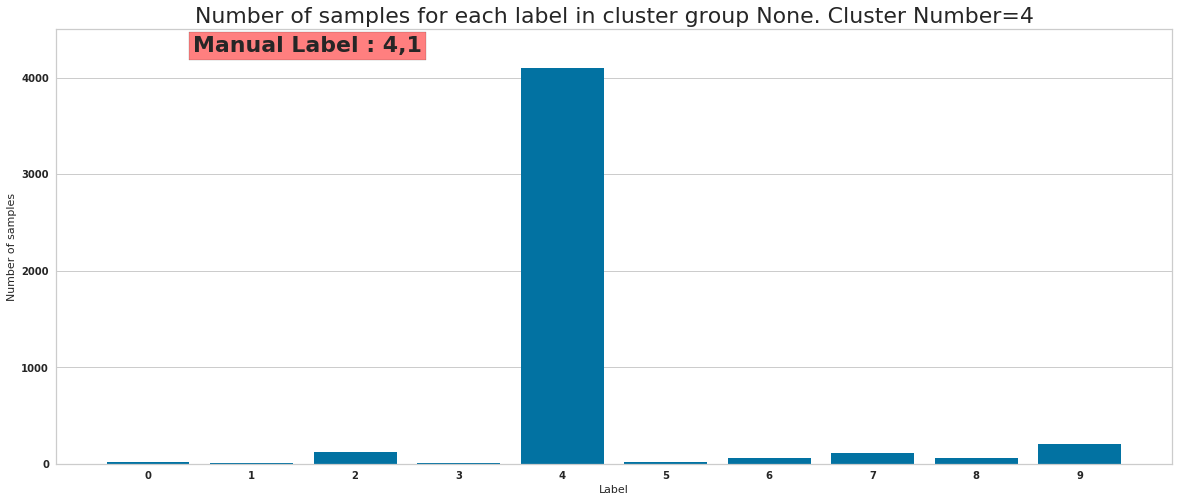

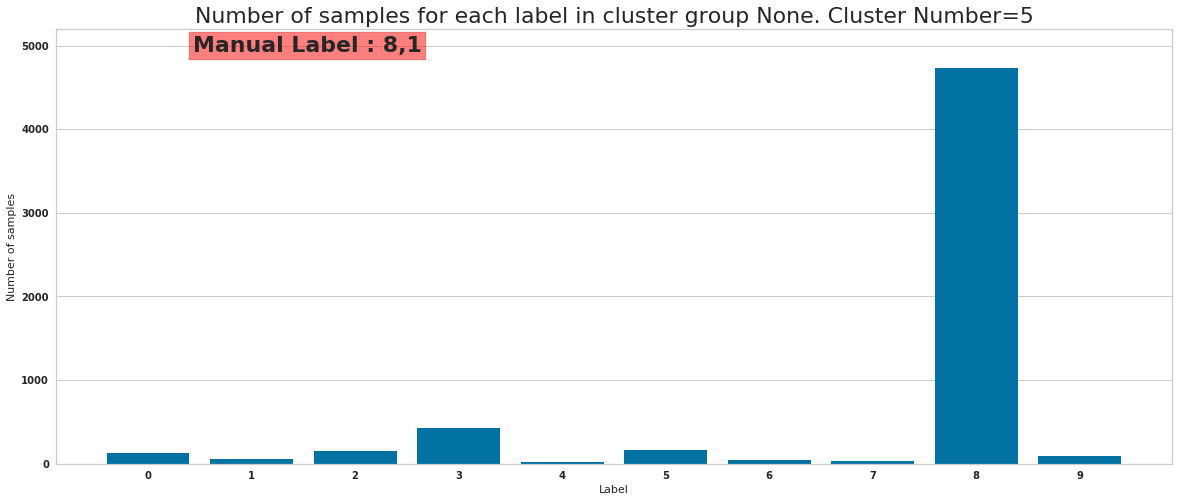

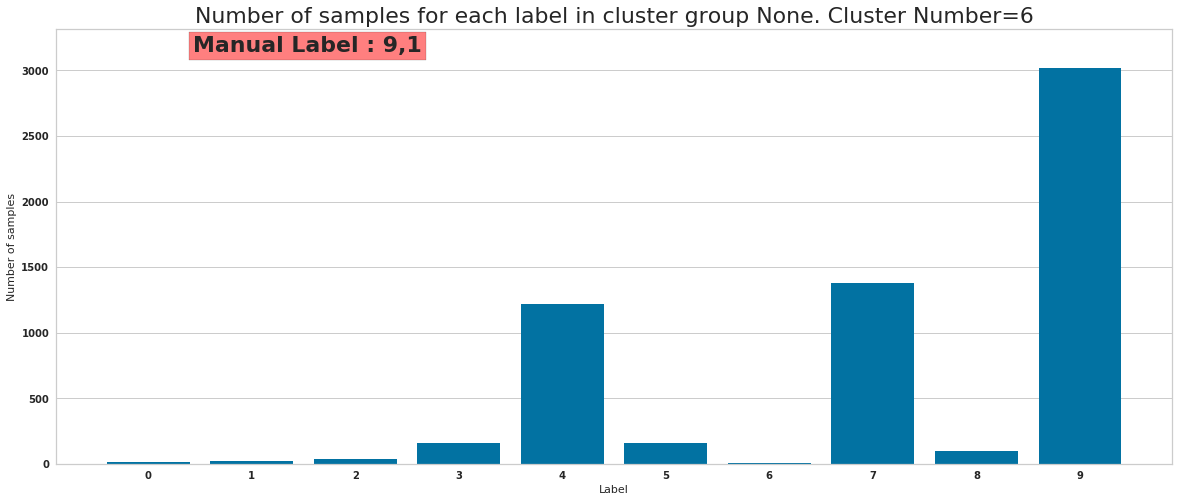

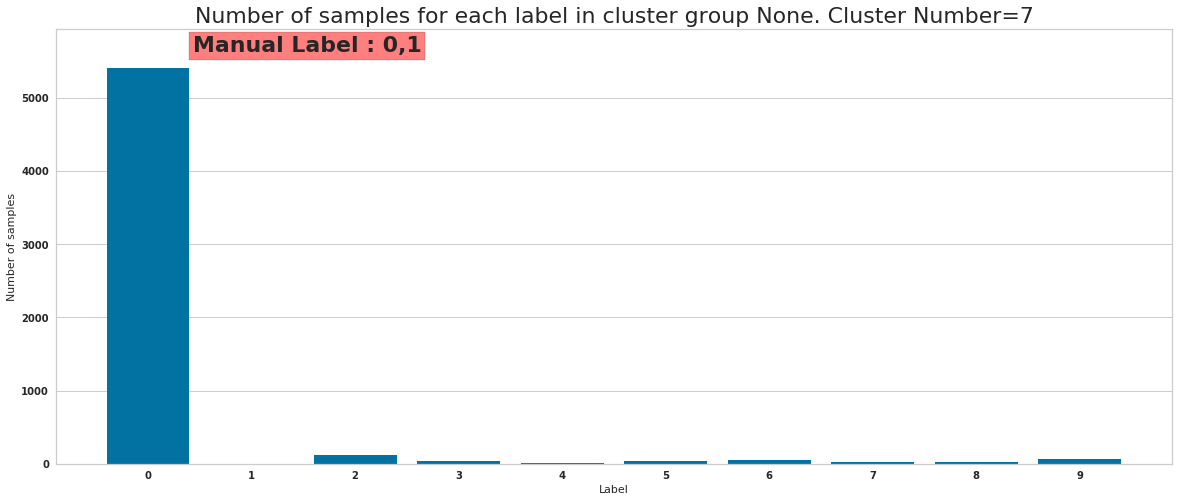

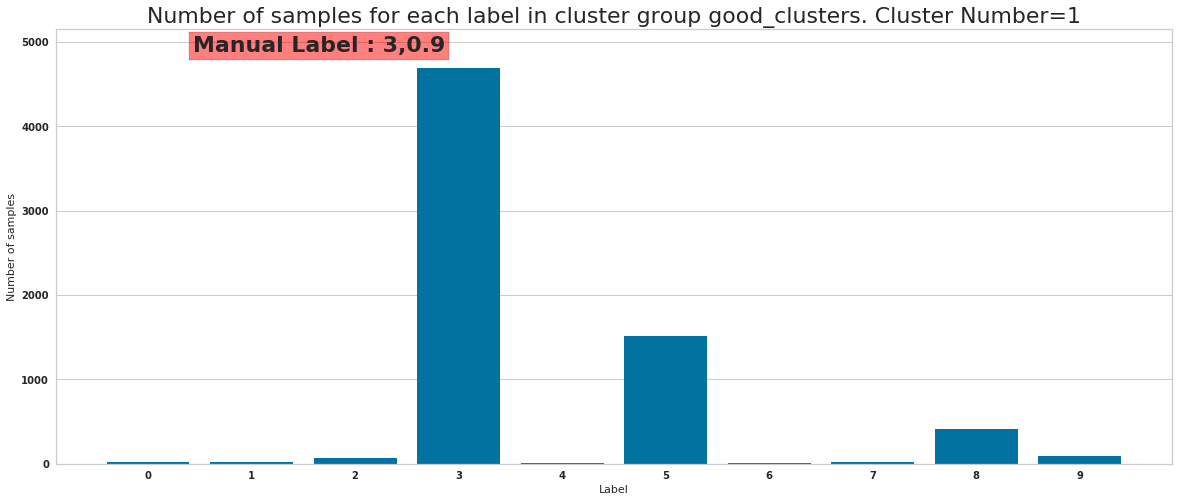

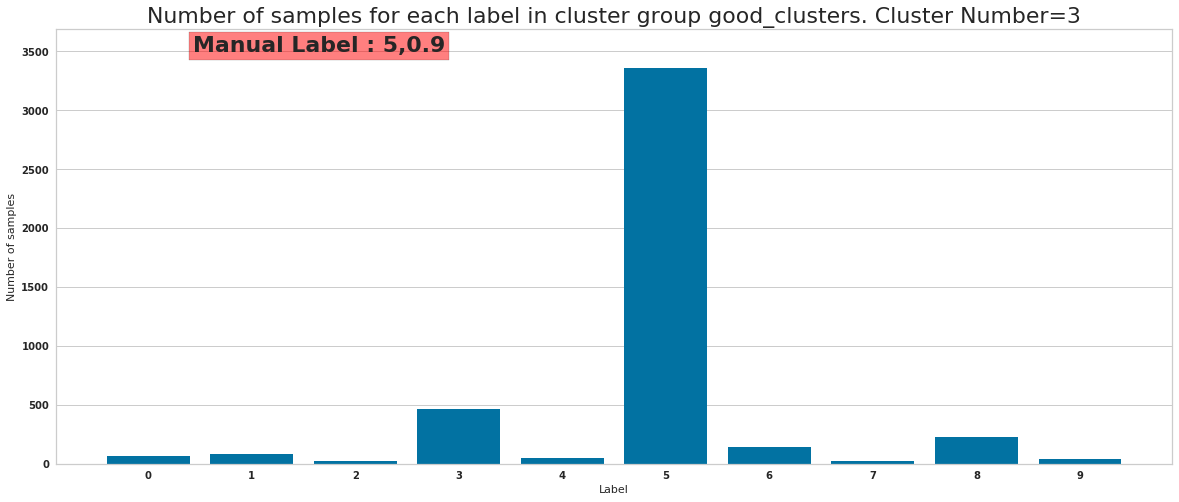

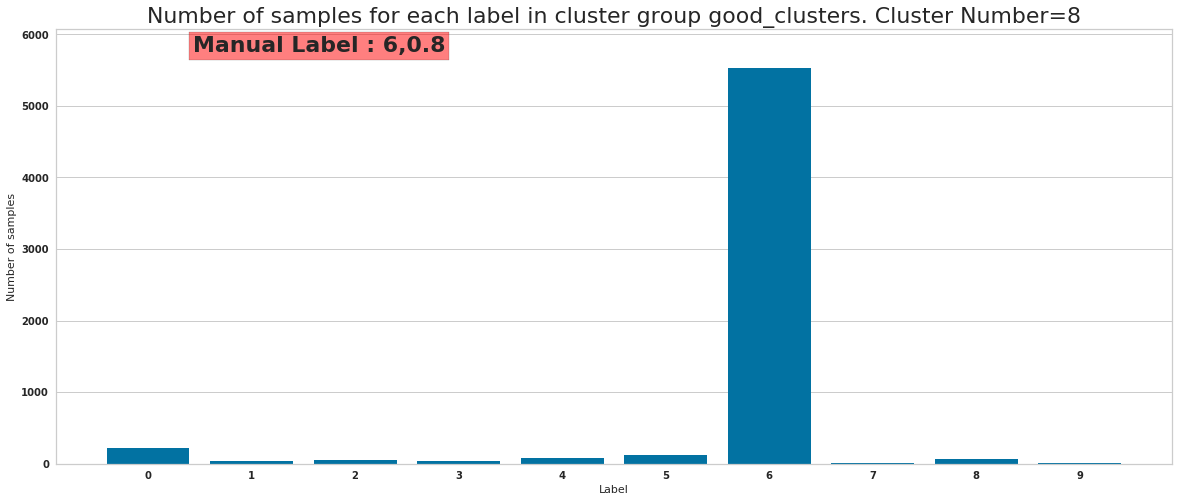

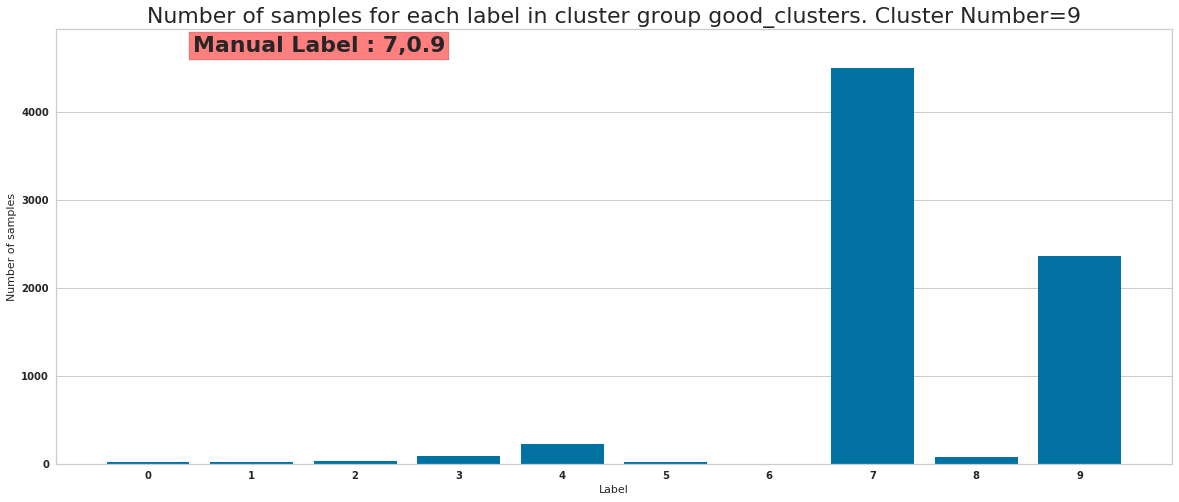

In [96]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [1,3,2,5,
                                           4,8,9,0,
                                           6,7
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.9,1,0.9,
                                               1,1,1,1,
                                               0.8,0.9
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



In [97]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(6832, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(6863, 10)
(5732, 10)
(4475, 10)
(4705, 10)
(5834, 10)
(6111, 10)
(5777, 10)
(6173, 10)
(7338, 10)


In [98]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [99]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 1
(6832, 47) (6832, 33)
Num correct=6405
Cluster 0 Manual Label 1 Percentage correct 93.75
********************************
Manual Label 3
(6863, 47) (6863, 33)
Num correct=4686
Cluster 1 Manual Label 3 Percentage correct 68.2791782019525
********************************
Manual Label 2
(5732, 47) (5732, 33)
Num correct=5260
Cluster 2 Manual Label 2 Percentage correct 91.76552686671319
********************************
Manual Label 5
(4475, 47) (4475, 33)
Num correct=3356
Cluster 3 Manual Label 5 Percentage correct 74.99441340782123
********************************
Manual Label 4
(4705, 47) (4705, 33)
Num correct=4095
Cluster 4 Manual Label 4 Percentage correct 87.03506907545164
********************************
Manual Label 8
(5834, 47) (5834, 33)
Num correct=4726
Cluster 5 Manual Label 8 Percentage correct 81.00788481316421
********************************
Manual Label 9
(6111, 47) (6111, 33)
Num correct=3015
Cluster 6 Manual Label 9 Percentage correct 49.337260677466865
**

In [100]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

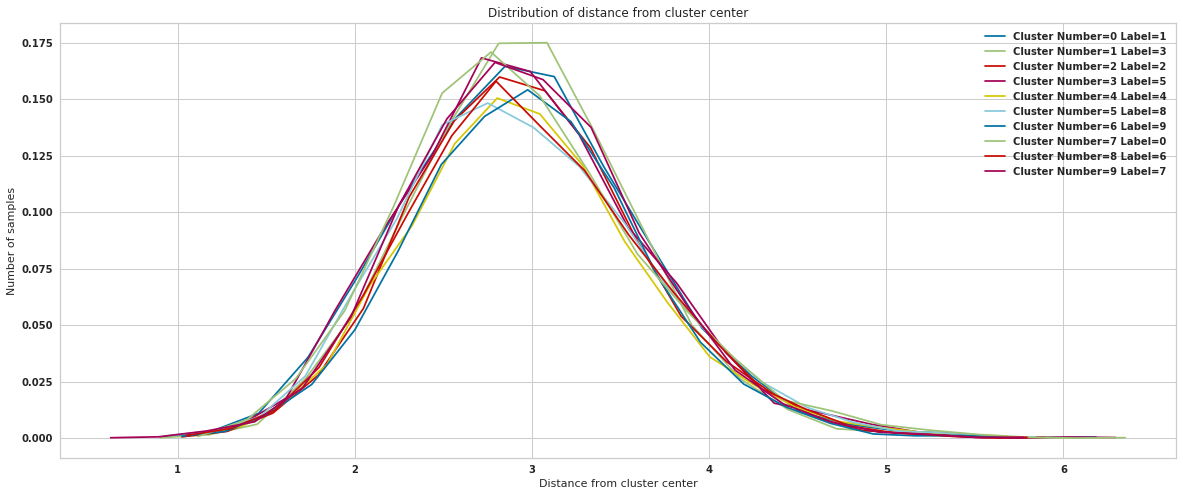

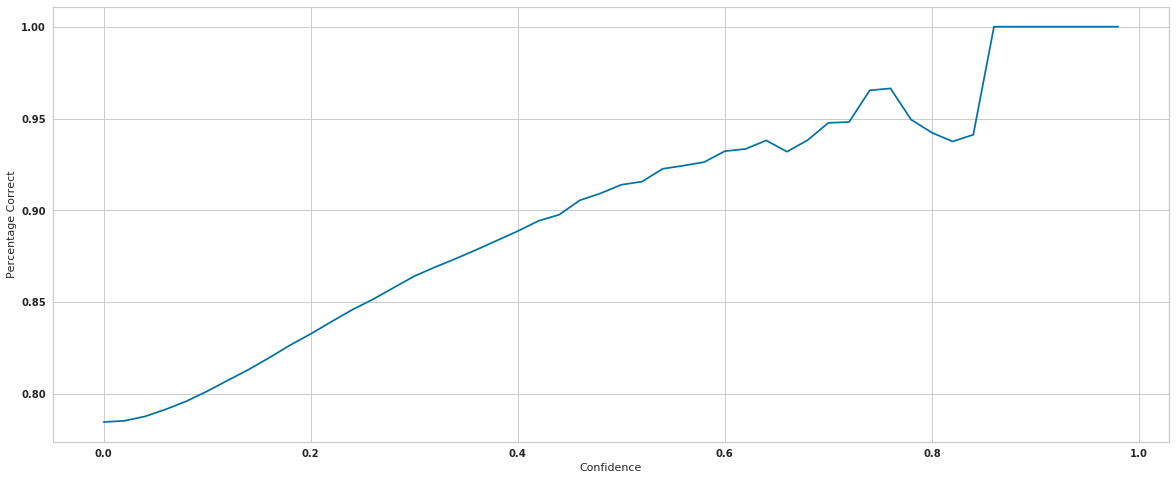

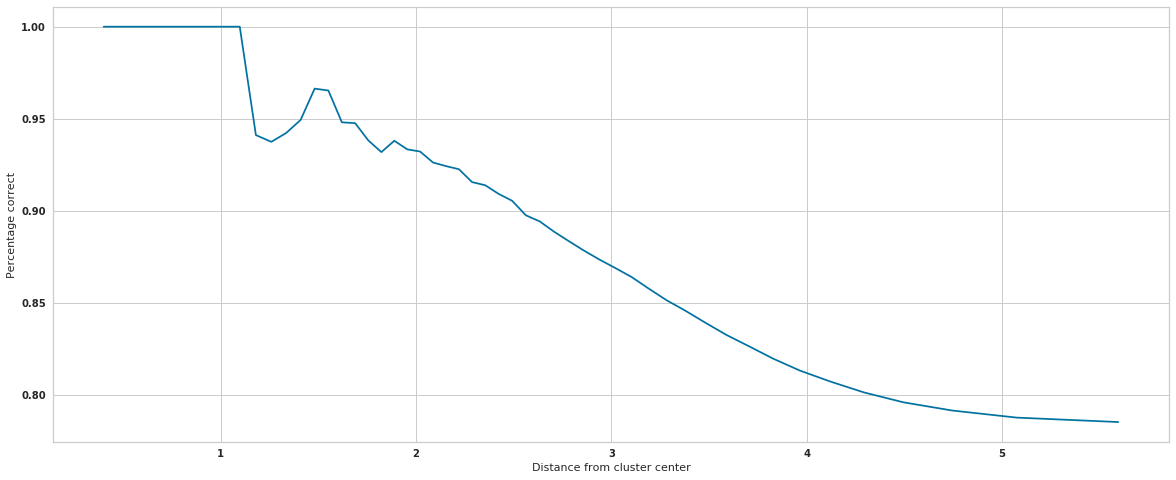

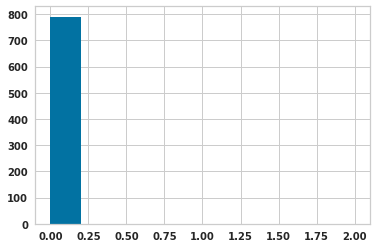

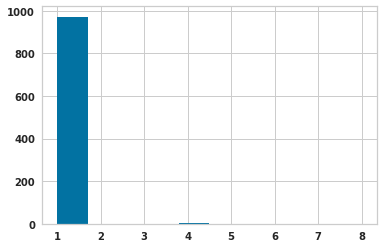

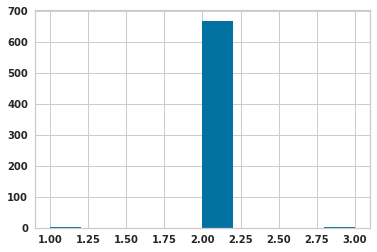

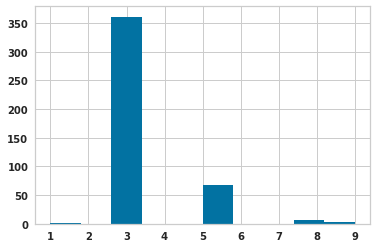

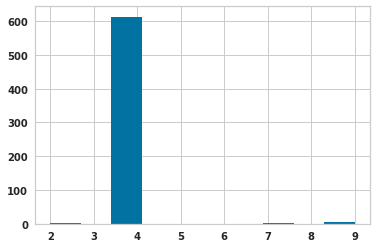

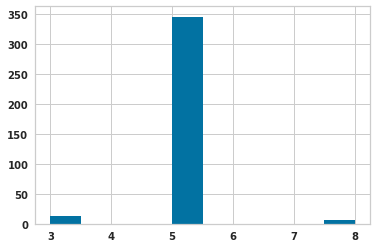

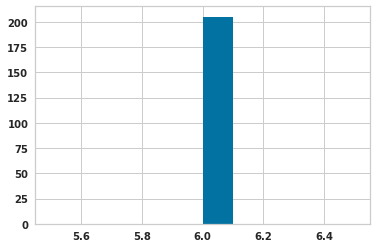

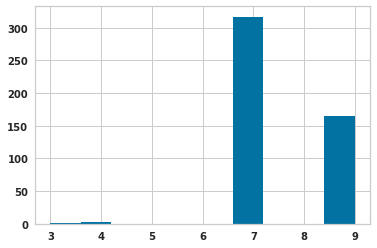

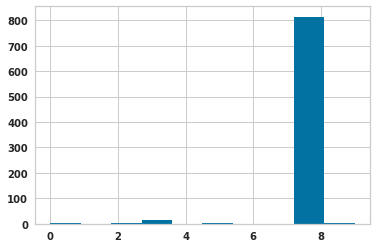

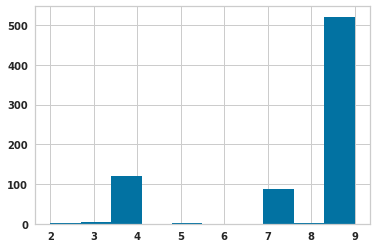

In [101]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()